## Import des librairies

In [1]:
import pandas as pd
import numpy as np
import string
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import matplotlib.dates as mdates

## Nettoyage des données

### Fonctions utilisés pour le nettoyage

Cette partie nous permet de regrouper les différentes fonctions réalisées pour le nettoyage des bases de données avant de les afficher pour les étudier. 

La fonction suivante permet de récuperer le fichier souhiaté à l'aide de son chemin d'accès.

In [2]:
def use_data(path):
  return pd.read_csv(path, sep='|')

Suite à cela, nous créons une liste avec des noms de colonnes que nous souhiatons supprimer par manque d'intérêt pour ces dernières. Nous appelons la fonction drop_columns qui supprime simplement les colonnes de la liste.

In [3]:
def drop_columns(df, list_columns):
    return df.drop(columns=list_columns, errors='ignore')

La fonction 'changer_particulier' nous permet de modifier le type de nos données en fonction des différentes colonnes. Elle retourne le dataframe modifié.

In [4]:
def changer_particulier(data):
  # Utiliser pd.to_numeric pour convertir en nombres, en forçant les valeurs non convertibles à NaN
  data['Code postal'] = pd.to_numeric(data['Code postal'], errors='coerce')

  # Remplacer les NaN par un nombre (par exemple, 0), puis convertir en entiers
  data['Code postal'] = data['Code postal'].fillna(0).astype(int)

  #Convertir en chaînes de caractères et préfixer avec des zéros jusqu'à ce que la longueur soit de 5
  data['Code postal'] = data['Code postal'].astype(str).apply(lambda x: x.zfill(5))

  data['Valeur fonciere'] = data['Valeur fonciere'].str.replace(',', '.')
  data['Valeur fonciere'] = data['Valeur fonciere'].astype('float')

  data['Nature mutation'] = data['Nature mutation'].astype('str')
  data['Type de voie'] = data['Type de voie'].astype('str')
  data['Voie'] = data['Voie'].astype('str')
  data['Commune'] = data['Commune'].astype('str')
  data['Type local'] = data['Type local'].astype('str')

  return data

La fonction suivante permet de généraliser celle d'au-dessus. 'changer_types' permet de mettre les float en int et les object en str

In [5]:
def changer_types(data):
    for col in data.columns:
        # Vérifie si le type de données est float64 et le convertit en int64
        if data[col].dtypes == 'float64':
            data[col] = pd.to_numeric(data[col], errors='coerce')
            data[col] = data[col].fillna(0).astype('int')
        # Vérifie si le type de données est object et le convertit en string
        elif data[col].dtypes == 'object':
            data[col] = data[col].astype('str')
    return data

La fonction 'drop_rows' supprime certaines lignes souhiatées. 

In [6]:
def drop_rows(data):
    #1.suppression des ventes qui faussent les prix (liées a leur nature)
    drop_index_1=data[(data['Nature mutation']=='Echange')|(data['Nature mutation']=='Expropriation')|(data['Nature mutation']=="Vente en l'état futur d'achèvement")].index
    data=data.drop(drop_index_1,axis=0)
    #2.suppression des lignes sans valeur fonciere ou sans surface reelle bati et sans surface terrain
    drop_index_2=data[((data['Valeur fonciere']==0)|((data['Surface reelle bati']==0)&(data['Surface terrain']==0)))==True].index
    return data.drop(drop_index_2,axis=0)

Cette fonction permet de modifier le type de local et renvoie le dataframe modifié.

In [7]:
def local(type_local):
    if 'Dépendance' in type_local.values: #si type local est une dépendance
        for typelocal in type_local: #parcourt des types de local
            if typelocal == 'Maison' or typelocal == 'Appartement': #si existence de maison ou appartement dans le groupby
                # fin de la fonction et elle retournera maison ou appart + dépendance car typelocal contenait maison ou appart et dépendance
                return typelocal + ' et dépendance'
            elif typelocal == 'Local industriel. commercial ou assimilé': #si type local est local indus alors
                return 'Local industriel. commercial ou assimilé' #l'aggregation renvoie local indus

            #si aucun des trois n'est présent alors c'est une dépendance seule
            elif ((typelocal != 'Local industriel. commercial ou assimilé') and (typelocal!='Maison') and (typelocal!='Appartement')):
                return 'Dépendance seule'
    else: #si dépendance n'est pas présent alors on retourne le premier élément pour aggregation
        return type_local.iloc[0]

La fonction 'doublons' nous permet de gérer les différents doublons que nous pouvons rencontrer dans le dataframe.

In [8]:
def doublons(data):
    nom = ['Date mutation','Valeur fonciere', 'Code postal', 'Commune']

    aggregations = {
                 'Surface reelle bati' : 'max',
                 'Nombre pieces principales' : 'max',
                 'Type local' : local,
                 'Surface terrain' : 'max',
                 'Nature mutation': 'first'
                 }
    
    #groupby en fonction de la liste nom et en remettant les aggregations choisies
    data = data.groupby(nom).agg(aggregations)
    data = data.reset_index()

    #Ordre du dataframe
    cols = list(data.columns)
    cols.insert(1, cols.pop(cols.index('Nature mutation')))
    data = data[cols]

    return(data)

La fonction suivante 'create_columns' permet de créer une nouvelle colonne. Nous l'utilisons pour récupérer le code du département.

In [9]:
def create_columns(data, new_col, ancient_col, position):
    #creation de la nouvelle colonne
    data[new_col] = data[ancient_col].apply(lambda x: str(x)[:2]) #lambda pour récupérer les deux premiers elements de la chaine str
    #insertion de la nouvelle colonne a la position voulue
    data.insert(position, new_col, data.pop(new_col)) 
    return data


La fonction 'windsorization_outliers' permet de gérer les valeurs extrêmes. Pour cela, on remplace les valeurs extrêmes par les valeurs aux quantiles.

In [10]:
#gestion des valeurs aberrantes (remplacement par valeur des quantiles)
def windsorization_outliers(data, column, alpha=0.95):
    #quantiles
    q_min=data[column].quantile(1-alpha)
    q_max=data[column].quantile(alpha)

    #recuperation des lignes ou les valeurs doivent etre changees
    lines_outliers_down=(data[column]<q_min)
    lines_outliers_up=(data[column]>q_max)

    #Remplacement
    data[column][lines_outliers_down] = q_min
    data[column][lines_outliers_up] = q_max

    return data

La fonction 'normalized' permet de normaliser les valeurs de certaines colonnes.

In [11]:
def normalized(data, col, new_col_name):
    #Calcul de la colonne normalise
    normalized_col = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

    #Trouver la position de la colonne originale
    position = data.columns.get_loc(col) + 1

    #Insertion la nouvelle colonne normalisee juste apres la colonne originale
    data.insert(position, new_col_name, normalized_col)

    return data

In [12]:
def gestion_departement_local(dataframe):
    # Supprimer les lignes où les départements ne sont pas compris entre '01' et '96' inclus
    dataframe_filtre = dataframe[dataframe['Département'].between('01', '96')]
    dataframe_filtre = dataframe[dataframe['Type local'] != 'nan']

    return dataframe_filtre

In [13]:
# Fonction changement du nom des villes qui ont des arrondissements
def replace_city(value):
    if value.startswith('PARIS '): #L'espace permet de ne pas prendre des villes qui commence par Paris avec un tiret
        return 'PARIS'
    elif value.startswith('MARSEILLE '):
        return 'MARSEILLE'
    elif value.startswith('LYON '):
        return 'LYON'
    else:
        return value

Nous faisons à présent l'appel général de toutes les fonctions pour charger les fichiers comme souhaités.

In [14]:
#Fonction qui appelle toutes les fonction de nettoyage des donnees 
def create_dataframe(path):
   data = use_data(path)

   #liste des colonnes que l'on a choisi de ne pas garder
   list_columns = ['No disposition', 'Code voie', 'Code commune', 'Section', 'No plan',
       '1er lot', 'Nombre de lots', 'Nature culture', 'No voie']
   
   #liste des colonnes que l'on va normalisé 
   windsor = ['Valeur fonciere', 'Surface terrain', 'Surface reelle bati', 'Nombre pieces principales']
   
   data = drop_columns(data, list_columns)
   data = changer_particulier(data)
   data = changer_types(data) 
   data = drop_rows(data) 
   data = doublons(data)
   data = create_columns(data, 'Département','Code postal', 3)
   data = gestion_departement_local(data)
   data['Commune'] = data['Commune'].apply(replace_city)

   for col in windsor:
      data = windsorization_outliers(data, col, 0.95)
      data = normalized(data, col, col+' normalisee')

   data.set_index('Date mutation', inplace=True)

   return data

La fonction 'check_date' permet de vérifier si les données correspondent bien à la date souhaitée. 

In [15]:
def check_date(data, annee):
    data.index = pd.to_datetime(data.index, format='%d/%m/%Y')
    # Filtrer les données par année
    data2 = data[data.index.year == annee]

    return data2

## Import des donnees

In [16]:
#recuperation des chemins d acces
dir_path = os.path.dirname(os.path.abspath("__file__"))
file_path = os.path.join(dir_path, 'taux_directeur.csv')

In [17]:
#Import of bases de donnees (dossiers immo et taux)
data_2018_s2 = create_dataframe(dir_path+"/valeursfoncieres-2018-s2.txt")
data_2019 = create_dataframe(dir_path+"/valeursfoncieres-2019.txt")
data_2020 = create_dataframe(dir_path+"/valeursfoncieres-2020.txt")
data_2021 = create_dataframe(dir_path+"/valeursfoncieres-2021.txt")
data_2022 = create_dataframe(dir_path+"/valeursfoncieres-2022.txt")
data_2023 = create_dataframe(dir_path+"/valeursfoncieres-2023.txt")

df_taux = pd.read_csv(file_path)

/var/folders/4m/vc47n3kj46n18ktvg188lrv00000gn/T/ipykernel_22232/1624399225.py:2: DtypeWarning: Columns (18,23,24,26,28,31,33) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path, sep='|')
/var/folders/4m/vc47n3kj46n18ktvg188lrv00000gn/T/ipykernel_22232/4099560554.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column][lines_outliers_down] = q_min
/var/folders/4m/vc47n3kj46n18ktvg188lrv00000gn/T/ipykernel_22232/4099560554.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column][lines_outliers_up] = q_max
/var/folders/4m/vc47n3kj46n18ktvg188lrv00000gn/T/

In [ ]:
df_taux['DATE'] = pd.to_datetime(df_taux['DATE']) #format date
df_taux = df_taux[(df_taux['DATE'] >= '2018-07-01') & (df_taux['DATE'] <= '2023-12-31')] #choix de la plage de donnees
df_taux.set_index('DATE', inplace=True) #date en index

# Renommer la colonne dans le DataFrame df_taux
df_taux.rename(columns={'Main refinancing operations - Minimum bid rate/fixed rate (date of changes) - Level (FM.D.U2.EUR.4F.KR.MRR_RT.LEV)': 'Taux'},
               inplace=True)

In [ ]:
#tri des index 
data_2018_s2 = data_2018_s2.sort_index()
data_2019 = data_2019.sort_index()
data_2020 = data_2020.sort_index()
data_2021 = data_2021.sort_index()
data_2022 = data_2022.sort_index()
data_2023 = data_2023.sort_index()

In [ ]:
#concatenation des datframe dans un seul qui sera utilise plus tard 
data_all_years = pd.concat([data_2018_s2, data_2019, data_2020, data_2021, data_2022, data_2023])

data_all_years['Taux'] = 0
# Mappez les taux de df_taux à data_all_years en utilisant l'index comme cle
data_all_years['Taux'] = data_all_years.index.map(df_taux['Taux'])

# Maintenant 'data_all_years' contient la colonne 'Taux' avec les valeurs appropriees.
# Modifier l'index en format datetime en specifiant le format correct
data_all_years.index = pd.to_datetime(data_all_years.index, format='%d/%m/%Y', dayfirst=True)

In [ ]:
#remplacement de NaN par 0 
data_all_years['Taux'].fillna(0, inplace=True)

/var/folders/5j/h3r6q8550vg1h4rc69vgdp5c0000gn/T/ipykernel_2806/1242909835.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_all_years['Taux'].fillna(0, inplace=True)


In [ ]:
#fonction qui split les dataframe annuelle en dataframe semestrielle 
def créer_dataframes_semestriels(df, year):
    # Definition des dates de début et de fin pour chaque semestre
    start_date_1 = pd.to_datetime(f'{year}-01-01')
    end_date_1 = pd.to_datetime(f'{year}-06-30')
    start_date_2 = pd.to_datetime(f'{year}-07-01')
    end_date_2 = pd.to_datetime(f'{year}-12-31')
    
    # Verifier si la date de début du S1 est dans le DataFrame
    if start_date_1 not in df.index:
        start_date_1 = df.index[0]  # Utiliser la premiere date disponible si le 1er janvier n'est pas présent
    
    # Verifier si la date de fin du S1 est dans le DataFrame
    if end_date_1 not in df.index and not df.index.is_monotonic_increasing:
        end_date_1 = df.index[df.index.get_loc(end_date_1, method='nearest')]
    
    # Verifier si la date de début du S2 est dans le DataFrame
    if start_date_2 not in df.index:
        start_date_2 = df.index[df.index.get_loc(start_date_2, method='nearest')]

    if end_date_2 not in df.index:
        end_date_2 = df.index[-1]
        
    # Utiliser loc pour obtenir les donnees du premier semestre
    df_first_half = df.loc[start_date_1:end_date_1]
    # Utiliser loc pour obtenir les donnees du second semestre
    df_second_half = df.loc[start_date_2:end_date_2]
    
    return df_first_half, df_second_half

In [ ]:
# Annees necessitant un decoupage semestriel
annees_semestrielles = range(2019, 2024)  # De 2019 à 2023 inclus

# Application de la fonction check_date pour les années spécifiées
for année in annees_semestrielles:
    data_année = globals()[f'data_{année}']
    globals()[f'data_{année}'] = check_date(data_année, année)

# Création des dataframes semestriels pour les années de 2019 à 2023, et uniquement s2 pour 2018
for année in annees_semestrielles:
    if f'data_{année}' in globals():
        data_année = globals()[f'data_{année}']
        globals()[f'data_{année}_s1'], globals()[f'data_{année}_s2'] = créer_dataframes_semestriels(data_année, année)


data_2018_s2 = check_date(data_2018_s2,2018)

# Liste de tous les dataframes semestriels
dataframes = [data_2018_s2, data_2019_s1,data_2019_s2,data_2020_s1,data_2020_s2,data_2021_s1,data_2021_s2,data_2022_s1,data_2022_s2,data_2023_s1,data_2023_s2]

In [ ]:
#liste contenant le nom des dataframes 
list_dataframes = ['data_2018_s2']

#Boucler sur les années et les semestres pour reconstruire les noms
for year in range(2019, 2024):  # jusqu'à 2023 inclus
    for semester in range(1, 3):  # Semestre 1 et 2
        # Construire le nom de la variable
        name = f"data_{year}_s{semester}"
        list_dataframes.append(name)

print(list_dataframes)

['data_2018_s2', 'data_2019_s1', 'data_2019_s2', 'data_2020_s1', 'data_2020_s2', 'data_2021_s1', 'data_2021_s2', 'data_2022_s1', 'data_2022_s2', 'data_2023_s1', 'data_2023_s2']


In [ ]:
# Création d'une plage de semestres de mi-2018 à 2023
semesters = pd.date_range(start='2018-07-01', end='2023-12-31', freq='6M')

#liste contenant les taux en vigueur a chaque semestre (qui permettra de faire les graphiques)
taux_sem = []
for date in semesters :
    taux_sem.append(df_taux.loc[date, 'Taux'])


/var/folders/5j/h3r6q8550vg1h4rc69vgdp5c0000gn/T/ipykernel_2806/1452997332.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  semesters = pd.date_range(start='2018-07-01', end='2023-12-31', freq='6M')


## Statistiques et graphiques (global)


### Par colonne / par année

La fonction suivante permet de calculer des statistiques en fonction des types de données.

In [51]:
# fonction qui me permettra de faire quelques statistiques de base
def stats(dataframe, column_name):
    if column_name not in dataframe.columns:
        raise ValueError(f"La colonne {column_name} n'existe pas dans le dataframe!")

    # Vérifier le type de données de la colonne
    if pd.api.types.is_datetime64_any_dtype(dataframe[column_name]):
        # Si c'est une colonne datetime, calculez les statistiques pertinentes
        return {
            'count': dataframe[column_name].notnull().sum(),
            'min': dataframe[column_name].min(),
            'max': dataframe[column_name].max()
        }
    else:
        # Utilisation de la méthode describe pour les autres types de données
        return dataframe[column_name].describe()

La fonction suivante permet de creer des graphiques en fonction des types de données

In [52]:
#fonction qui permet de faire des graphes de stats (histogramme, boîte à moustache)
def Graph1(dataframe, column_name):
    if column_name not in dataframe.columns:
        print(f"La colonne '{column_name}' n'existe pas dans le dataframe fourni.")
        return

    if dataframe[column_name].dtypes == np.float64 or dataframe[column_name].dtypes == np.int64:
        # Boîte à moustaches
        plt.figure(figsize=(8, 4))
        ax = sns.boxplot(x=dataframe[column_name], color='lightblue', fliersize=5)

        # Affichage des valeurs des quartiles et de la médiane
        med = dataframe[column_name].median()
        q1 = dataframe[column_name].quantile(0.25)
        q3 = dataframe[column_name].quantile(0.75)

        ax.text(q1, 0.1, f"{q1:.2f}", horizontalalignment='center', size='x-small', color='red', weight='semibold')
        ax.text(med, 0.1, f"{med:.2f}", horizontalalignment='center', size='x-small', color='black', weight='semibold')
        ax.text(q3, 0.1, f"{q3:.2f}", horizontalalignment='center', size='x-small', color='red', weight='semibold')

        plt.title(f'Boîte à moustaches de {column_name}', fontsize=15)
        plt.xlabel(column_name, fontsize=12)
        plt.tight_layout()
        plt.show()

        # Histogramme
        plt.figure(figsize=(8, 4))
        ax = plt.hist(dataframe[column_name].dropna(), bins=30, color='skyblue', alpha=0.7, edgecolor='black')

        plt.title(f'Histogramme de {column_name}', fontsize=15)
        plt.xlabel(column_name, fontsize=12)
        plt.ylabel('Fréquence', fontsize=12)

        # Ajout de lignes pour la moyenne ou la médiane
        mean_val = dataframe[column_name].mean()
        median_val = dataframe[column_name].median()

        plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1, label=f'Moyenne: {mean_val:.2f}')
        plt.axvline(median_val, color='green', linestyle='dashed', linewidth=1, label=f'Médiane: {median_val:.2f}')

        plt.legend()
        plt.tight_layout()
        plt.show()

    if dataframe[column_name].dtypes == 'object':
        # Utiliser un style de graphique plus élégant
        sns.set(style="whitegrid")

        plt.figure(figsize=(9, 4))
        ax = sns.countplot(x=dataframe[column_name])
        ax.set_title(f'Histogramme de la répartition de {column_name}', fontsize=15)
        ax.set_xlabel(f"Répartition de {column_name}", fontsize=12)
        ax.set_ylabel('Nombre', fontsize=12)

        # Rotation des étiquettes de l'axe des x pour une meilleure lisibilité
        plt.xticks(rotation=45, ha='right')

        # Ajouter les annotations de texte pour chaque barre
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                        textcoords='offset points')

        plt.tight_layout()
        plt.show()

    
    return


Statistiques du DataFrame data_2018_s2: 

Colonne Nature mutation
count     475323
unique         3
top        Vente
freq      472954
Name: Nature mutation, dtype: object


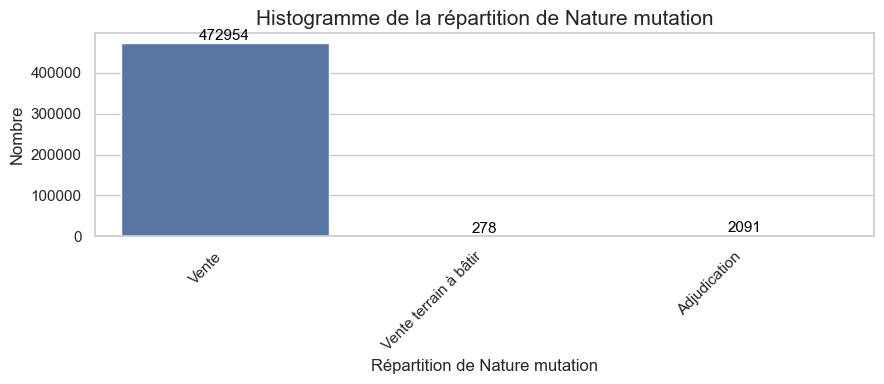

None
Colonne Valeur fonciere
count    475323.000000
mean     202396.506392
std      144599.692479
min       38000.000000
25%       98000.000000
50%      161900.000000
75%      260000.000000
max      595000.000000
Name: Valeur fonciere, dtype: float64


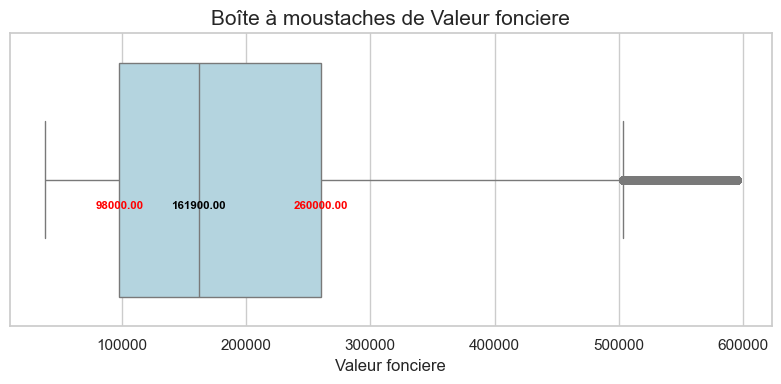

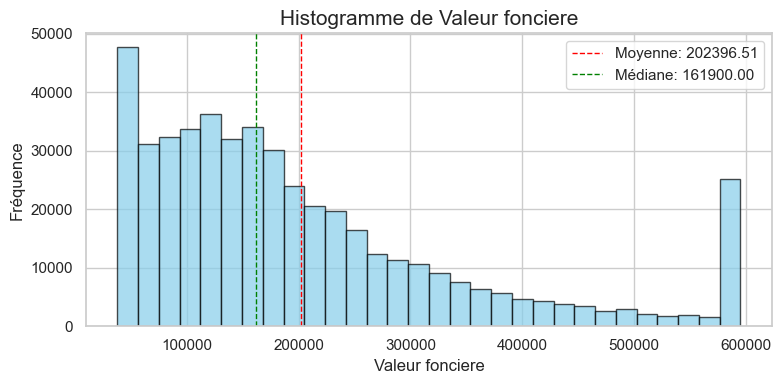

None
Colonne Surface reelle bati
count    475323.000000
mean         82.717876
std          40.776490
min          24.000000
25%          53.000000
50%          77.000000
75%         104.000000
max         180.000000
Name: Surface reelle bati, dtype: float64


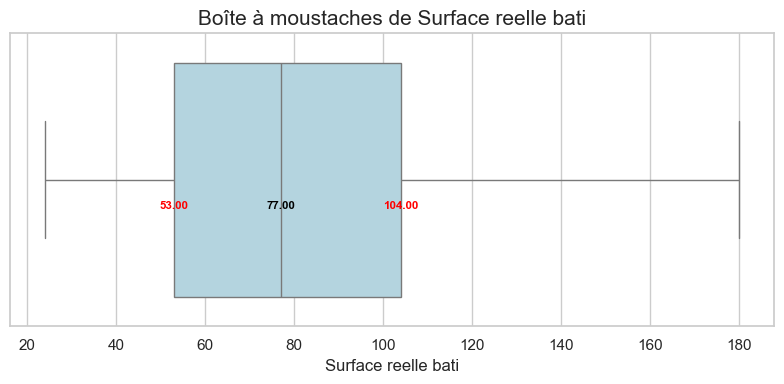

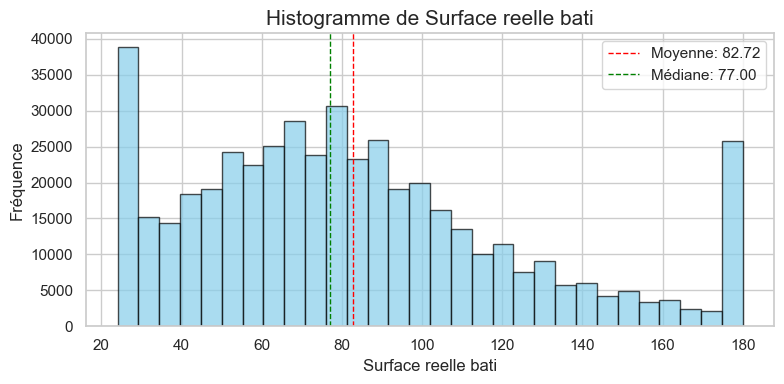

None
Colonne Nombre pieces principales
count    475323.000000
mean          3.277430
std           1.592552
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           6.000000
Name: Nombre pieces principales, dtype: float64


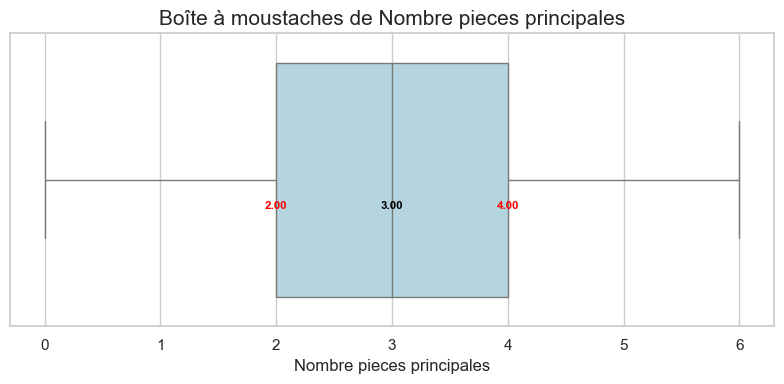

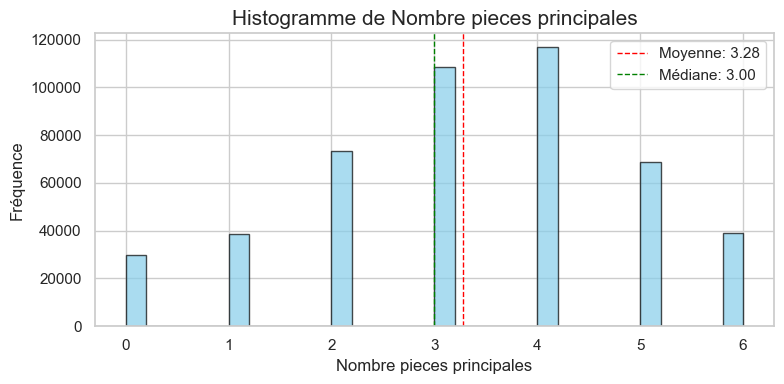

None
Colonne Type local
count     475323
unique         6
top       Maison
freq      225497
Name: Type local, dtype: object


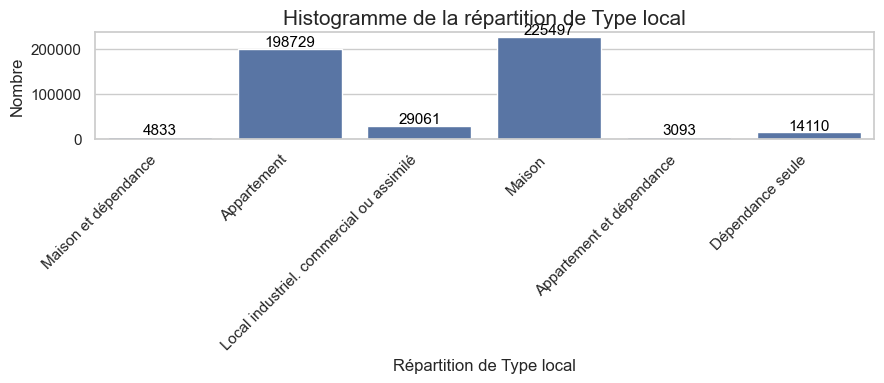

None
Colonne Surface terrain
count    475323.000000
mean        371.039874
std         522.177358
min           0.000000
25%           0.000000
50%         100.000000
75%         584.000000
max        1886.000000
Name: Surface terrain, dtype: float64


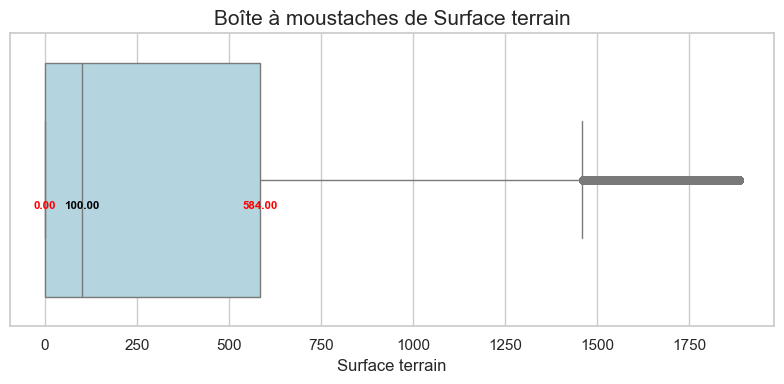

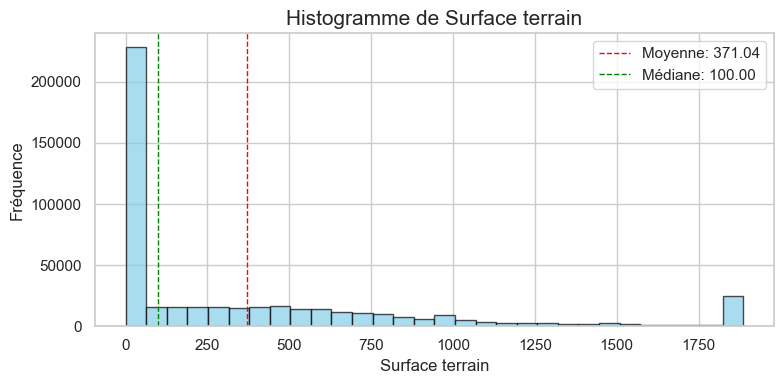

None

--------------------------------------------------

Statistiques du DataFrame data_2019_s1: 

Colonne Nature mutation
count     927786
unique         3
top        Vente
freq      923239
Name: Nature mutation, dtype: object


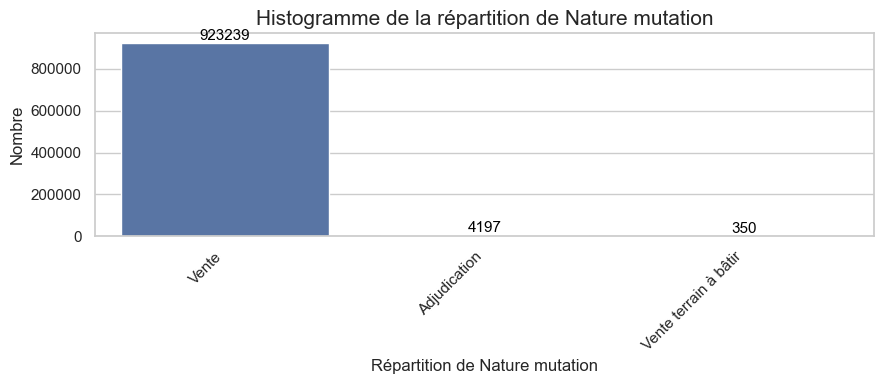

None
Colonne Valeur fonciere
count    927786.000000
mean     202064.049412
std      145059.242627
min       38000.000000
25%       98000.000000
50%      160000.000000
75%      260000.000000
max      597900.000000
Name: Valeur fonciere, dtype: float64


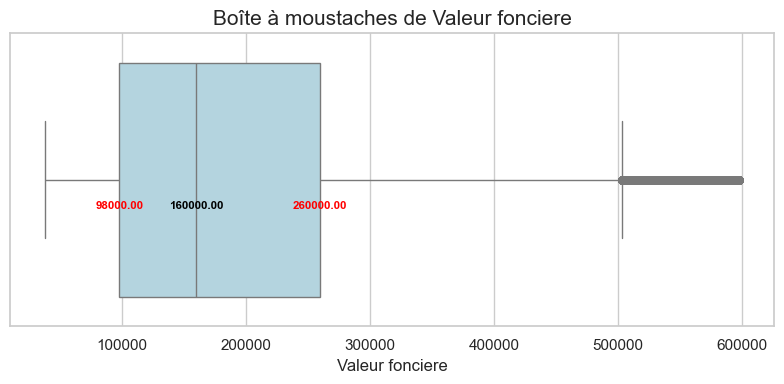

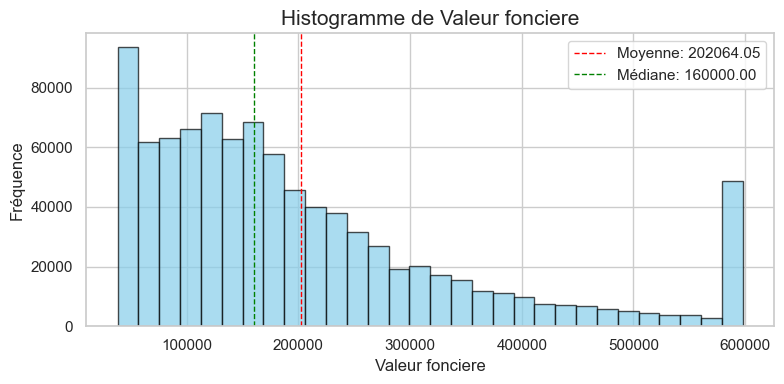

None
Colonne Surface reelle bati
count    927786.000000
mean         81.797836
std          40.275541
min          24.000000
25%          52.000000
50%          76.000000
75%         103.000000
max         178.000000
Name: Surface reelle bati, dtype: float64


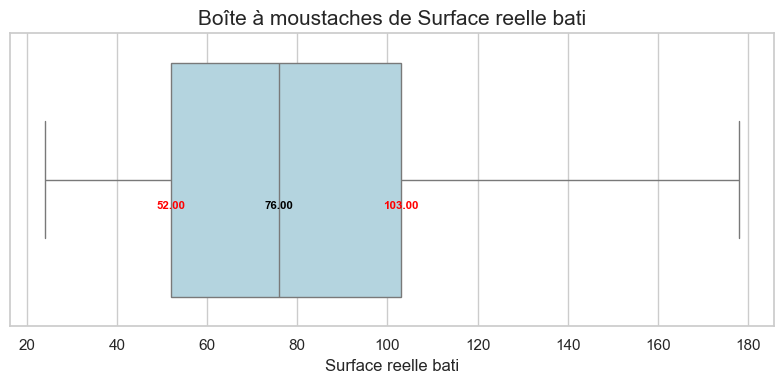

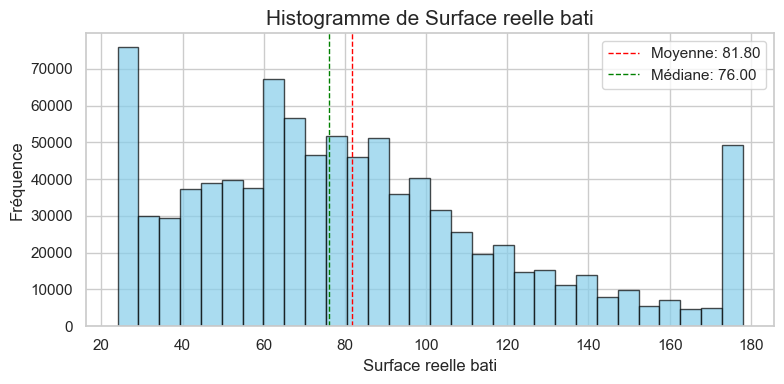

None
Colonne Nombre pieces principales
count    927786.000000
mean          3.253426
std           1.580267
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           6.000000
Name: Nombre pieces principales, dtype: float64


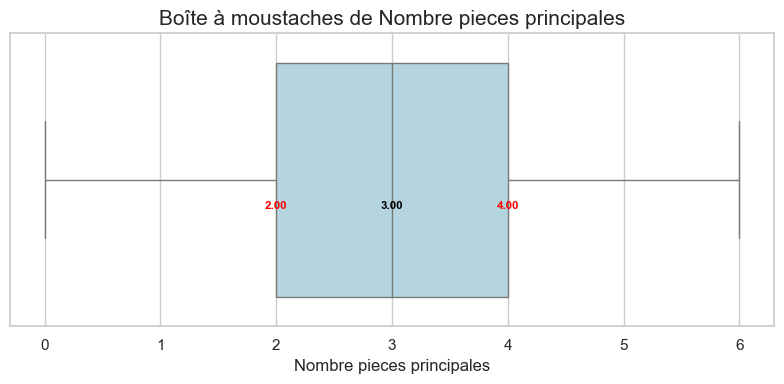

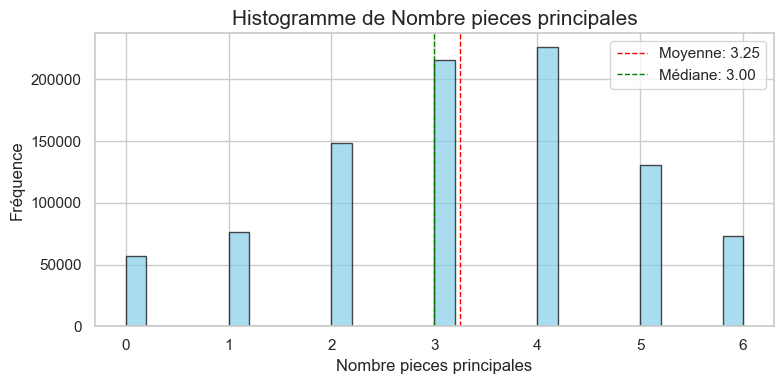

None
Colonne Type local
count     927786
unique         6
top       Maison
freq      428064
Name: Type local, dtype: object


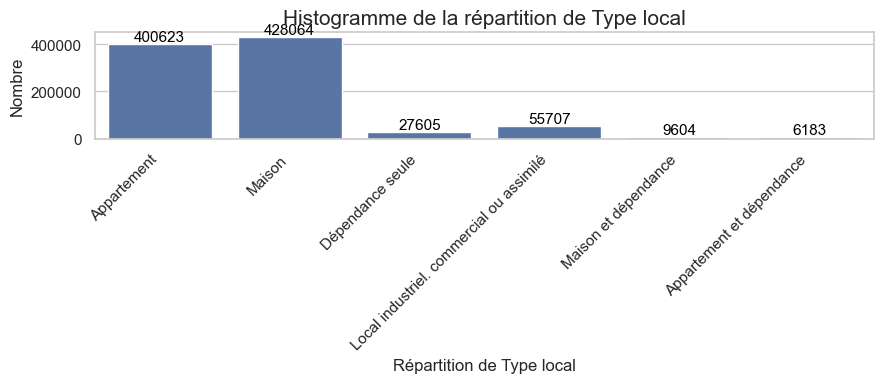

None
Colonne Surface terrain
count    927786.000000
mean        355.798574
std         509.800035
min           0.000000
25%           0.000000
50%          75.000000
75%         560.000000
max        1840.000000
Name: Surface terrain, dtype: float64


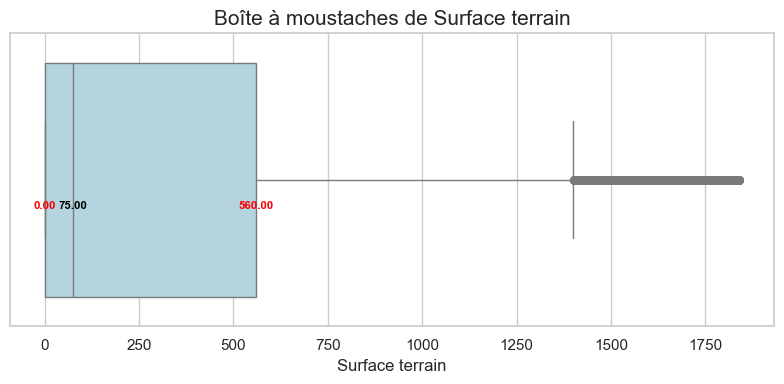

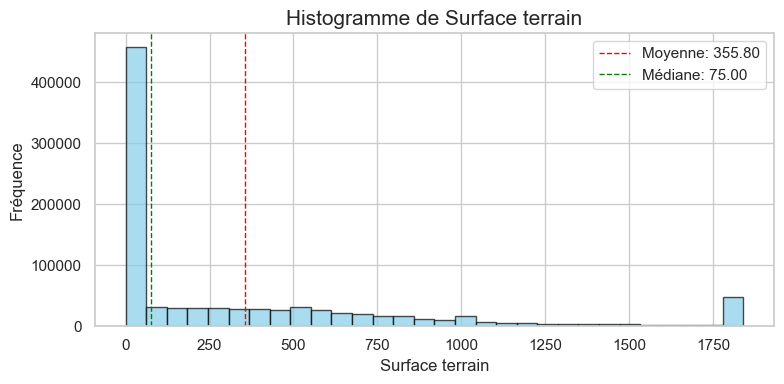

None

--------------------------------------------------

Statistiques du DataFrame data_2019_s2: 

Colonne Nature mutation
count     966113
unique         3
top        Vente
freq      961535
Name: Nature mutation, dtype: object


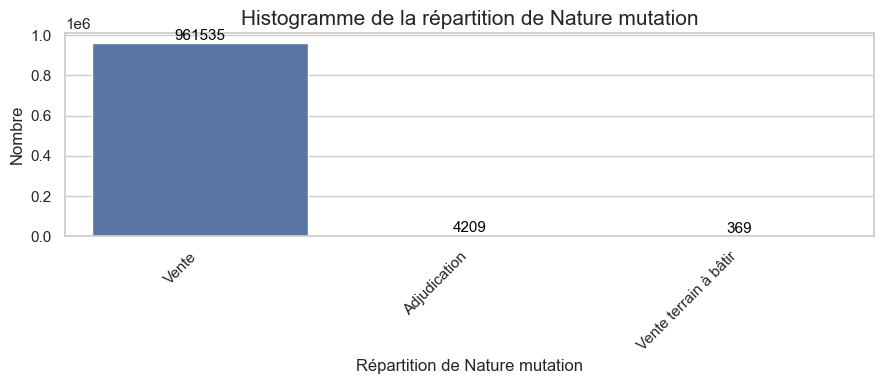

None
Colonne Valeur fonciere
count    966113.000000
mean     202502.877426
std      145345.675194
min       38000.000000
25%       98000.000000
50%      161000.000000
75%      260000.000000
max      597900.000000
Name: Valeur fonciere, dtype: float64


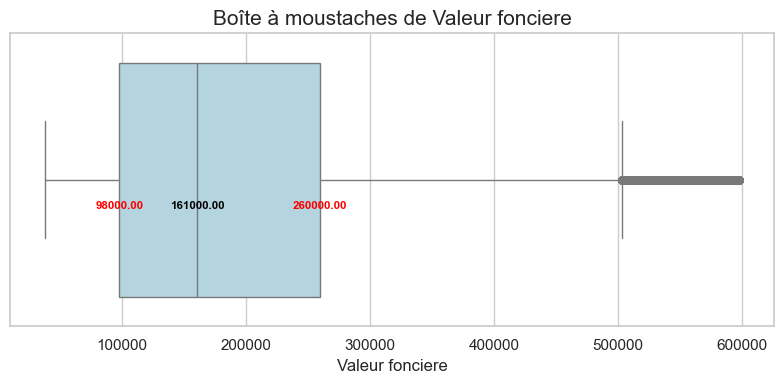

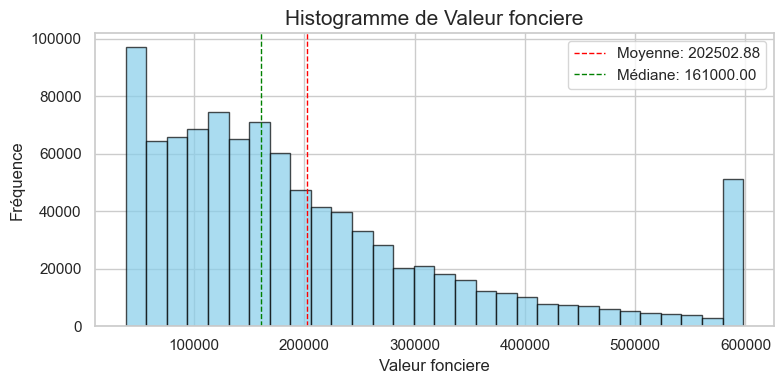

None
Colonne Surface reelle bati
count    966113.000000
mean         81.879486
std          40.328911
min          24.000000
25%          52.000000
50%          76.000000
75%         103.000000
max         178.000000
Name: Surface reelle bati, dtype: float64


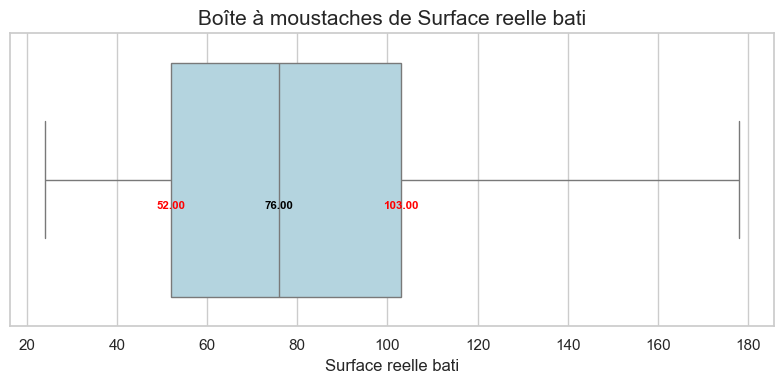

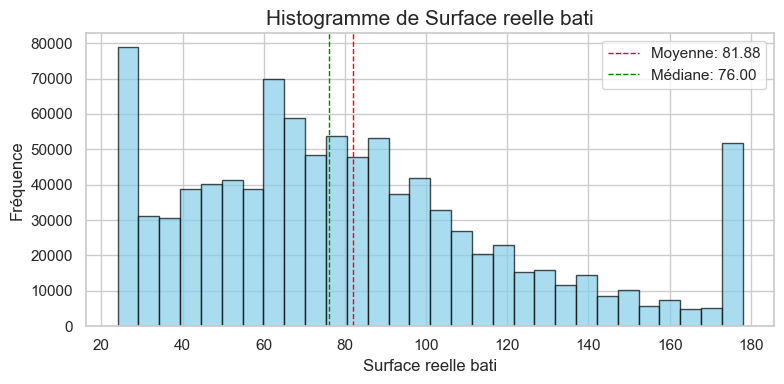

None
Colonne Nombre pieces principales
count    966113.000000
mean          3.253624
std           1.581757
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           6.000000
Name: Nombre pieces principales, dtype: float64


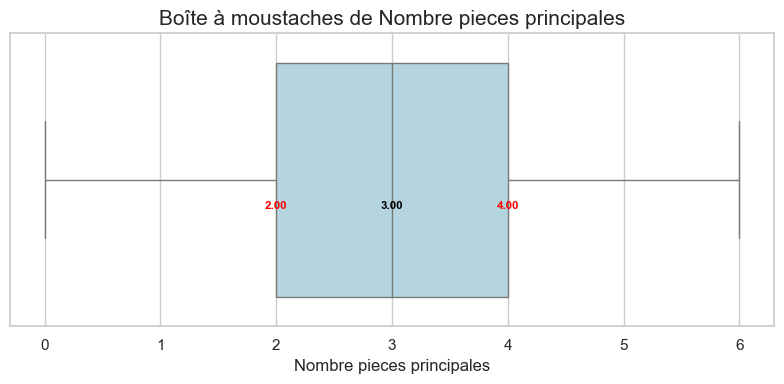

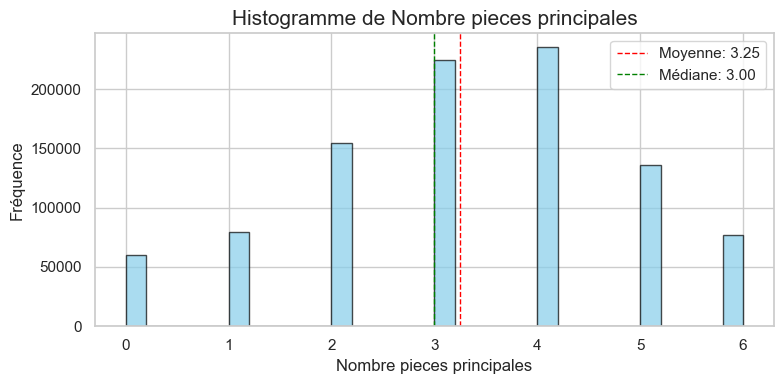

None
Colonne Type local
count     966113
unique         6
top       Maison
freq      445750
Name: Type local, dtype: object


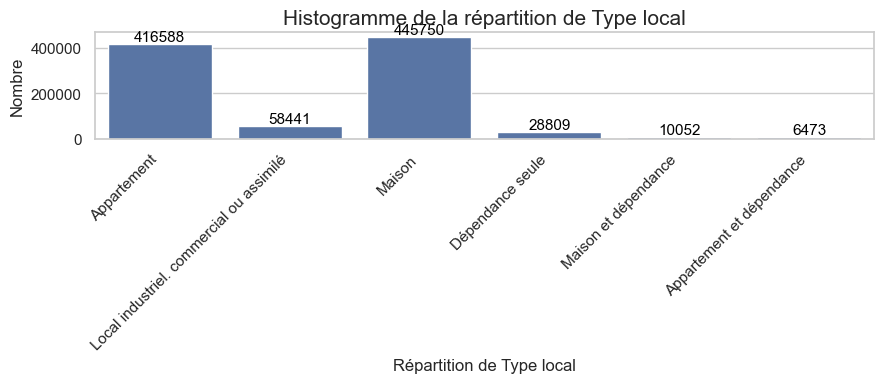

None
Colonne Surface terrain
count    966113.000000
mean        356.747705
std         510.528854
min           0.000000
25%           0.000000
50%          76.000000
75%         561.000000
max        1840.000000
Name: Surface terrain, dtype: float64


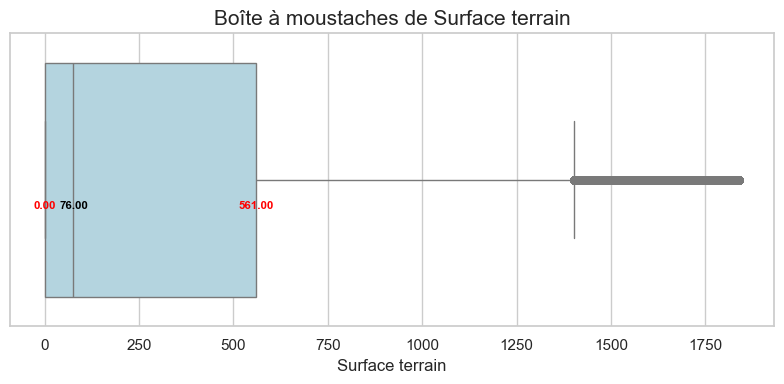

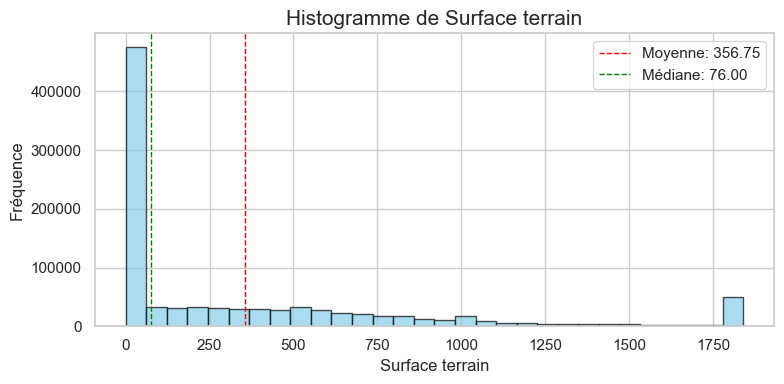

None

--------------------------------------------------

Statistiques du DataFrame data_2020_s1: 

Colonne Nature mutation
count     892003
unique         3
top        Vente
freq      888795
Name: Nature mutation, dtype: object


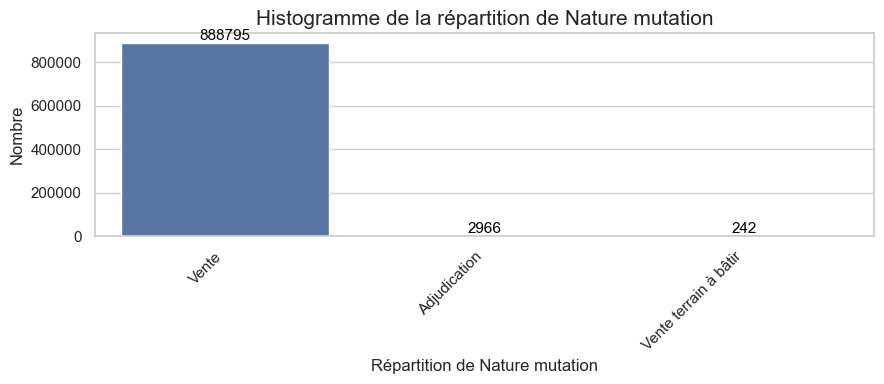

None
Colonne Valeur fonciere
count    892003.000000
mean     207908.359014
std      146285.832584
min       40000.000000
25%      100000.000000
50%      167500.000000
75%      268385.500000
max      600000.000000
Name: Valeur fonciere, dtype: float64


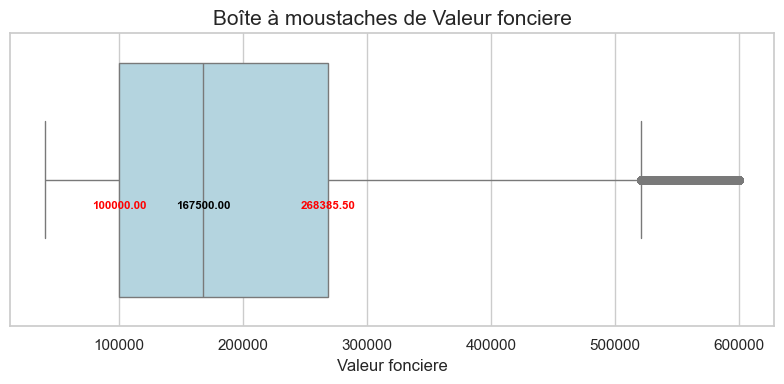

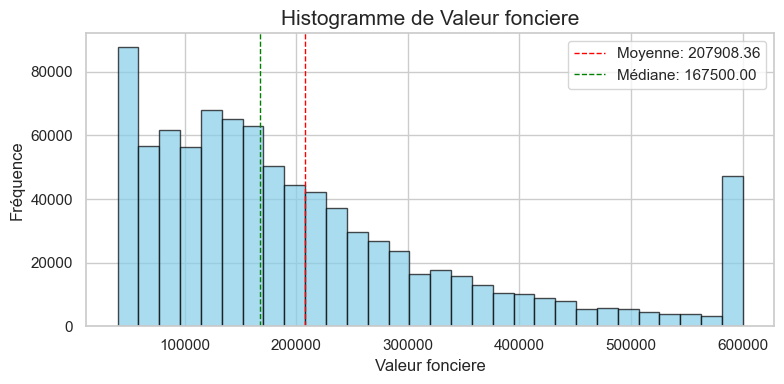

None
Colonne Surface reelle bati
count    892003.000000
mean         82.675525
std          40.527824
min          24.000000
25%          53.000000
50%          77.000000
75%         104.000000
max         180.000000
Name: Surface reelle bati, dtype: float64


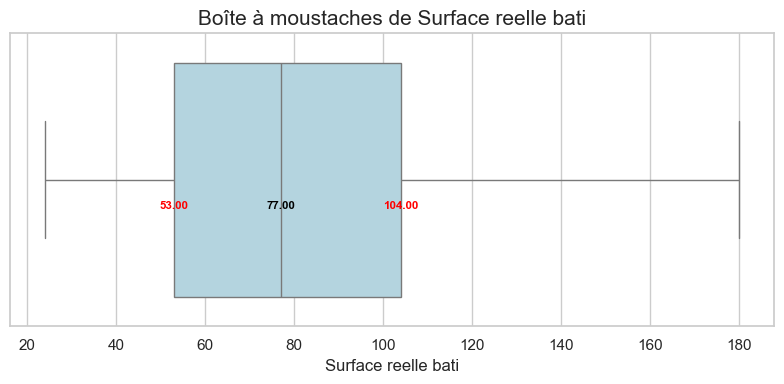

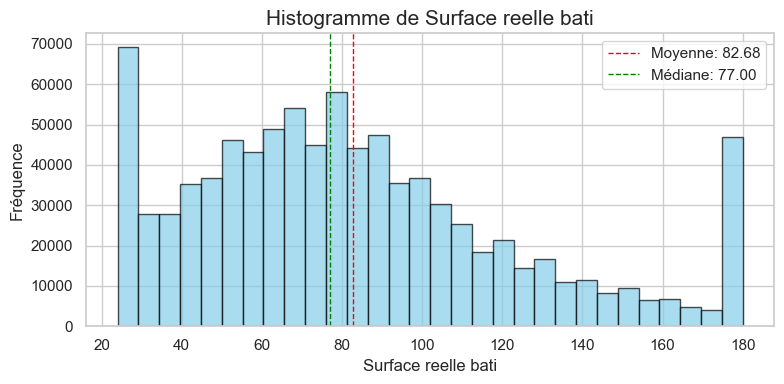

None
Colonne Nombre pieces principales
count    892003.000000
mean          3.296687
std           1.570163
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           6.000000
Name: Nombre pieces principales, dtype: float64


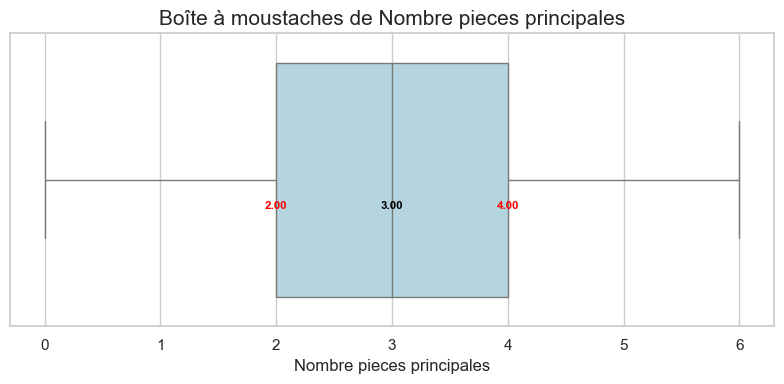

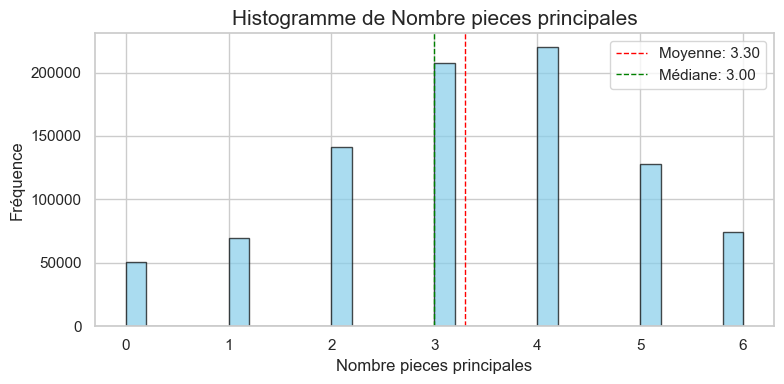

None
Colonne Type local
count     892003
unique         6
top       Maison
freq      405405
Name: Type local, dtype: object


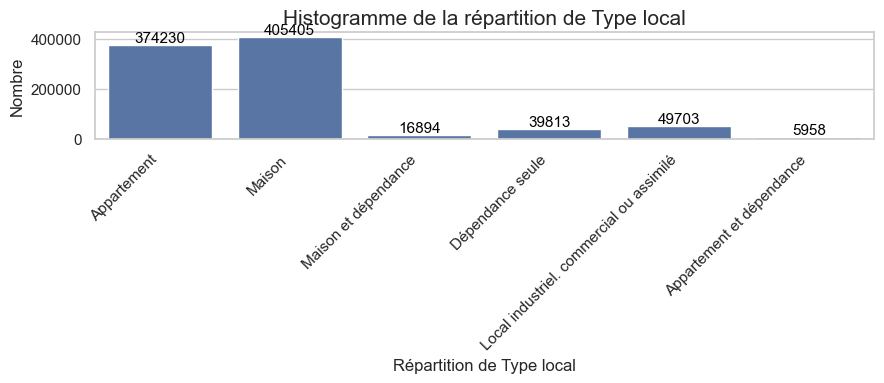

None
Colonne Surface terrain
count    892003.000000
mean        375.290797
std         534.504688
min           0.000000
25%           0.000000
50%         100.000000
75%         582.000000
max        1949.000000
Name: Surface terrain, dtype: float64


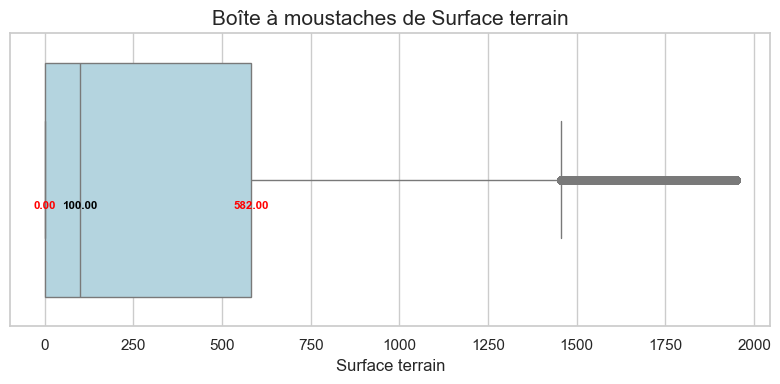

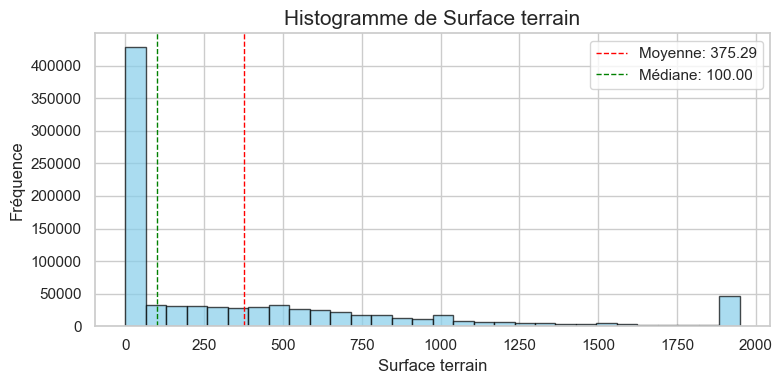

None

--------------------------------------------------

Statistiques du DataFrame data_2020_s2: 

Colonne Nature mutation
count     943057
unique         3
top        Vente
freq      939806
Name: Nature mutation, dtype: object


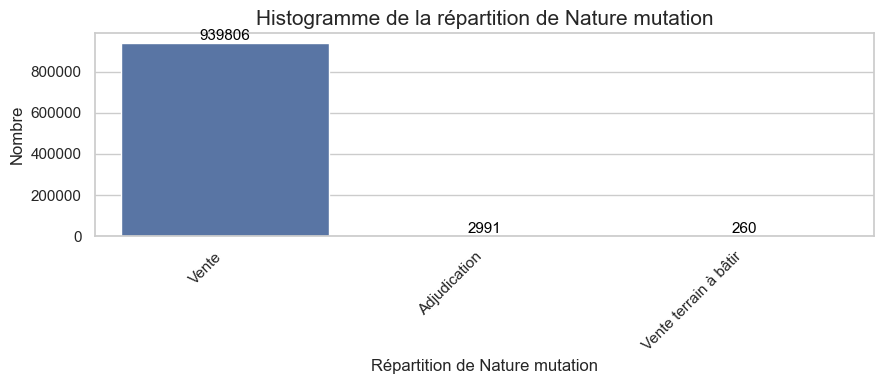

None
Colonne Valeur fonciere
count    943057.000000
mean     208536.530098
std      146750.388737
min       40000.000000
25%      100995.000000
50%      168000.000000
75%      270000.000000
max      600000.000000
Name: Valeur fonciere, dtype: float64


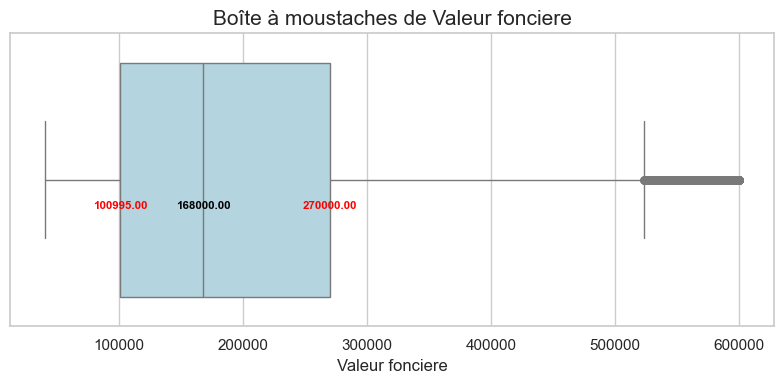

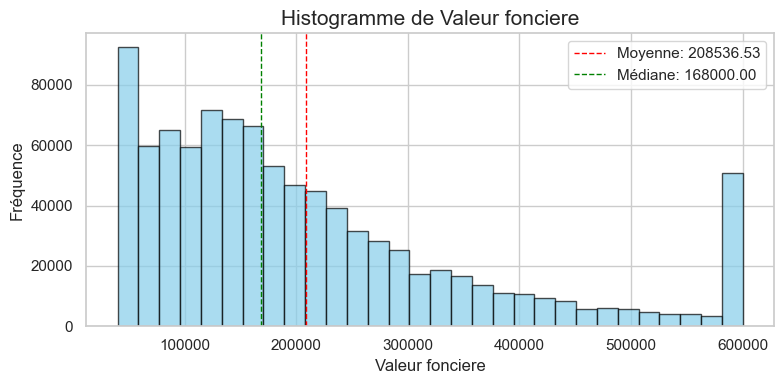

None
Colonne Surface reelle bati
count    943057.000000
mean         82.797794
std          40.627025
min          24.000000
25%          53.000000
50%          77.000000
75%         104.000000
max         180.000000
Name: Surface reelle bati, dtype: float64


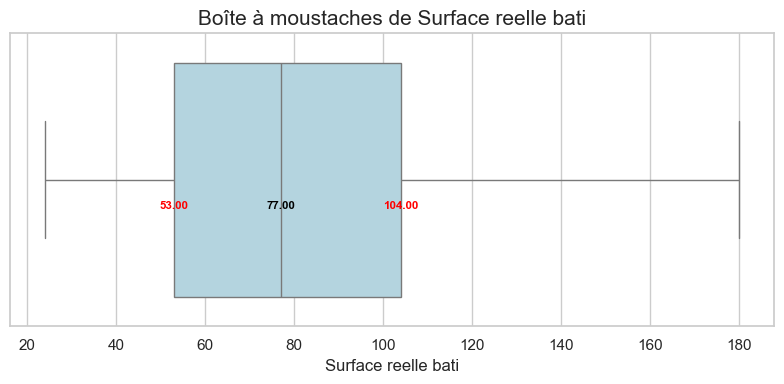

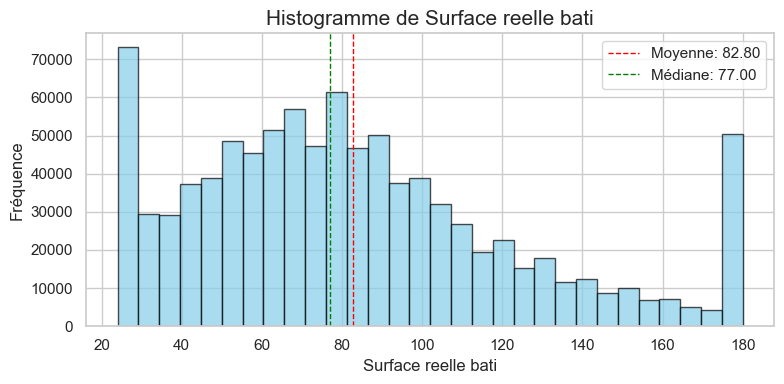

None
Colonne Nombre pieces principales
count    943057.000000
mean          3.295622
std           1.572940
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           6.000000
Name: Nombre pieces principales, dtype: float64


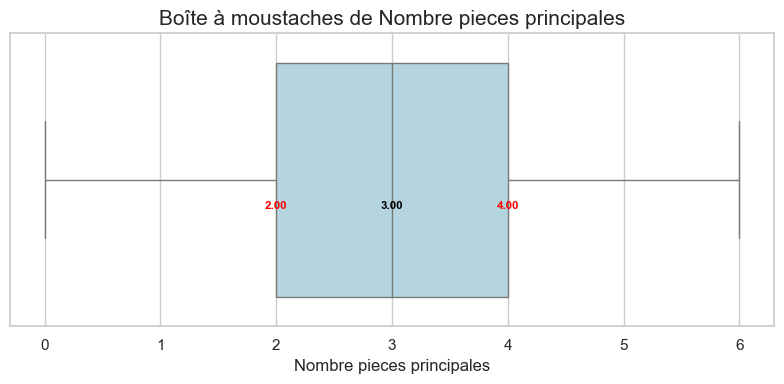

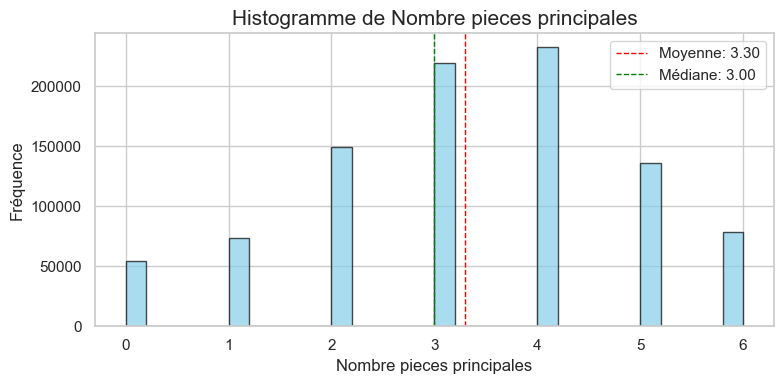

None
Colonne Type local
count     943057
unique         6
top       Maison
freq      427867
Name: Type local, dtype: object


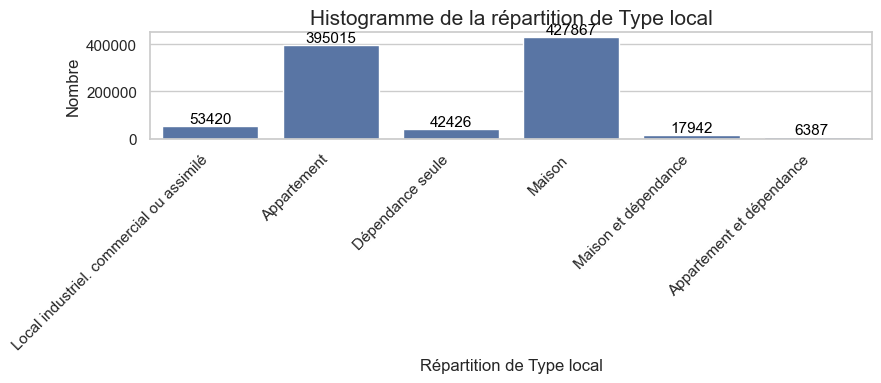

None
Colonne Surface terrain
count    943057.000000
mean        376.345690
std         535.692226
min           0.000000
25%           0.000000
50%         100.000000
75%         584.000000
max        1949.000000
Name: Surface terrain, dtype: float64


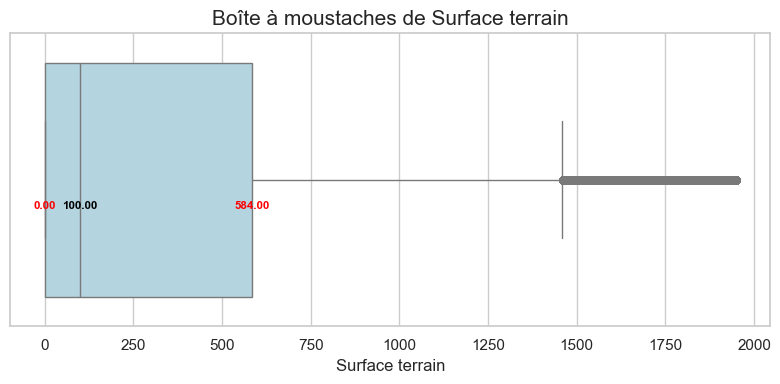

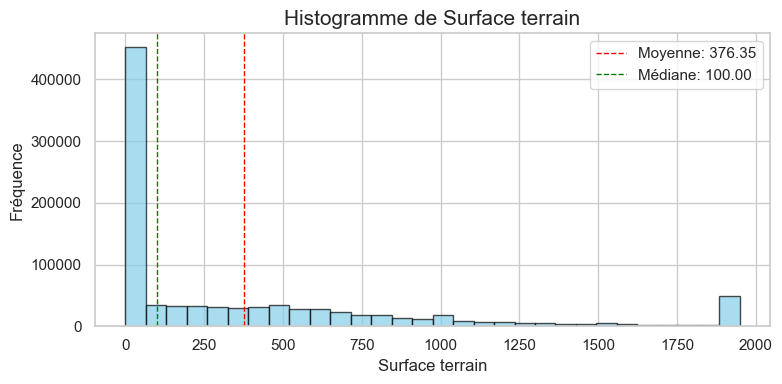

None

--------------------------------------------------

Statistiques du DataFrame data_2021_s1: 

Colonne Nature mutation
count     1072232
unique          3
top         Vente
freq      1068340
Name: Nature mutation, dtype: object


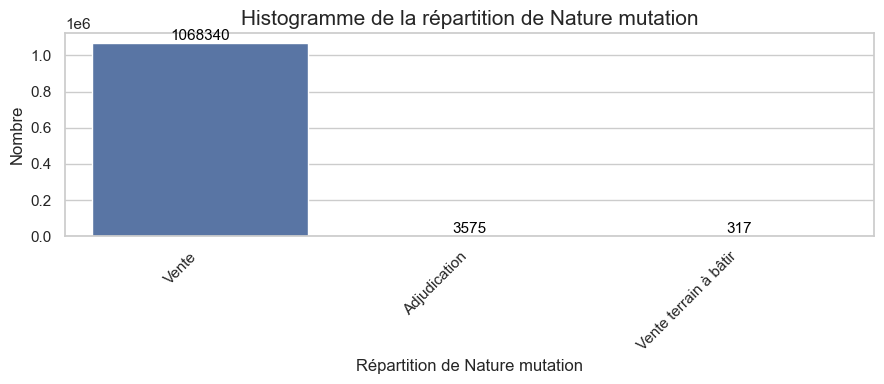

None
Colonne Valeur fonciere
count    1.072232e+06
mean     2.228172e+05
std      1.594786e+05
min      4.000000e+04
25%      1.080000e+05
50%      1.778000e+05
75%      2.893500e+05
max      6.500000e+05
Name: Valeur fonciere, dtype: float64


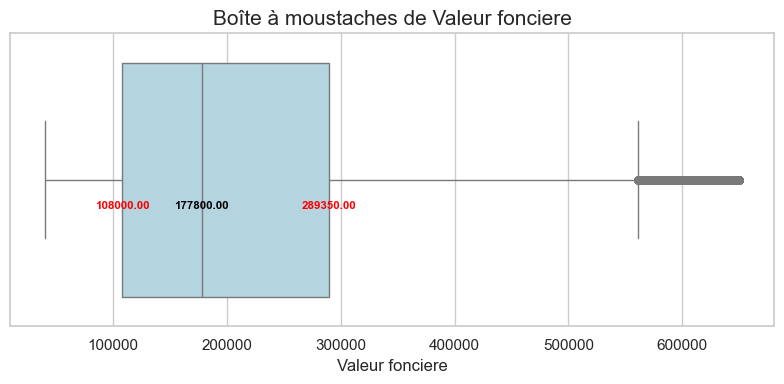

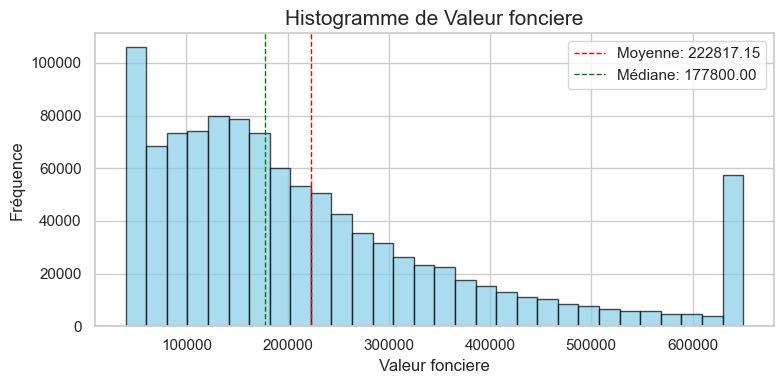

None
Colonne Surface reelle bati
count    1.072232e+06
mean     8.388352e+01
std      4.168932e+01
min      2.400000e+01
25%      5.300000e+01
50%      7.800000e+01
75%      1.060000e+02
max      1.840000e+02
Name: Surface reelle bati, dtype: float64


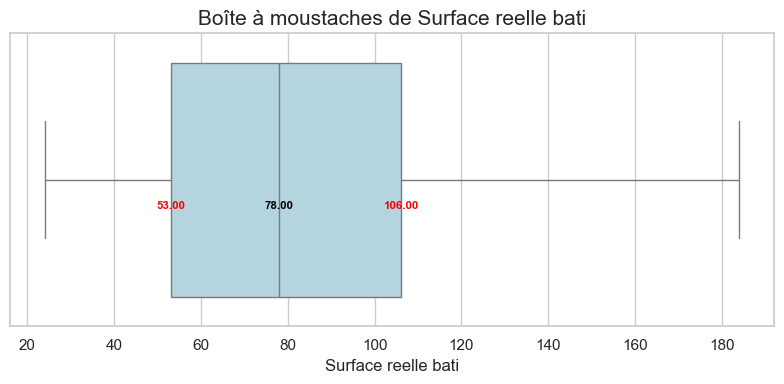

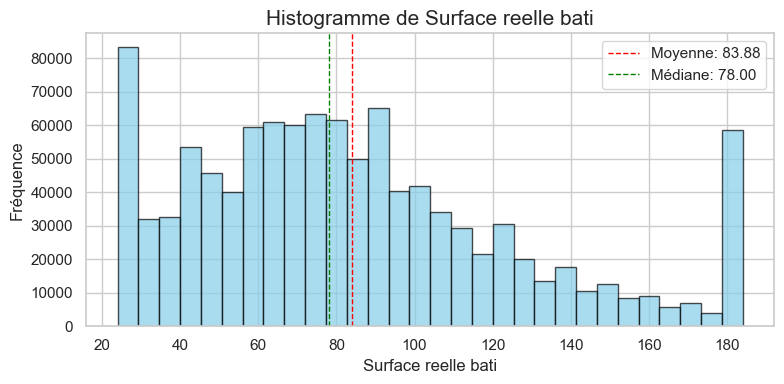

None
Colonne Nombre pieces principales
count    1.072232e+06
mean     3.311426e+00
std      1.580143e+00
min      0.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      6.000000e+00
Name: Nombre pieces principales, dtype: float64


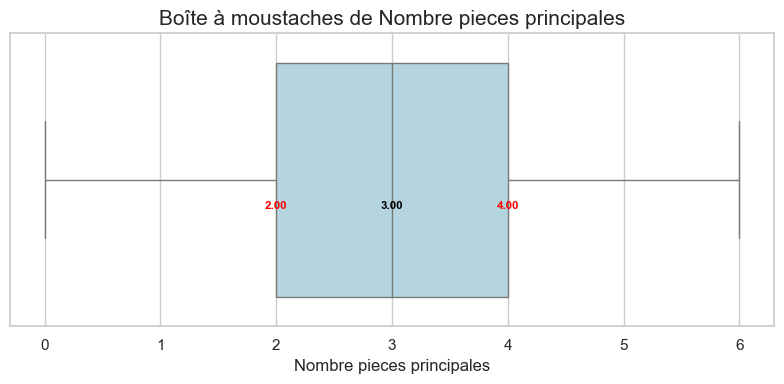

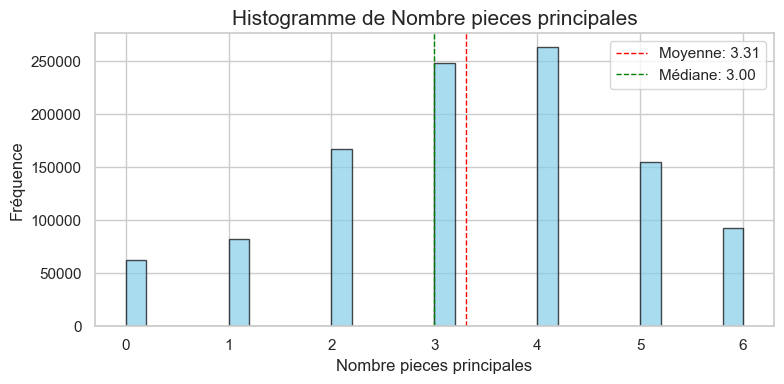

None
Colonne Type local
count         1072232
unique              6
top       Appartement
freq           430074
Name: Type local, dtype: object


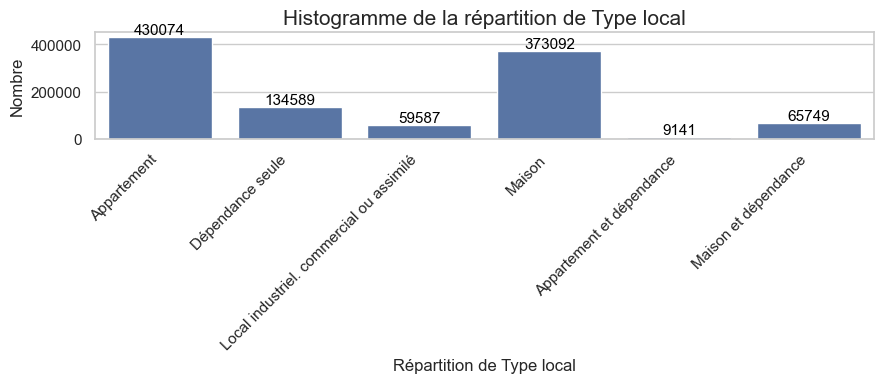

None
Colonne Surface terrain
count    1.072232e+06
mean     4.098841e+02
std      5.915040e+02
min      0.000000e+00
25%      0.000000e+00
50%      1.240000e+02
75%      6.070000e+02
max      2.185000e+03
Name: Surface terrain, dtype: float64


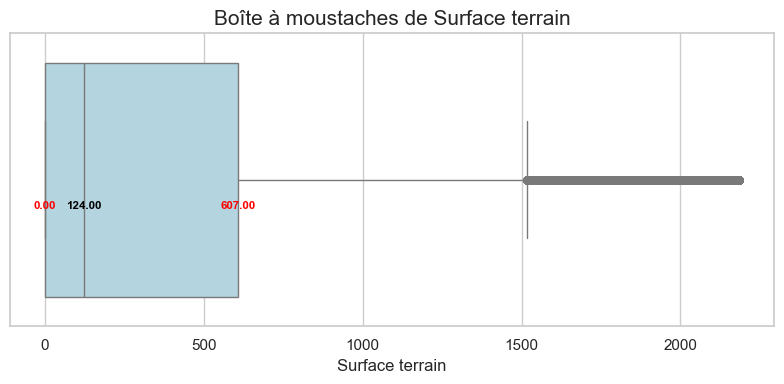

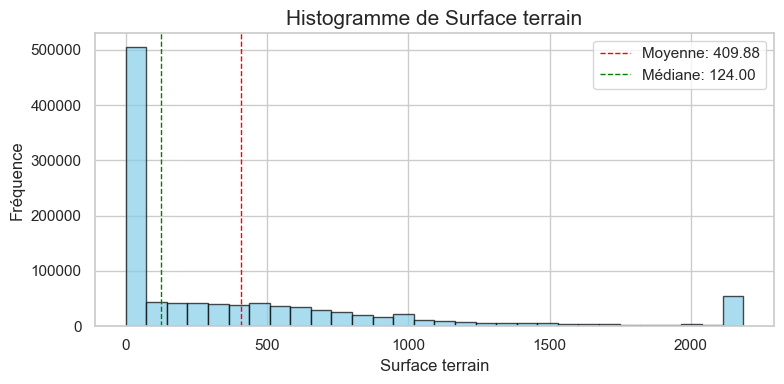

None

--------------------------------------------------

Statistiques du DataFrame data_2021_s2: 

Colonne Nature mutation
count     1112748
unique          3
top         Vente
freq      1108886
Name: Nature mutation, dtype: object


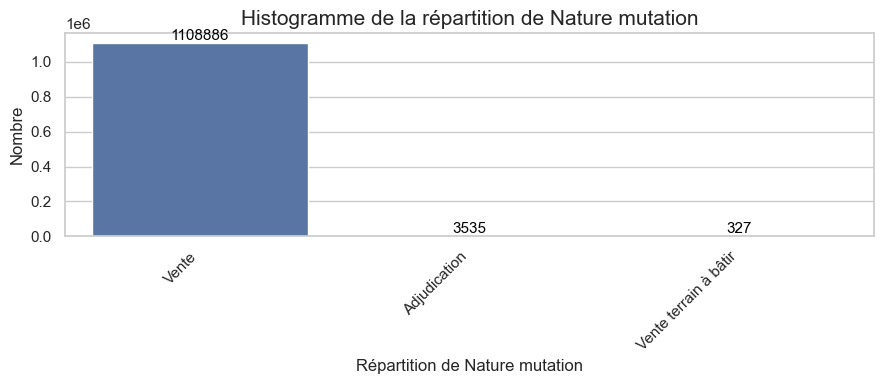

None
Colonne Valeur fonciere
count    1.112748e+06
mean     2.236386e+05
std      1.600310e+05
min      4.000000e+04
25%      1.081000e+05
50%      1.782000e+05
75%      2.900000e+05
max      6.500000e+05
Name: Valeur fonciere, dtype: float64


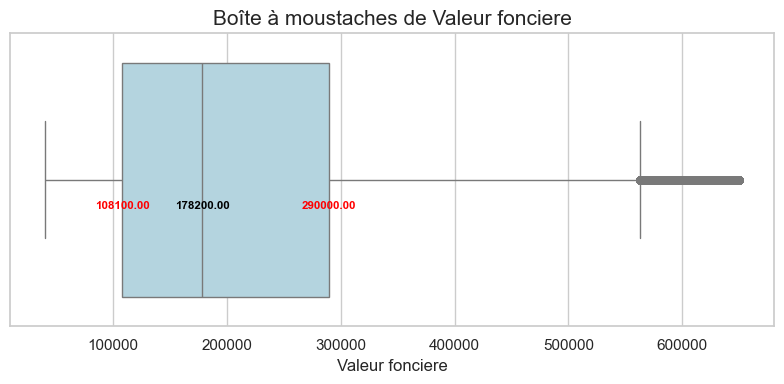

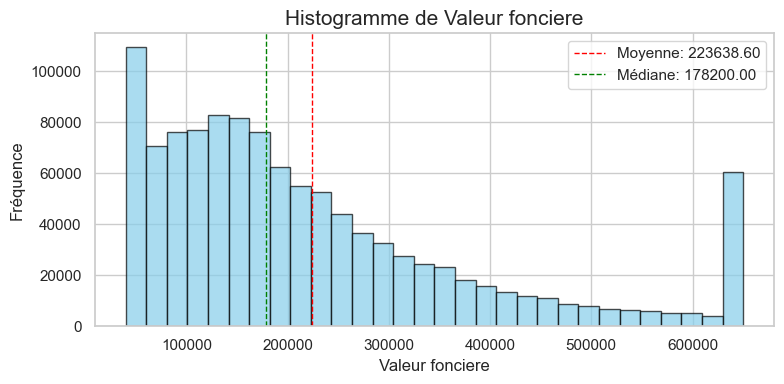

None
Colonne Surface reelle bati
count    1.112748e+06
mean     8.403122e+01
std      4.177107e+01
min      2.400000e+01
25%      5.300000e+01
50%      7.800000e+01
75%      1.060000e+02
max      1.840000e+02
Name: Surface reelle bati, dtype: float64


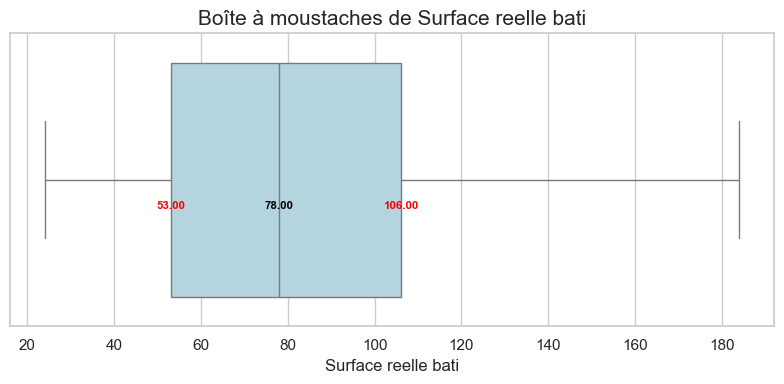

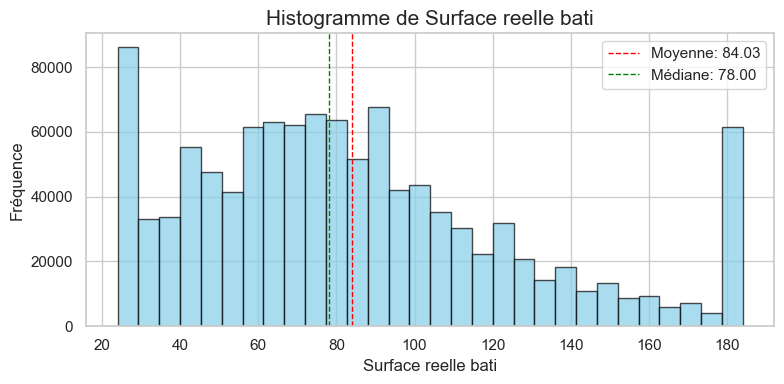

None
Colonne Nombre pieces principales
count    1.112748e+06
mean     3.312536e+00
std      1.582317e+00
min      0.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      6.000000e+00
Name: Nombre pieces principales, dtype: float64


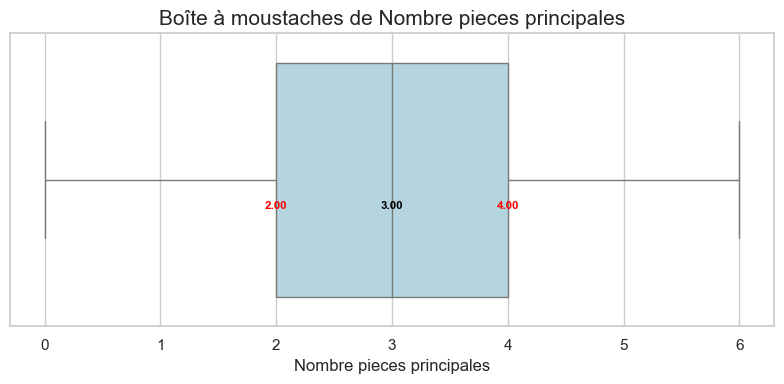

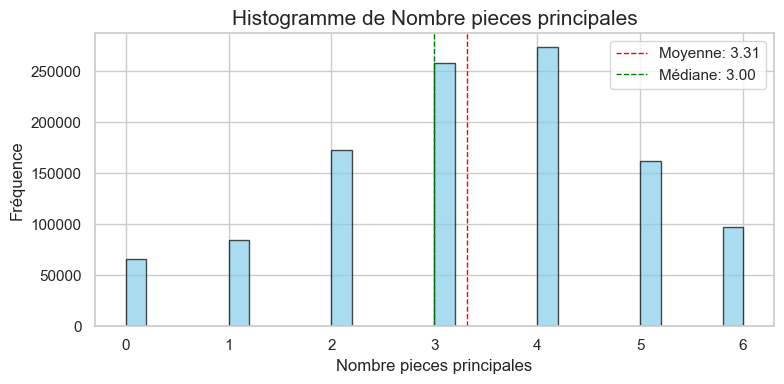

None
Colonne Type local
count         1112748
unique              6
top       Appartement
freq           445159
Name: Type local, dtype: object


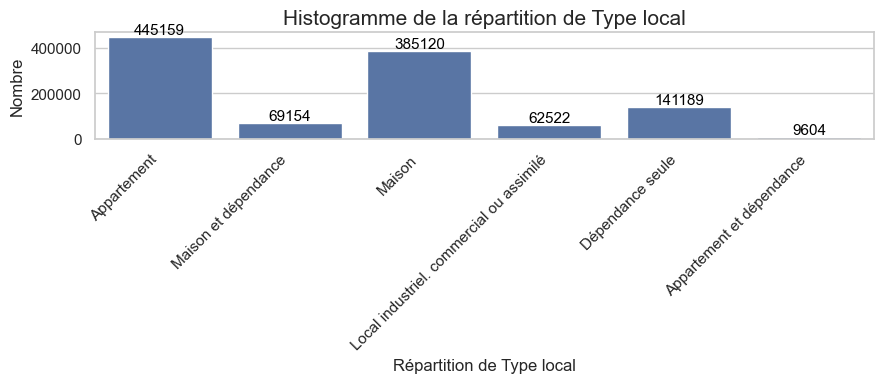

None
Colonne Surface terrain
count    1.112748e+06
mean     4.113773e+02
std      5.927503e+02
min      0.000000e+00
25%      0.000000e+00
50%      1.250000e+02
75%      6.090000e+02
max      2.185000e+03
Name: Surface terrain, dtype: float64


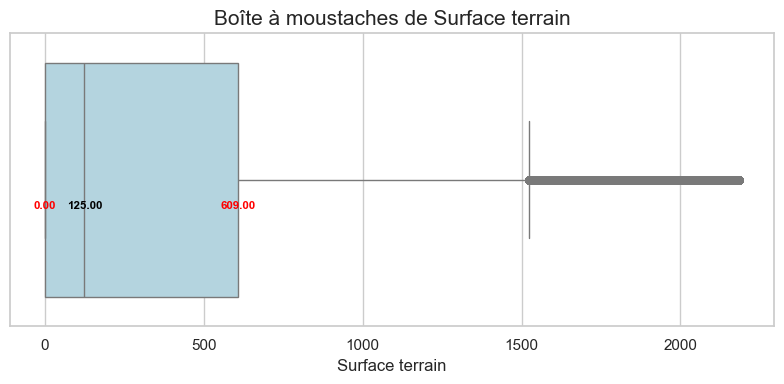

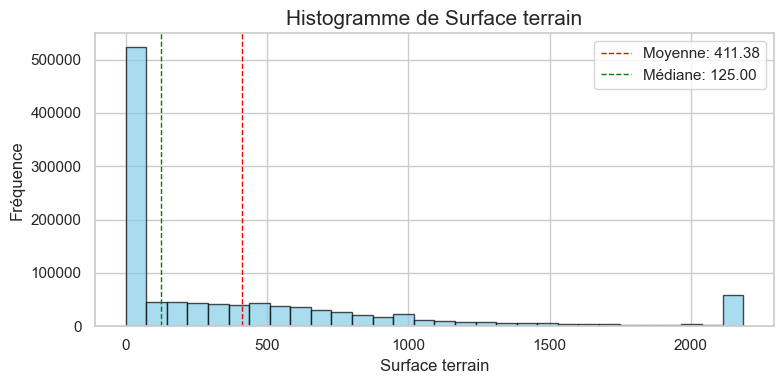

None

--------------------------------------------------

Statistiques du DataFrame data_2022_s1: 

Colonne Nature mutation
count     1029618
unique          3
top         Vente
freq      1026733
Name: Nature mutation, dtype: object


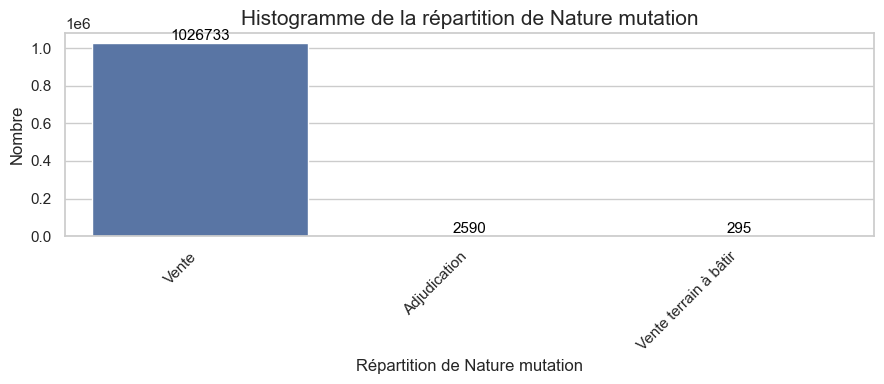

None
Colonne Valeur fonciere
count    1.029618e+06
mean     2.376943e+05
std      1.708913e+05
min      4.500000e+04
25%      1.150000e+05
50%      1.890000e+05
75%      3.070000e+05
max      7.000000e+05
Name: Valeur fonciere, dtype: float64


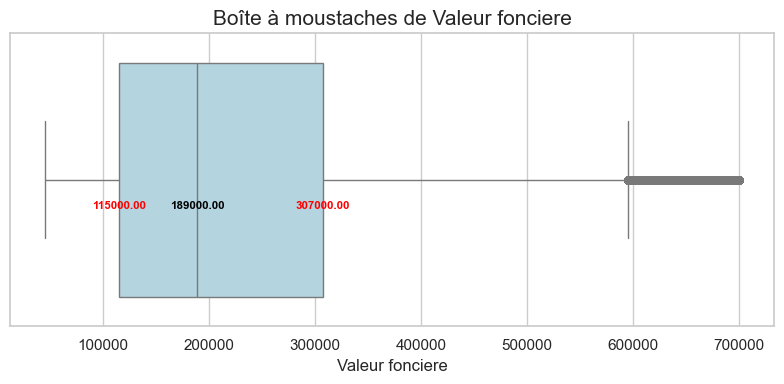

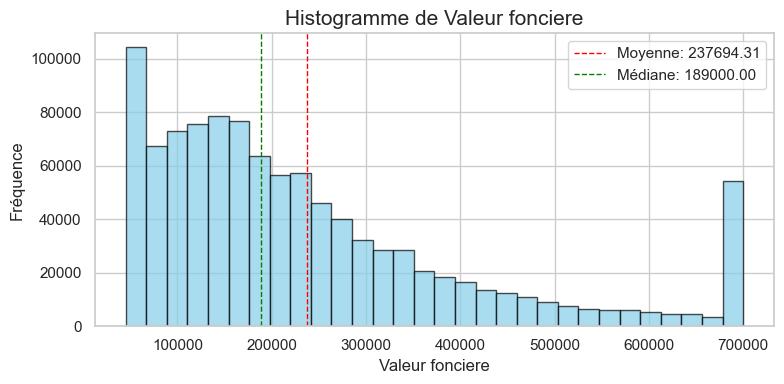

None
Colonne Surface reelle bati
count    1.029618e+06
mean     8.242613e+01
std      4.099469e+01
min      2.400000e+01
25%      5.200000e+01
50%      7.600000e+01
75%      1.040000e+02
max      1.800000e+02
Name: Surface reelle bati, dtype: float64


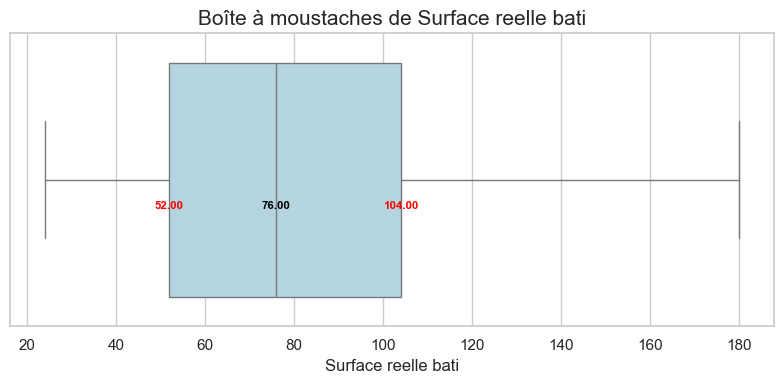

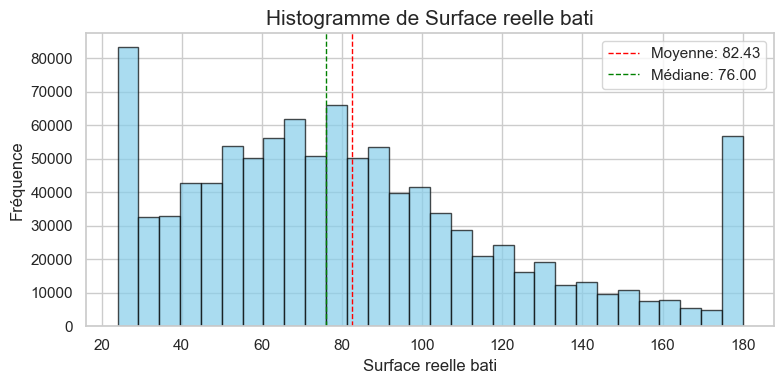

None
Colonne Nombre pieces principales
count    1.029618e+06
mean     3.258893e+00
std      1.577725e+00
min      0.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      6.000000e+00
Name: Nombre pieces principales, dtype: float64


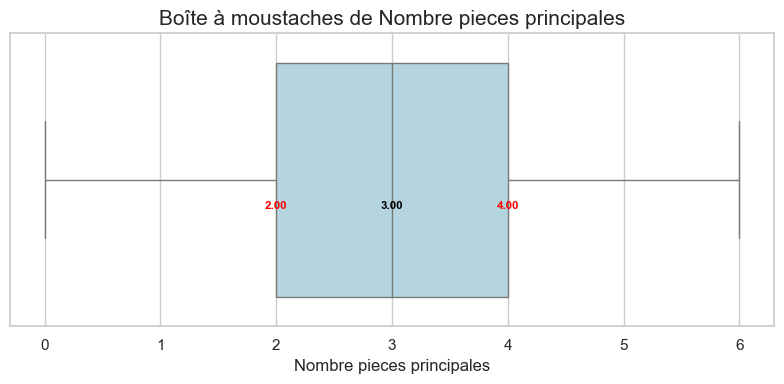

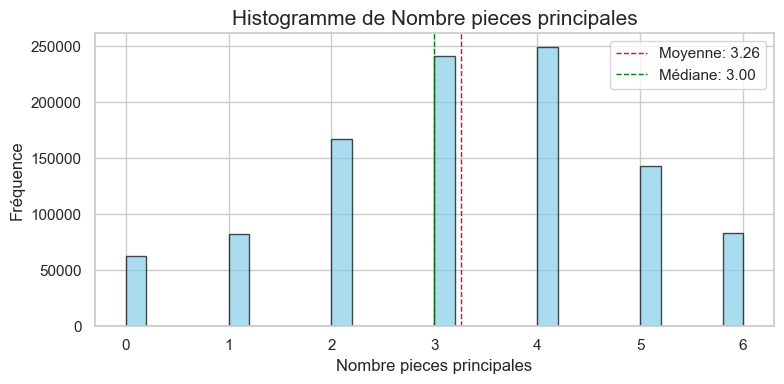

None
Colonne Type local
count         1029618
unique              6
top       Appartement
freq           425403
Name: Type local, dtype: object


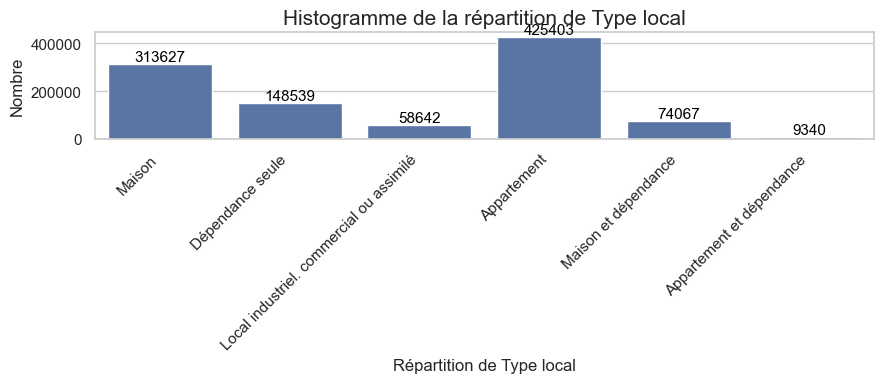

None
Colonne Surface terrain
count    1.029618e+06
mean     3.942052e+02
std      5.778854e+02
min      0.000000e+00
25%      0.000000e+00
50%      9.900000e+01
75%      5.900000e+02
max      2.128000e+03
Name: Surface terrain, dtype: float64


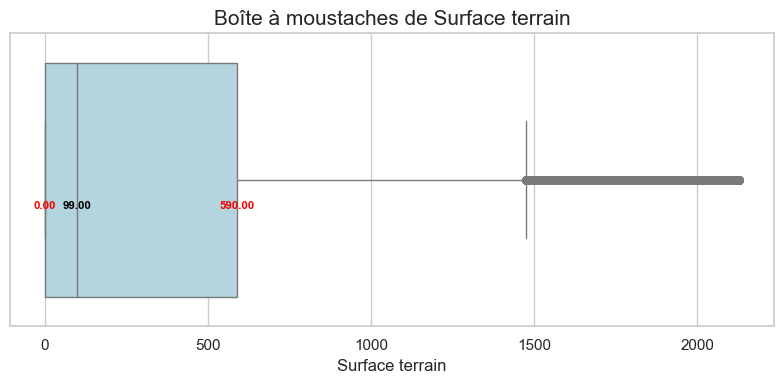

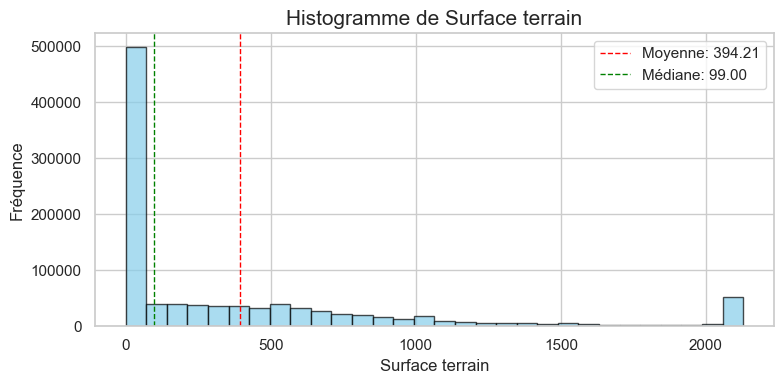

None

--------------------------------------------------

Statistiques du DataFrame data_2022_s2: 

Colonne Nature mutation
count     1063851
unique          3
top         Vente
freq      1060976
Name: Nature mutation, dtype: object


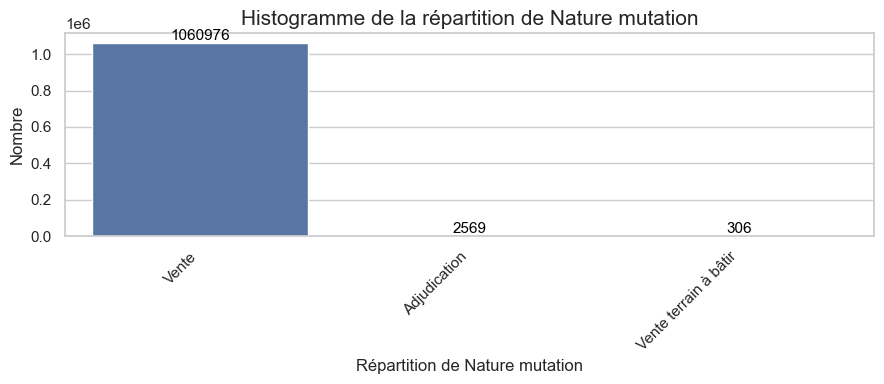

None
Colonne Valeur fonciere
count    1.063851e+06
mean     2.383156e+05
std      1.713543e+05
min      4.500000e+04
25%      1.150000e+05
50%      1.890000e+05
75%      3.081300e+05
max      7.000000e+05
Name: Valeur fonciere, dtype: float64


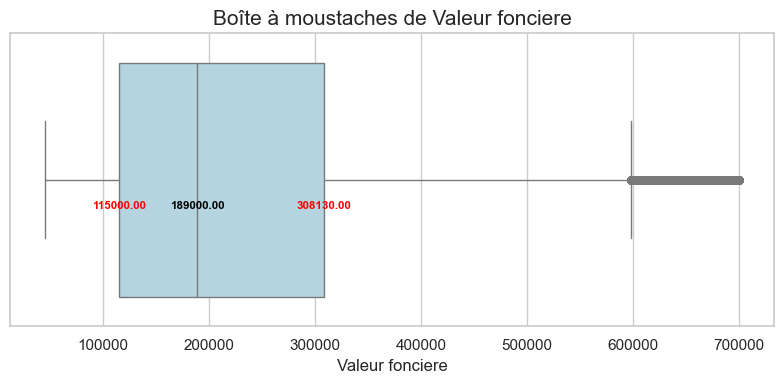

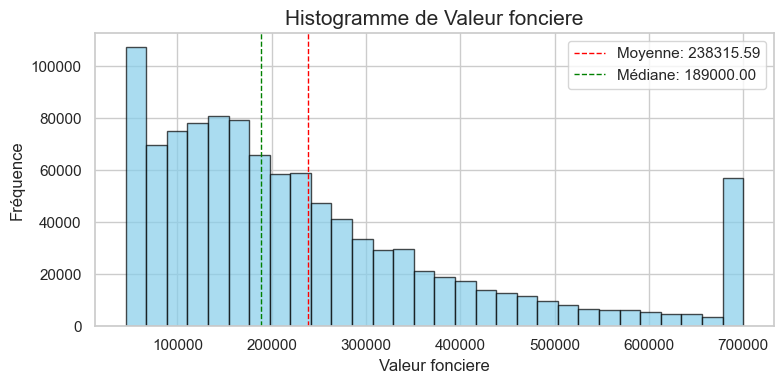

None
Colonne Surface reelle bati
count    1.063851e+06
mean     8.253142e+01
std      4.105258e+01
min      2.400000e+01
25%      5.200000e+01
50%      7.600000e+01
75%      1.040000e+02
max      1.800000e+02
Name: Surface reelle bati, dtype: float64


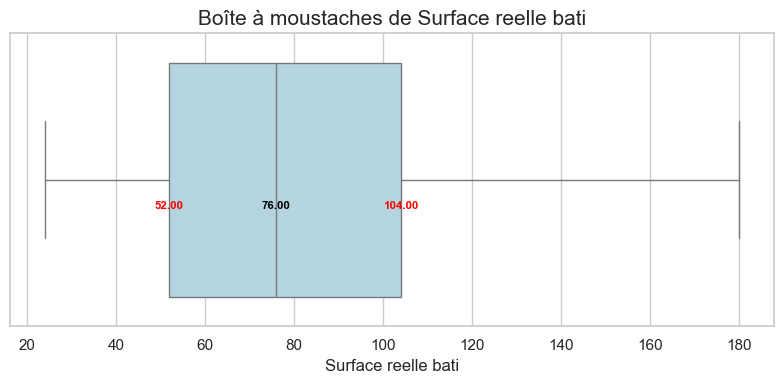

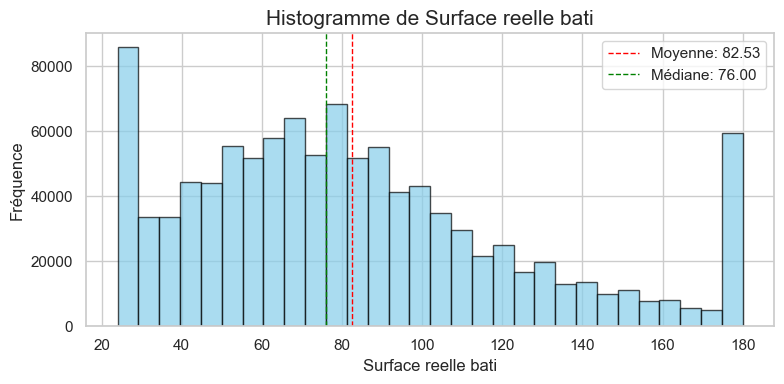

None
Colonne Nombre pieces principales
count    1.063851e+06
mean     3.259026e+00
std      1.579371e+00
min      0.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      6.000000e+00
Name: Nombre pieces principales, dtype: float64


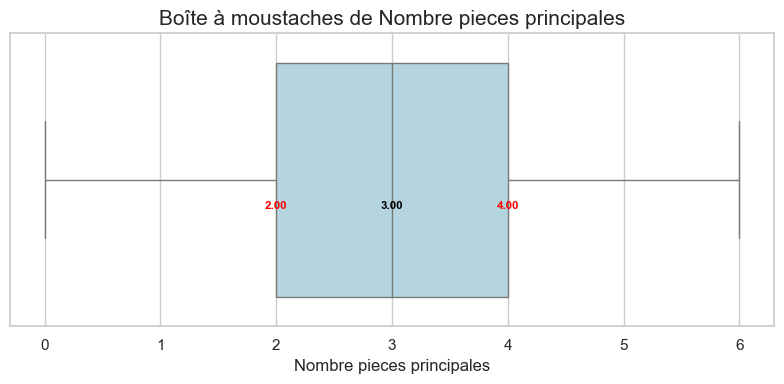

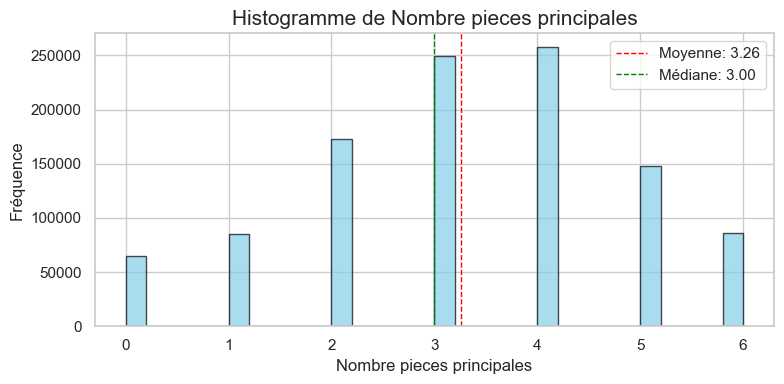

None
Colonne Type local
count         1063851
unique              6
top       Appartement
freq           438811
Name: Type local, dtype: object


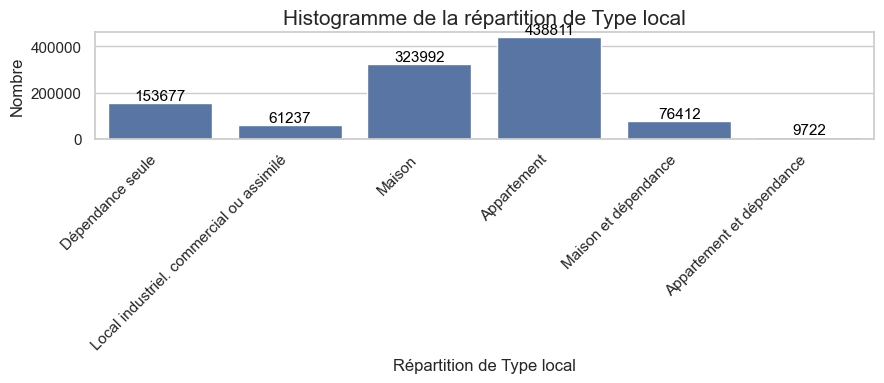

None
Colonne Surface terrain
count    1.063851e+06
mean     3.951572e+02
std      5.787662e+02
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+02
75%      5.910000e+02
max      2.128000e+03
Name: Surface terrain, dtype: float64


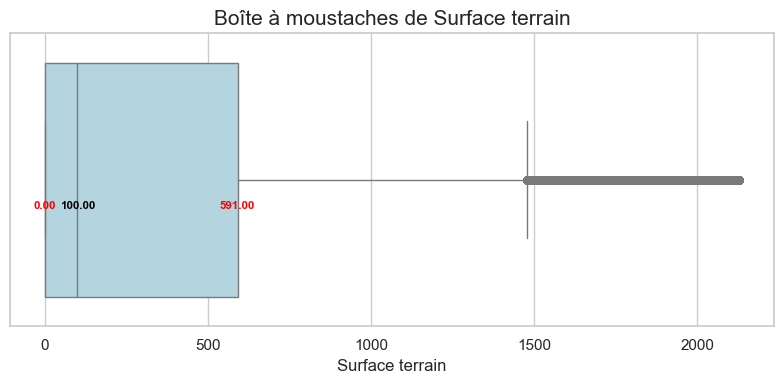

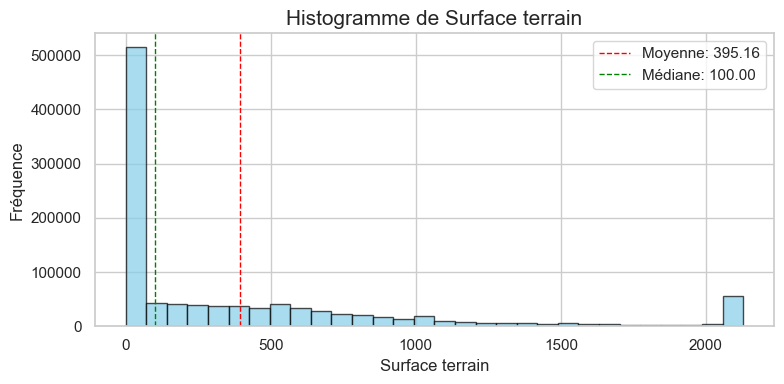

None

--------------------------------------------------

Statistiques du DataFrame data_2023_s1: 

Colonne Nature mutation
count     812363
unique         3
top        Vente
freq      810494
Name: Nature mutation, dtype: object


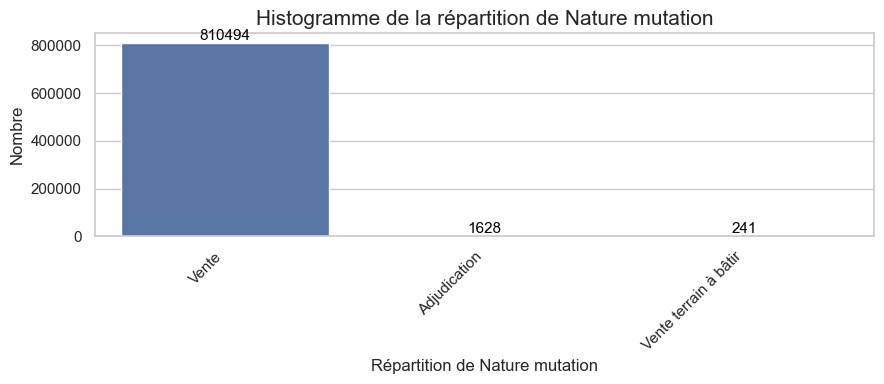

None
Colonne Valeur fonciere
count    812363.000000
mean     230329.935963
std      165938.544667
min       40000.000000
25%      110000.000000
50%      183000.000000
75%      298800.000000
max      679600.000000
Name: Valeur fonciere, dtype: float64


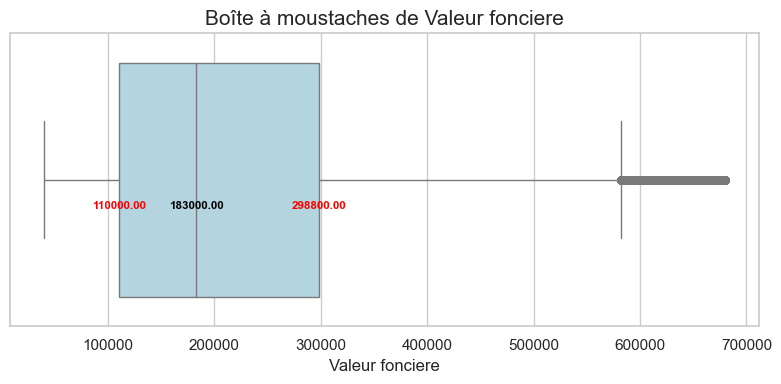

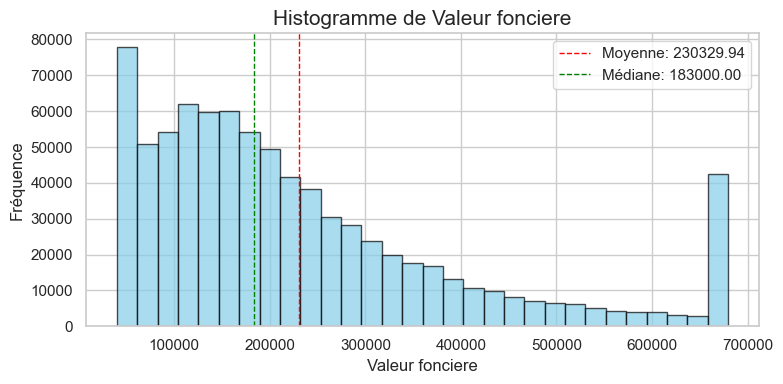

None
Colonne Surface reelle bati
count    812363.000000
mean         80.858592
std          40.964898
min          22.000000
25%          50.000000
50%          75.000000
75%         102.000000
max         180.000000
Name: Surface reelle bati, dtype: float64


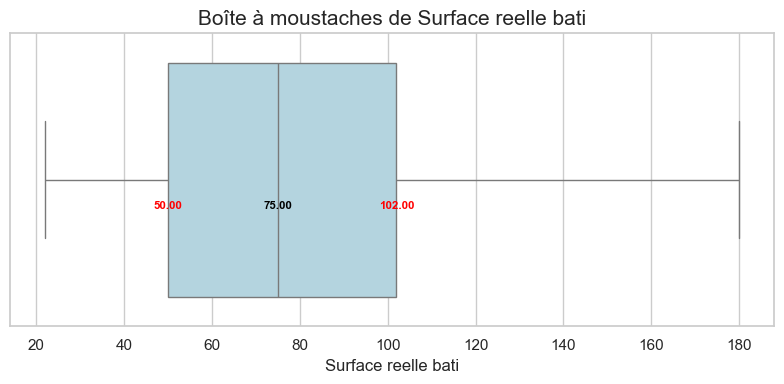

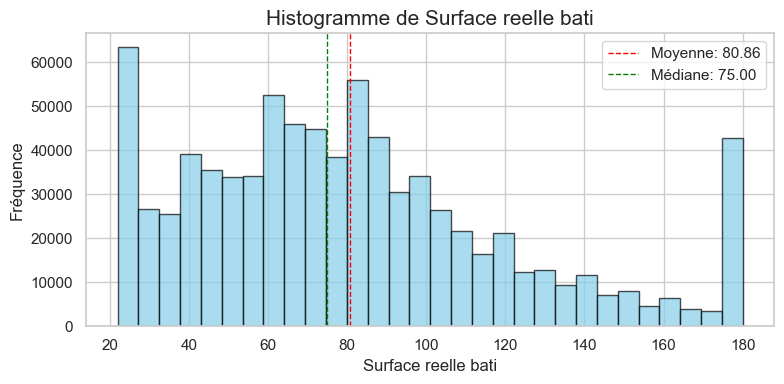

None
Colonne Nombre pieces principales
count    812363.000000
mean          3.197371
std           1.591392
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           6.000000
Name: Nombre pieces principales, dtype: float64


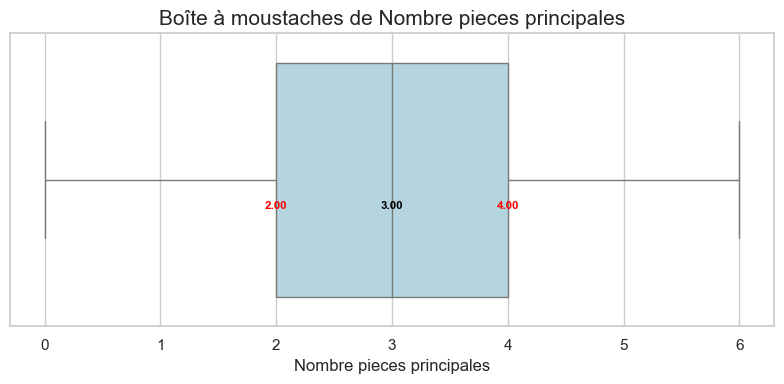

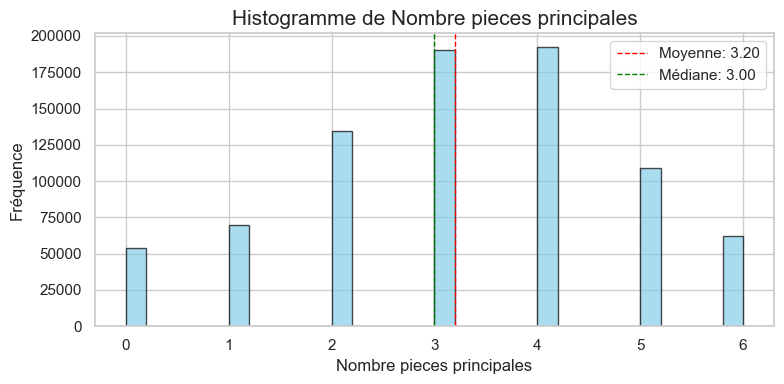

None
Colonne Type local
count          812363
unique              6
top       Appartement
freq           337556
Name: Type local, dtype: object


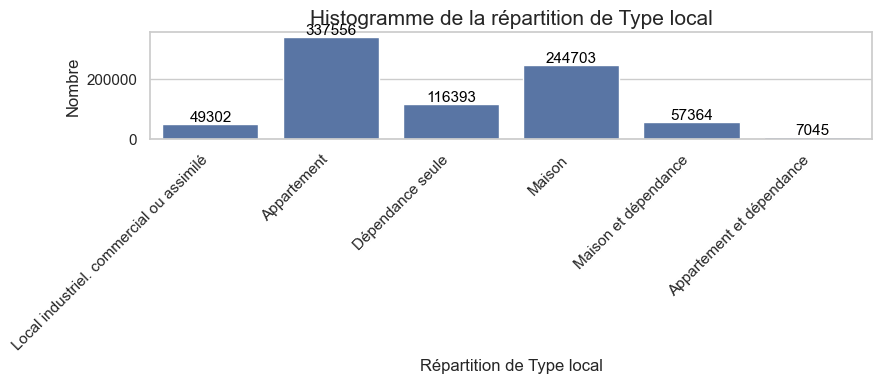

None
Colonne Surface terrain
count    812363.000000
mean        387.652947
std         572.177214
min           0.000000
25%           0.000000
50%          88.000000
75%         580.000000
max        2107.000000
Name: Surface terrain, dtype: float64


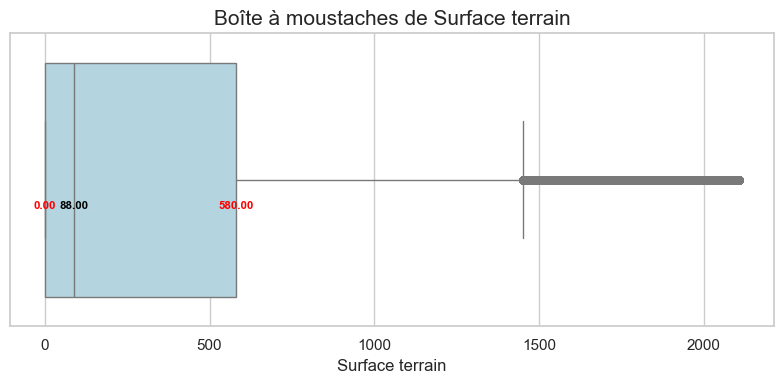

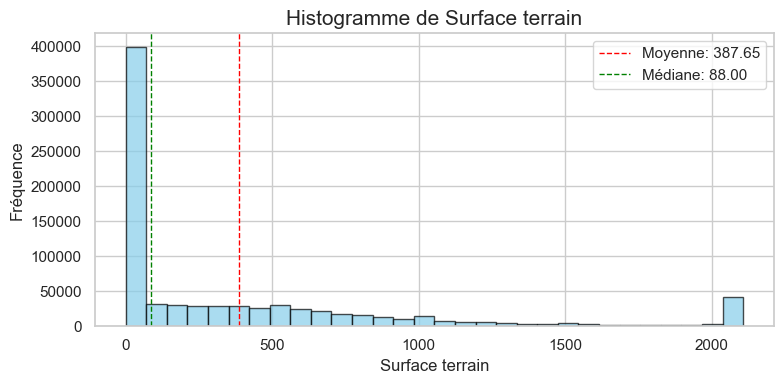

None

--------------------------------------------------

Statistiques du DataFrame data_2023_s2: 

Colonne Nature mutation
count     843930
unique         3
top        Vente
freq      842075
Name: Nature mutation, dtype: object


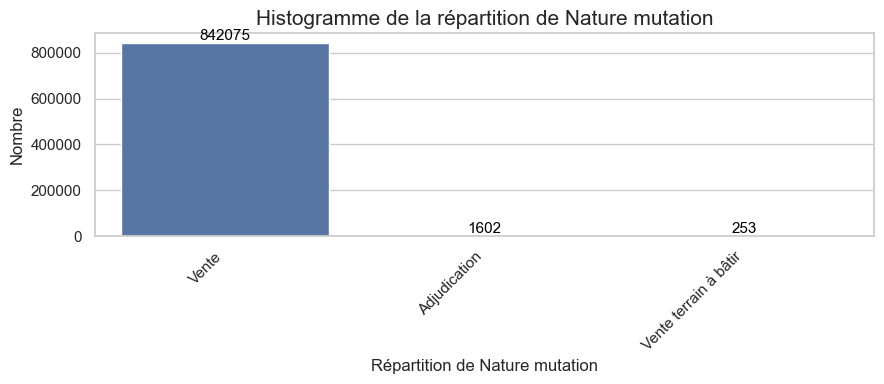

None
Colonne Valeur fonciere
count    843930.000000
mean     230858.041725
std      166342.776903
min       40000.000000
25%      110111.250000
50%      183800.000000
75%      299900.000000
max      679600.000000
Name: Valeur fonciere, dtype: float64


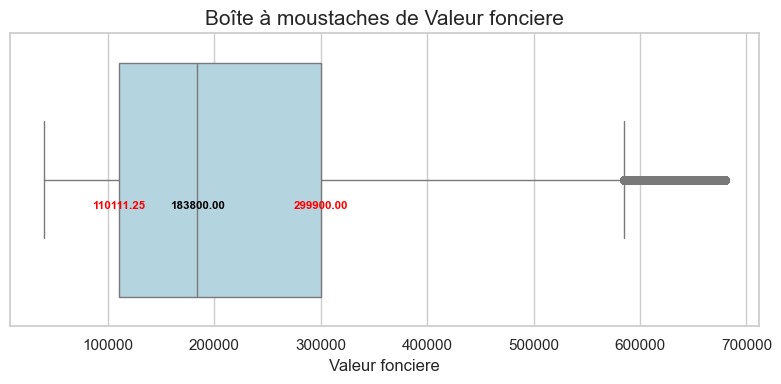

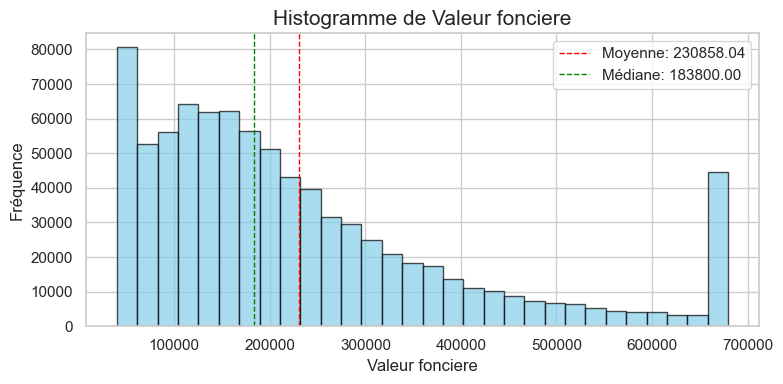

None
Colonne Surface reelle bati
count    843930.000000
mean         80.997166
std          41.034706
min          22.000000
25%          50.000000
50%          75.000000
75%         102.000000
max         180.000000
Name: Surface reelle bati, dtype: float64


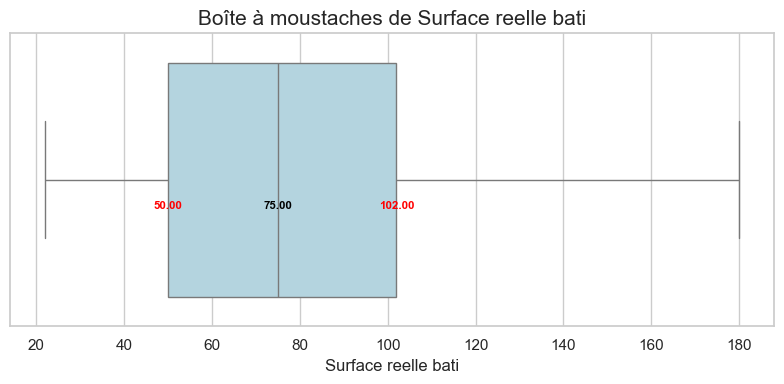

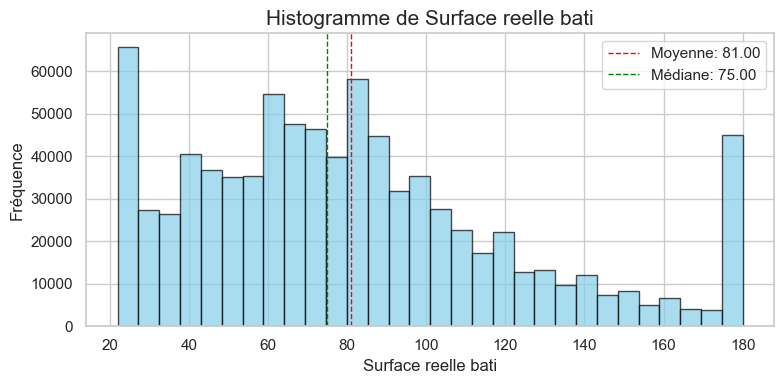

None
Colonne Nombre pieces principales
count    843930.000000
mean          3.198873
std           1.592882
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           6.000000
Name: Nombre pieces principales, dtype: float64


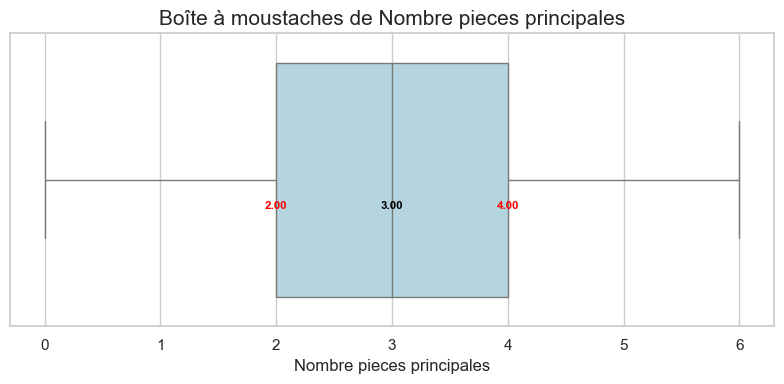

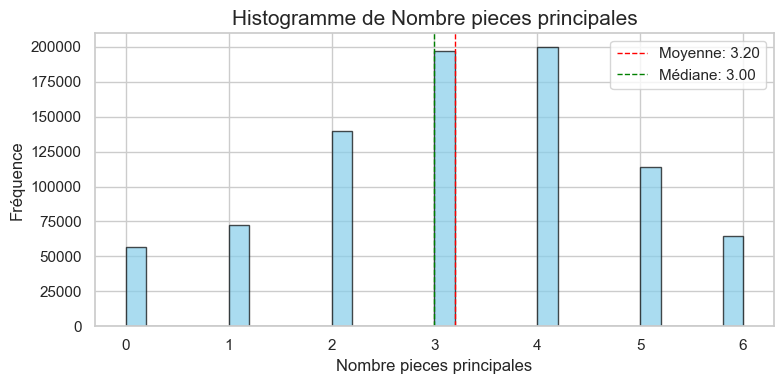

None
Colonne Type local
count          843930
unique              6
top       Appartement
freq           349648
Name: Type local, dtype: object


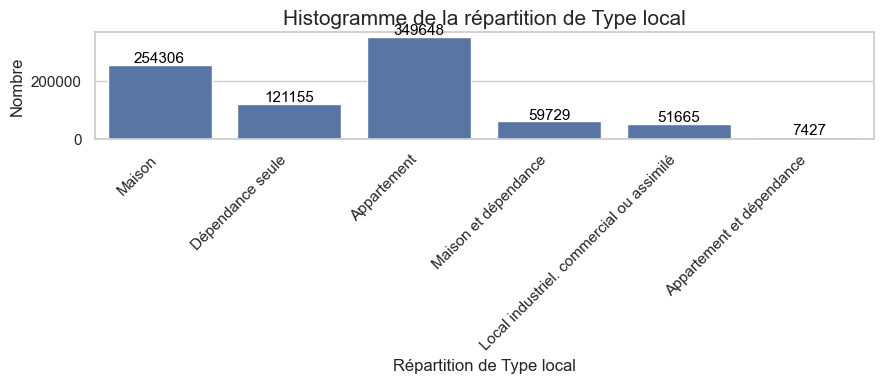

None
Colonne Surface terrain
count    843930.000000
mean        388.594253
std         572.578045
min           0.000000
25%           0.000000
50%          90.000000
75%         582.000000
max        2107.000000
Name: Surface terrain, dtype: float64


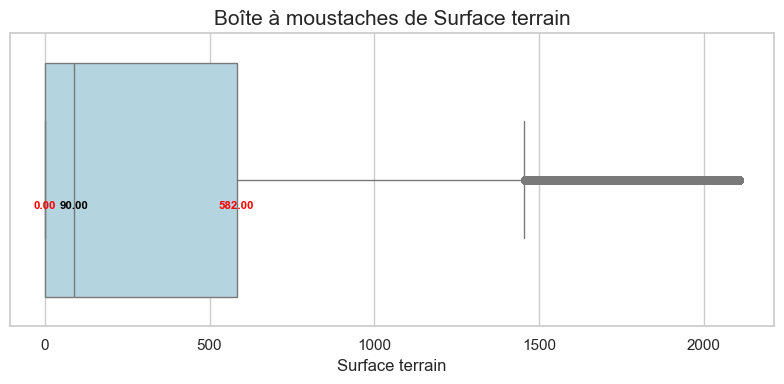

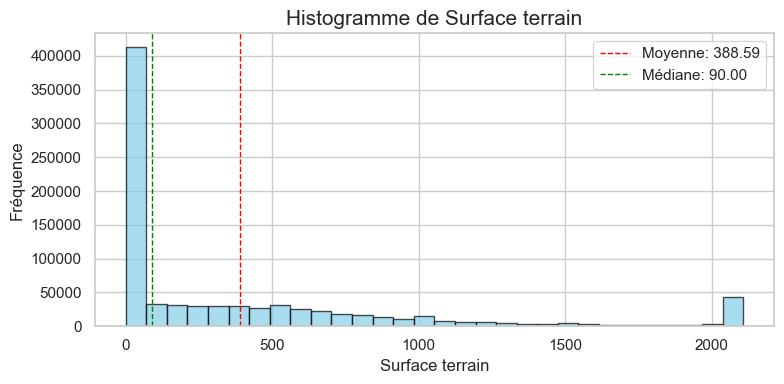

None

--------------------------------------------------



In [70]:
#colonne pour lesquels nous voulons des statistiques
columns = ['Nature mutation', 'Valeur fonciere', 'Surface reelle bati', 'Nombre pieces principales', 'Type local', 'Surface terrain']

# boucle sur les dataframes et les colonnes
for name, df in zip(list_dataframes, dataframes):
    print(f"Statistiques du DataFrame {name}: \n")
    for column in columns:
        if column in df.columns:  # Verification que la colonne existe bien dans le DataFrame
            print(f'Colonne {column}')
            print(stats(df, column))  
            print(Graph1(df, column)) 
    print("\n" + "-"*50 + "\n")


### Par colonne (sur toutes nos donnees)

Statistiques du DataFrame data_all_years: 

Colonne Nature mutation
count     5459052
unique          3
top         Vente
freq      5440046
Name: Nature mutation, dtype: object


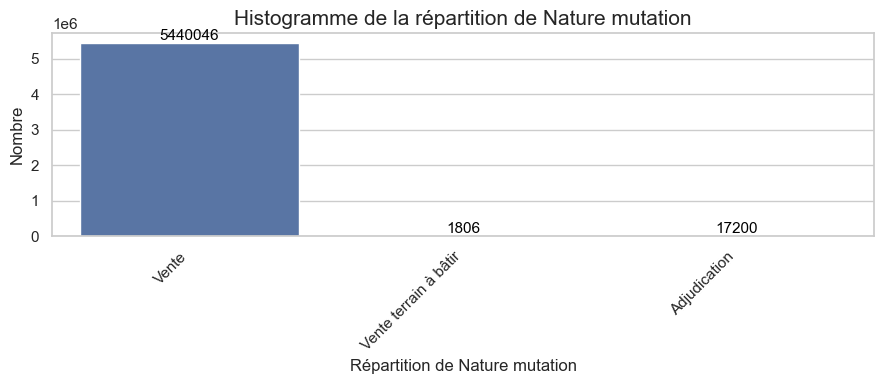

None

--------------------------------------------------

Colonne Valeur fonciere
count    5.459052e+06
mean     2.194220e+05
std      1.579524e+05
min      3.800000e+04
25%      1.050000e+05
50%      1.750000e+05
75%      2.830000e+05
max      7.000000e+05
Name: Valeur fonciere, dtype: float64


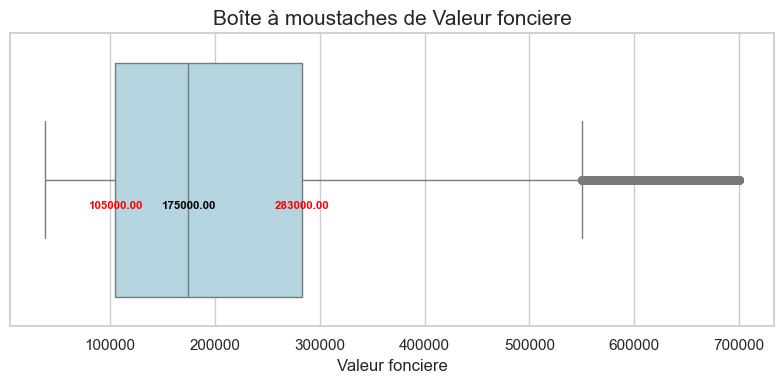

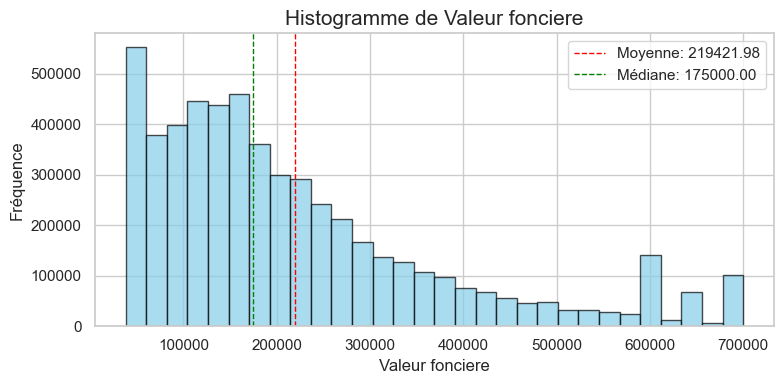

None

--------------------------------------------------

Colonne Surface reelle bati
count    5.459052e+06
mean     8.254657e+01
std      4.098537e+01
min      2.200000e+01
25%      5.200000e+01
50%      7.700000e+01
75%      1.040000e+02
max      1.840000e+02
Name: Surface reelle bati, dtype: float64


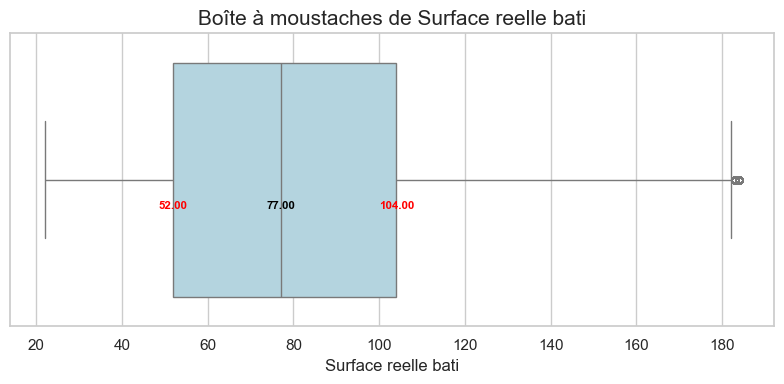

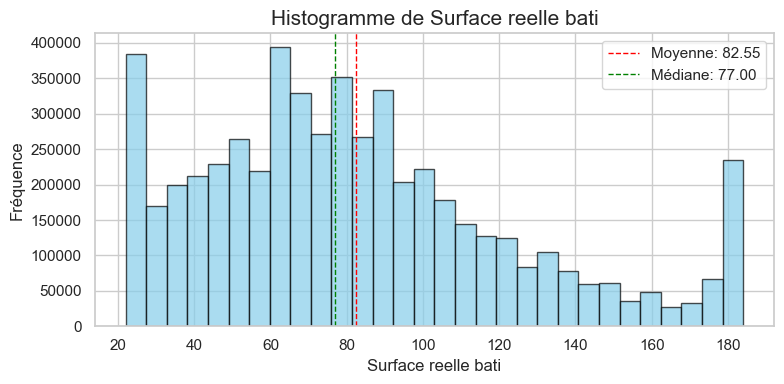

None

--------------------------------------------------

Colonne Nombre pieces principales
count    5.459052e+06
mean     3.267376e+00
std      1.582999e+00
min      0.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      6.000000e+00
Name: Nombre pieces principales, dtype: float64


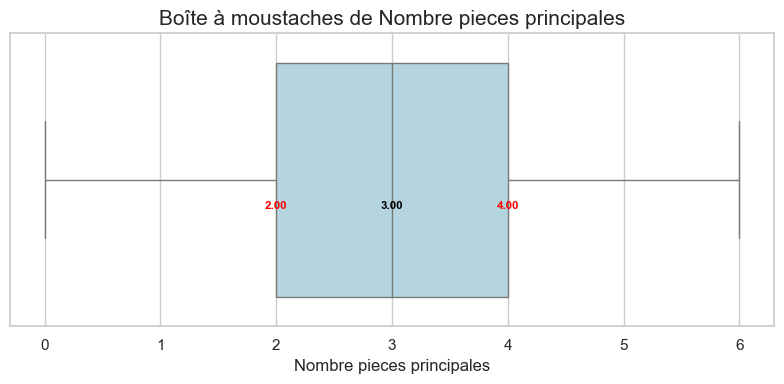

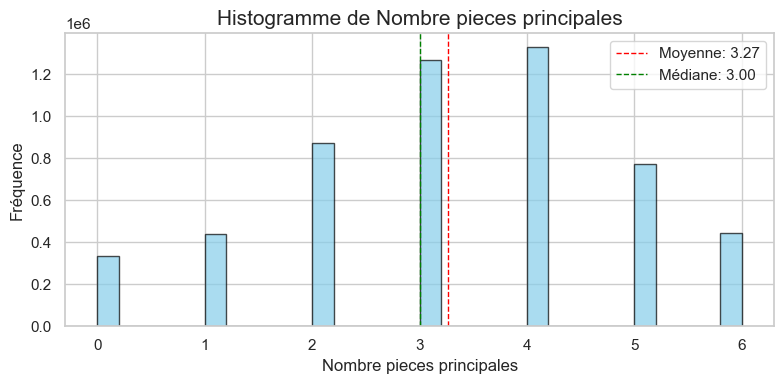

None

--------------------------------------------------

Colonne Type local
count         5459052
unique              6
top       Appartement
freq          2267100
Name: Type local, dtype: object


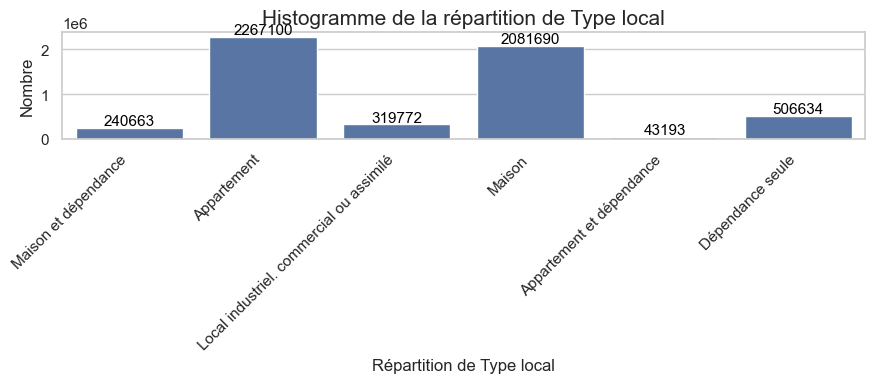

None

--------------------------------------------------

Colonne Surface terrain
count    5.459052e+06
mean     3.850789e+02
std      5.571431e+02
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+02
75%      5.870000e+02
max      2.185000e+03
Name: Surface terrain, dtype: float64


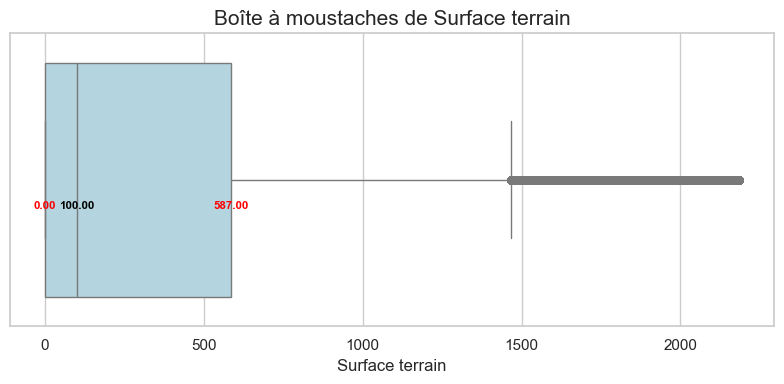

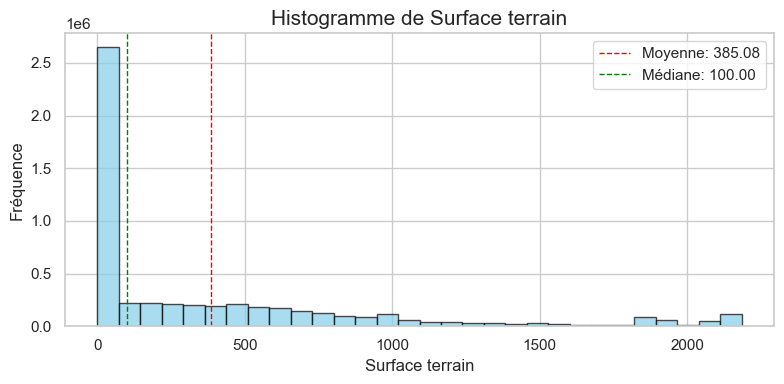

None

--------------------------------------------------



In [71]:
# meme chose que la cellule précédente mais sur data_all_years
print(f"Statistiques du DataFrame data_all_years: \n")
for column in columns:
    print(f'Colonne {column}')
    print(stats(data_all_years, column))
    print(Graph1(data_all_years, column))
    print("\n" + "-"*50 + "\n")

Statistiques descriptives de la valeur foncière par type de bien :
                                              count           mean  \
Type local                                                           
Appartement                               2267100.0  203211.044013   
Appartement et dépendance                   43193.0  269901.043248   
Dépendance seule                           506634.0  233931.790571   
Local industriel. commercial ou assimilé   319772.0  251978.156668   
Maison                                    2081690.0  223126.379253   
Maison et dépendance                       240663.0  257227.371445   

                                                    std      min       25%  \
Type local                                                                   
Appartement                               150717.023903  38000.0   99023.5   
Appartement et dépendance                 191340.665079  38000.0  123200.0   
Dépendance seule                          182178.974294  380

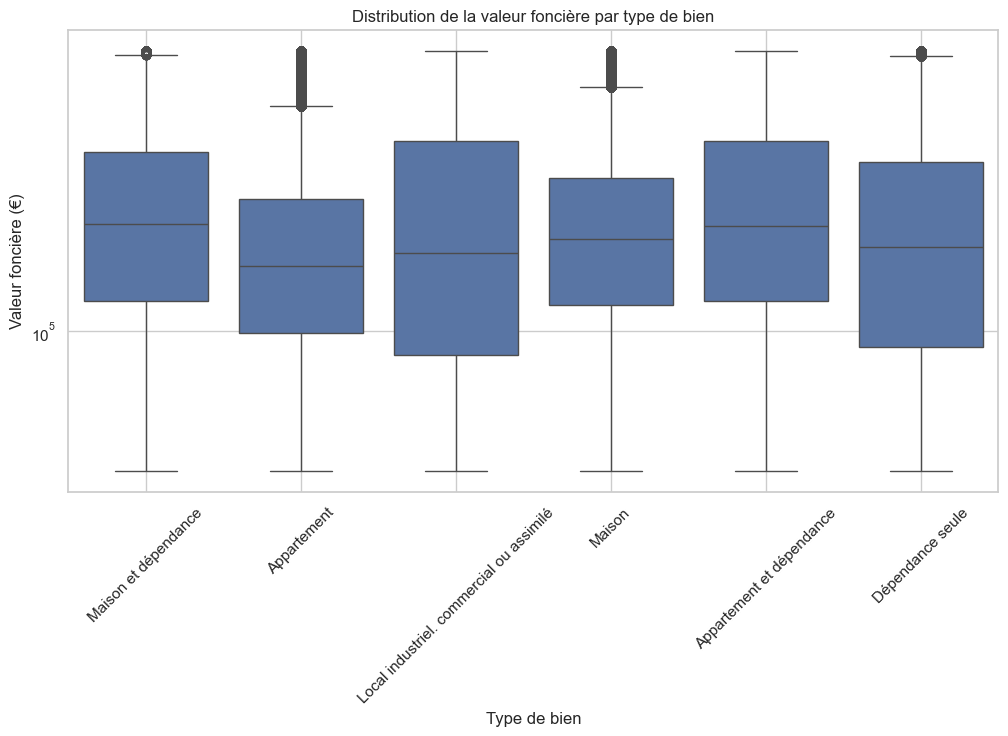

In [72]:
# Calculer les statistiques descriptives par type de bien
stats_descriptives = data_all_years.groupby('Type local')['Valeur fonciere'].describe()
print("Statistiques descriptives de la valeur foncière par type de bien :")
print(stats_descriptives)

# Visualisation avec une echelle logarithmique 
plt.figure(figsize=(12, 6))
sns.boxplot(x='Type local', y='Valeur fonciere', data=data_all_years)
plt.title('Distribution de la valeur foncière par type de bien')
plt.xlabel('Type de bien')
plt.ylabel('Valeur foncière (€)')
plt.xticks(rotation=45)
plt.yscale('log')
plt.grid(True)

plt.show()

In [ ]:
# fonction qui permet d'afficher le nombre de ventes en fonction de la liste donne (villes, departement ou type local)
def occurences(liste, colonne):
    # liste pour stocker les occurrences de chaque ville/dep/type local pour chaque annee
    occurrences = {element: [] for element in liste}

    # Parcourt des dataframes de chaque annee pour calculer le nombre d'occurrences de chaque ville pour chaque annee
    for df in dataframes:
        for element in liste:
            occurrences[element].append(df[df[colonne] == element].shape[0])

    # creation du graphique
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Creation du graphique des occurrences avec ax1
    for element in liste:
        ax1.plot(semesters, occurrences[element], marker='o', label=f"{element}")

    ax1.set_xlabel('Semestre')
    ax1.set_ylabel('Nombre de ventes', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_xticks(semesters)
    ax1.set_xticklabels([date.strftime('%Y-%m-%d') for date in semesters], rotation=45, ha='right', fontsize=8)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.grid(True)
    fig.subplots_adjust(bottom=0.2)

    # Ajout d'un axe pour les taux avec ax2 
    ax2 = ax1.twinx()
    ax2.plot(semesters, taux_sem, marker='x', color='black', label='Taux')
    ax2.set_ylabel('Taux (%)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # Legende
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)

    plt.title('Nombre de ventes et taux d\'intérêt (2018-2023)')

    plt.show()

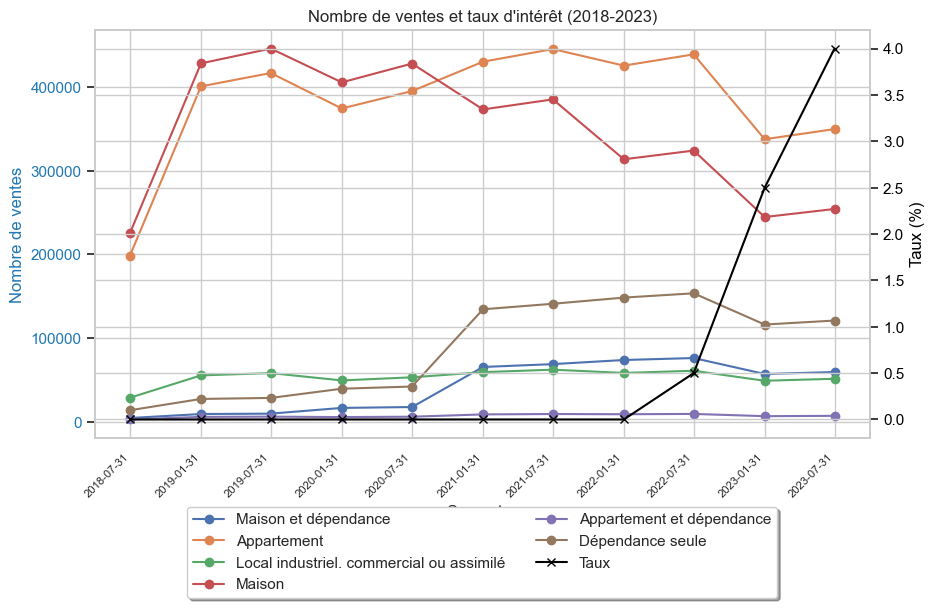

In [54]:
#recuperation de tous les types de local 
types_locaux_uniques = data_all_years['Type local'].unique()

#graphique qui plot le nombre de vente en fonction du type de local 
occurences(types_locaux_uniques, 'Type local')

## Statistiques par ville et département

### Fonction qui vont être utilisés

In [ ]:
#Fonction regression classique 
def ols(X, y):
    # Ajout d'une colonne de 1 pour representer l'intercept dans X
    X_with_intercept = np.c_[np.ones(X.shape[0]), X]
    
    # Calcul des coefficients de regression à l'aide de la formule des moindres carres ordinaires
    beta = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y
    
    return beta

In [ ]:
#Fonction qui traite le problème de matrice singulière
def ridge(X, y, alpha=1.0):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    ridge_reg = Ridge(alpha=alpha)
    ridge_reg.fit(X_scaled, y)
    return np.append(ridge_reg.intercept_, ridge_reg.coef_)  # Ajoute l'interception aux coefficients


In [ ]:
# Fonction regression
def reg(data, liste, colonne, type_regression ):
    # Filtre du DataFrame pour ne garder que les ville/departement et les types locaux specifies
    data_filtered = data[data[colonne].isin(liste)]

    # Initialiser une liste pour stocker les resultats des regressions par ville/departement
    regression_results = []

    # Parcourir chaque ville/departement pour effectuer une regression
    for element in liste:
        # Initialisation du DataFrame qui stocke les resultats de la regression pour cette ville/departement
        results_df = pd.DataFrame(index=data_filtered['Type local'].unique(), columns = ['Intercept', 'Surface reelle bati', 'Nombre pieces principales', 'Surface terrain','Taux'])

        # Filtre des donnees pour la ville/departement actuelle
        data_subset = data_filtered[data_filtered[colonne] == element]

        # Parcourt de chaque type local pour effectuer une regression
        for type_local in data_subset['Type local'].unique():
            # Filtre des donnees pour le type local actuel
            data_type_local = data_subset[data_subset['Type local'] == type_local]

            # choix du regresseur X
            X = data_type_local[['Surface reelle bati', 'Nombre pieces principales', 'Surface terrain', 'Taux']]

            # choix de la valeur a expliquer Y
            y = data_type_local['Valeur fonciere']
            
            #Gestion matrice singulière (non inversible) avec ridge
            if type_regression == ols:
                beta = ols(X,y)
            elif type_regression == ridge:
                beta = ridge(X,y)

            # Stockage des coefficients de regression dans le DataFrame des resultats
            results_df.loc[type_local] = beta
        
        # Normalisation des coefficients
        for col in ['Intercept', 'Surface reelle bati', 'Nombre pieces principales', 'Surface terrain','Taux']:
            max_abs_coeff = np.max(np.abs(results_df[col]), axis=0)
            results_df[col] /= max_abs_coeff

        # Convertir toutes les valeurs du DataFrame en type numérique
        results_df = results_df.apply(pd.to_numeric)
    
        # Ajout du DataFrame de resultats pour cette ville/departement à la liste
        regression_results.append(results_df)

    # Afficher les resultats des regressions pour chaque ville/departement
    for i, results_df in enumerate(regression_results):
        plt.figure(figsize=(10, 6)) 
        ax = results_df.plot(kind='bar', rot=45, title=f"Résultats de la régression pour {liste[i]}")
        plt.xlabel('Type Local')
        plt.ylabel('Coefficients (Normalized)')
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
        plt.tight_layout()
        plt.xticks(rotation=45, ha='right', fontsize=8)
        plt.subplots_adjust(bottom=0.15)  # Ajuste le bas du sous-graphique pour laisser de la place aux etiquettes
        plt.gcf().set_size_inches(10, 8) 
        plt.show()


In [ ]:
# Fonction qui calcul le nombre de m2 moyen par ville/dep

def m2_moyen(liste,colonne):
    # Dictionnaire pour stocker les moyennes de surface pour chaque ville/dep
    moyennes_surface = {}
    # Dictionnaire pour stocker les données de prix fonciers par ville/dep 
    donnees_prix = {element: [] for element in liste}

    # Parcourir les dataframes pour chaque annee
    for df in dataframes:
        # Parcourir chaque ville/dep
        for element in liste:
            # Filtrer les données pour la ville/dep actuelle
            data = df[df[colonne] == element]
            # Calcule de la moyenne de la surface reelle batie
            moyenne_surface = data['Surface reelle bati'].mean()
                
            # Ajout de la moyenne de surface au département correspondant dans le dictionnaire
            if element not in moyennes_surface:
                moyennes_surface[element] = [moyenne_surface]
            else:
                moyennes_surface[element].append(moyenne_surface)

    # Calcule de la moyenne sur toutes les annees
    moyennes_surface = {element: sum(moyennes) / len(moyennes) for element, moyennes in moyennes_surface.items()}

    print(f"Moyenne de mètres carrés pour :")
    for element, moyenne in moyennes_surface.items():
        print(f"{element}: {moyenne} m2")


In [ ]:
# Fonction qui calcule le prix foncier moyen par m2 par ville/dep 
def prix_moyen_par_metre_carre (liste, colonne):
    donnees_prix = {element: [] for element in liste}

    # Parcourir les dataframes pour chaque annee
    for df in dataframes :
        # Parcourir chaque ville/dep
        for element in liste:
            # Filtrer les donnees pour la ville/dep actuelle
            data = df[df[colonne] == element]
            # Calcule de la moyenne des prix fonciers par metre carre pour cette ville et cette annee
            prix_par_metre_carre = data['Valeur fonciere'] / data['Surface reelle bati']
            prix_moyen_par_metre_carre = prix_par_metre_carre.mean()
            # Ajouter le prix moyen à la liste correspondante pour cette ville
            donnees_prix[element].append(prix_moyen_par_metre_carre)


    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Cree un graphique pour montrer l'evolution des prix fonciers par ville au fil des annees
    for element, donnees in donnees_prix.items():
        plt.plot(semesters, donnees, marker='o', label=element)


    ax1.set_xlabel('Semestre')
    ax1.set_ylabel('Prix foncier moyen par mètre carré', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_xticks(semesters)
    ax1.set_xticklabels([date.strftime('%Y-%m-%d') for date in semesters], rotation=45, ha='right', fontsize=8)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.grid(True)
    fig.subplots_adjust(bottom=0.2)

    # Ajout d'un axe pour les taux
    ax2 = ax1.twinx()
    ax2.plot(semesters, taux_sem, marker='x', color='black', label='Taux')
    ax2.set_ylabel('Taux (%)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # Legende
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)

    plt.title('Évolution des prix fonciers par m2 (2018-2023)')
    plt.show()

In [ ]:
#fonction qui plot des histogrammes qui represente la repartition (en pourcentage) la part de chaque type de local dans la liste (ville ou dep)

def types_locales_single_histogram(liste, colonne):
    # Initialisation du DataFrame pour stocker les pourcentages d'occurrence de chaque type de local pour chaque element de la liste
    df_occurrences = pd.DataFrame(columns=liste)

    # Calcul des pourcentages d'occurrence pour chaque element de la liste
    for element in liste:
        occurrences_by_type = pd.Series(dtype=float)  # Utiliser float pour stocker les pourcentages
        total_occurrences = 0  # Initialiser le total des occurrences pour l'element

        for df in dataframes:
            # Filtre du DataFrame pour inclure uniquement les lignes où la colonne "Commune" ou "Departement" correspond à l'element actuel
            df_filtered = df[df[colonne] == element]

            # Utiliser value_counts() pour compter les occurrences des types locaux dans le DataFrame filtrer
            occurrences = df_filtered['Type local'].value_counts()

            # Ajout des occurrences au total pour l'element actuel
            total_occurrences += occurrences.sum()

            # Ajout des occurrences au total par type
            occurrences_by_type = occurrences_by_type.add(occurrences, fill_value=0)

        # Conversion des occurrences en pourcentage pour l'element actuel
        occurrences_by_type = (occurrences_by_type / total_occurrences) * 100

        # Ajout des pourcentages d'occurrence de chaque type de local au DataFrame
        df_occurrences[element] = occurrences_by_type

    # Afficher un seul histogramme avec des barres divisees par element de la liste
    types = df_occurrences.index
    num_types = len(types)
    width = 0.8 / len(liste)  # Largeur des barres
    x = np.arange(num_types)  # Positions des barres

    plt.figure(figsize=(12, 8))

    for i, element in enumerate(liste):
        plt.bar(x + i * width, df_occurrences[element], width=width, label=element)

    plt.xlabel('Type local')
    plt.ylabel("Pourcentage d'occurrences")
    plt.title('Répartition des types locaux en pourcentage par élément de la liste')
    plt.xticks(x + 0.4, types, rotation=45, ha='right')
    plt.legend(title='Éléments')
    plt.tight_layout()
    plt.show()


### Top 5 (ville et département)

#### Villes

In [61]:
# Creation d'un DataFrame vide pour stocker les resultats
resultats_ville = pd.DataFrame()

# Boucle a travers les annees, en utilisant enumarate pour acceder à l'index et au DataFrame
for index, sem in enumerate(semesters):
    data_sem = dataframes[index]
    nombre_occurrences_par_commune = data_sem['Commune'].value_counts().head(10)
    resultats_ville[sem] = nombre_occurrences_par_commune

# Remplacement des valeurs NaN par 0
resultats_ville.fillna(0, inplace=True)

# Afficher le tableau
print("Nombre de vente pour les 10 villes les plus dynamiques")
print(resultats_ville)

Nombre de vente pour les 10 villes les plus dynamiques
             2018-07-31  2019-01-31  2019-07-31  2020-01-31  2020-07-31  \
Commune                                                                   
PARIS             19667       37320       38684       30355       31995   
MARSEILLE          7349       14265       14749       13556       14237   
TOULOUSE           4908        9498        9904        8775        9248   
LYON               4846        8957        9292        7696        8173   
NICE               4399        8768        9081        8059        8499   
NANTES             3354        6521        6758        5605        5932   
MONTPELLIER        3081        5660        5868        5313        5605   
BORDEAUX           2896        5297        5561        4924        5240   
LILLE              2605        4850        5056        4430        4714   
RENNES             2263        4043        4211        3526        3763   

             2021-01-31  2021-07-31  2022-01

On voit qu'une tendance ressort, les 5 villes dans lesquelles ont lieu le plus de transaction sont les villes de Paris, Marseille, Lyon, Nice et Toulouse. Étudions les !!

In [ ]:
#liste des villes les plus dynamique (en volume)
villes = ['PARIS', 'TOULOUSE', 'NICE', 'LYON', 'MARSEILLE']

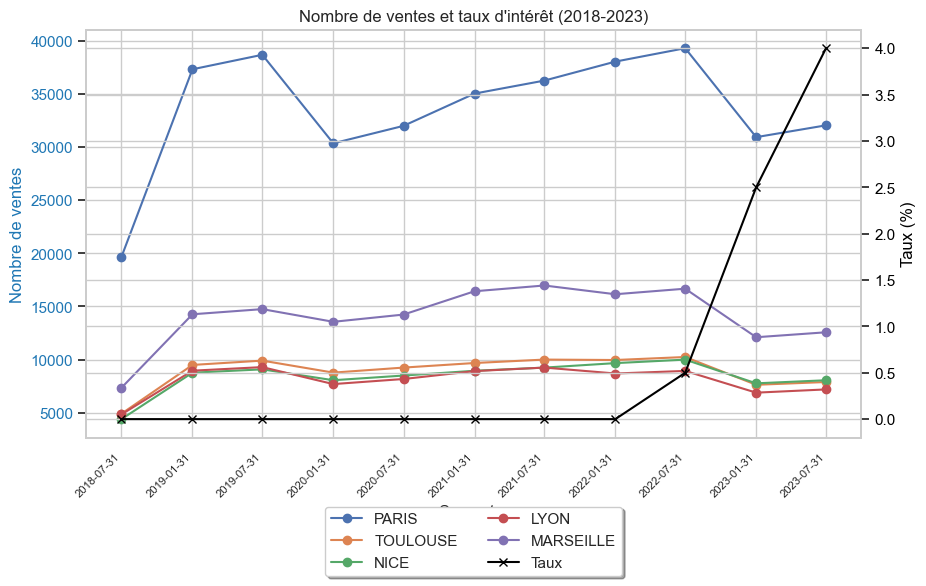

In [63]:
#Affichage du nombre de ventes par villes dynamiques 
occurences(villes, 'Commune')

In [75]:
#affichage du nombre de m2 par ville dynamique en volume 
m2_moyen(villes, 'Commune')

Moyenne de mètres carrés pour :
PARIS: 58.032663512922134 m2
TOULOUSE: 65.83415653405164 m2
NICE: 60.61999982075645 m2
LYON: 68.95417801447252 m2
MARSEILLE: 66.60909326131595 m2


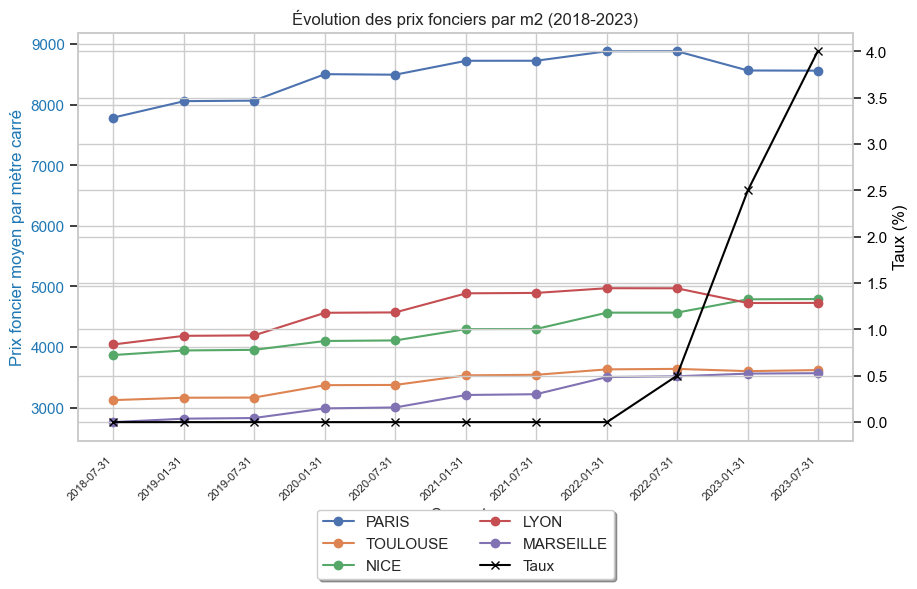

In [64]:
#affichage du prix foncier par m2 pour les villes dynamiques en volume 
prix_moyen_par_metre_carre(villes, 'Commune')

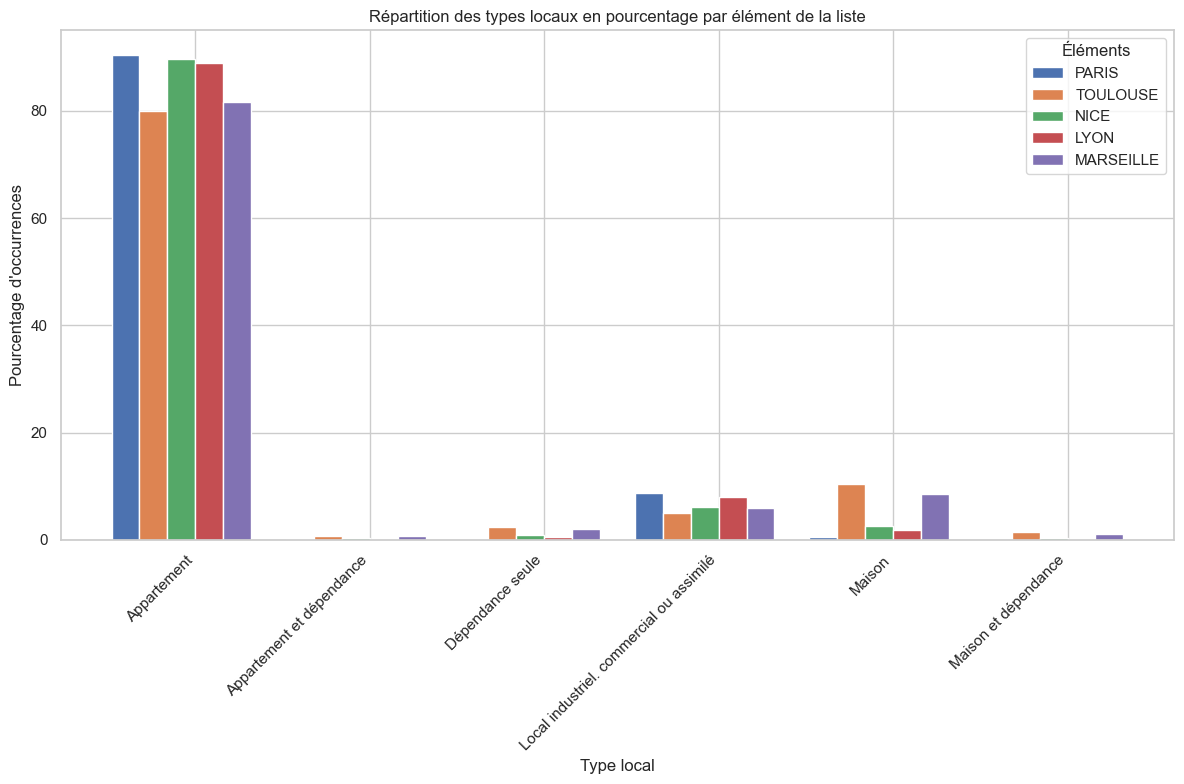

In [65]:
#affichage de la repartition des types de local par ville dynamique en volume 
types_locales_single_histogram(villes,'Commune')

#### Département

In [76]:
# Creation d'un DataFrame vide pour stocker les resultats
resultats_dep = pd.DataFrame()

# Boucle a travers les annees, utilisation enumerate pour acceder à l'index et au DataFrame
for index, sem in enumerate(semesters):
    data_sem = dataframes[index]
    nombre_occurrences_par_dep = data_sem['Département'].value_counts().head(10)
    resultats_dep[sem] = nombre_occurrences_par_dep

# Remplacer les valeurs NaN par 0
resultats_dep.fillna(0, inplace=True)

# Afficher le tableau
print("Nombre de vente pour les 10 département les plus dynamiques")
print(resultats_dep)

Nombre de vente pour les 10 département les plus dynamiques
             2018-07-31  2019-01-31  2019-07-31  2020-01-31  2020-07-31  \
Département                                                               
75                19690       37360       38727     30387.0     32031.0   
59                17993       35021       36544     34026.0     36151.0   
13                15302       29851       30944     28431.0     29862.0   
69                14274       27679       28824     25095.0     26621.0   
06                13445       27154       28155     24756.0     26091.0   
33                13417       24823       25855     23406.0     24784.0   
44                12429       24002       24911     21750.0     23062.0   
92                12047       22809       23707         0.0         0.0   
34                11995       23541       24411     22609.0     23843.0   
83                11601       22894       23703     23486.0     24718.0   

             2021-01-31  2021-07-31  20

On voit qu'une tendance ressort, les 5 département dans lesquelles ont lieu le plus de transaction sont les départements suivant : '75', '59', '13', '69', '06'. Étudions les !!

In [ ]:
#liste des departements les plus dynamiques en volume 
departements = ['75', '59', '13', '69', '06']

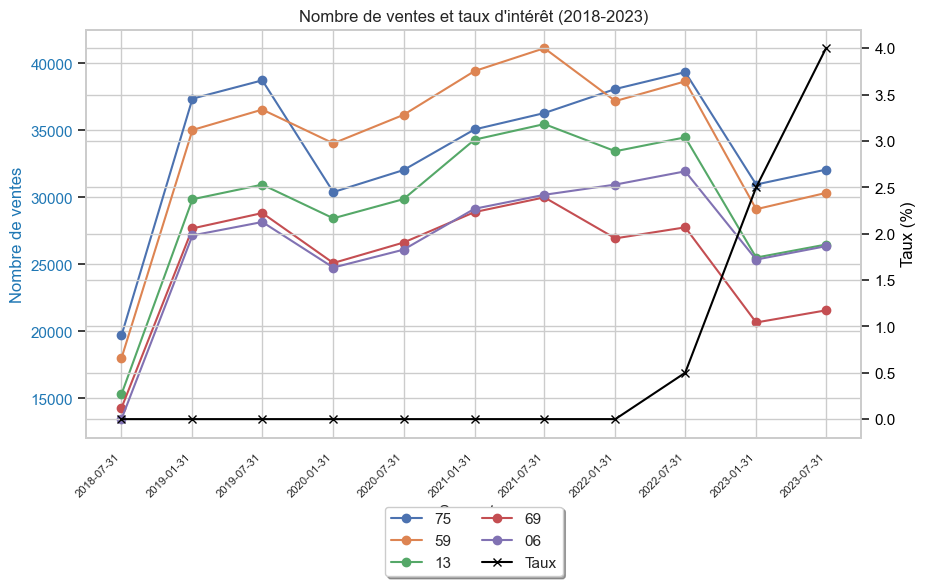

In [78]:
#Affichage du nombre de ventes par departements dynamiques (en volume)
occurences(departements, 'Département')

In [79]:
#affichage du nombre de m2 par departement dynamique en volume 
m2_moyen(departements, 'Département')

Moyenne de mètres carrés pour :
75: 58.040264039678846 m2
59: 87.51670784138362 m2
13: 74.17276609472857 m2
69: 80.33258007468719 m2
06: 66.34819729652486 m2


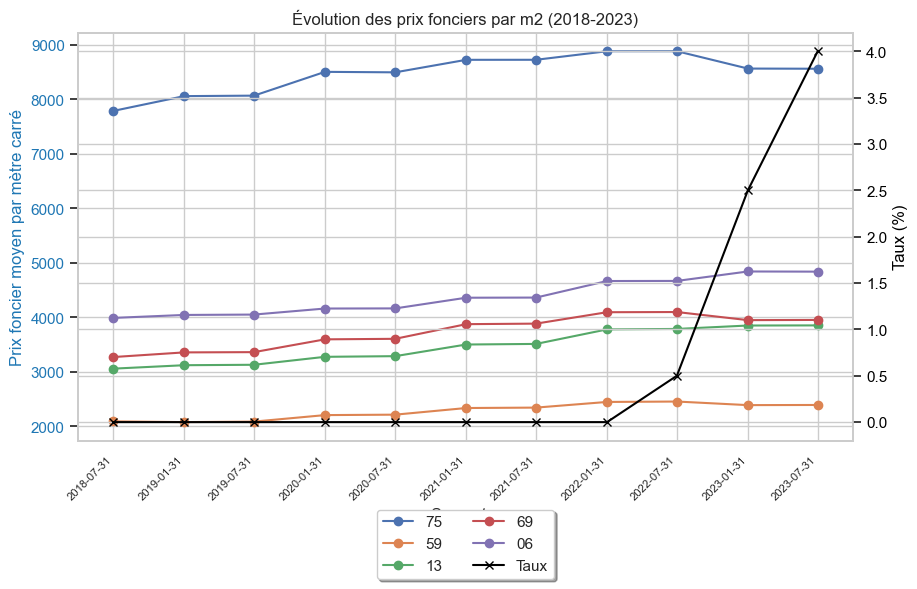

In [80]:
#affichage du prix foncier par m2 pour les departements dynamiques en volume 
prix_moyen_par_metre_carre(departements, 'Département')

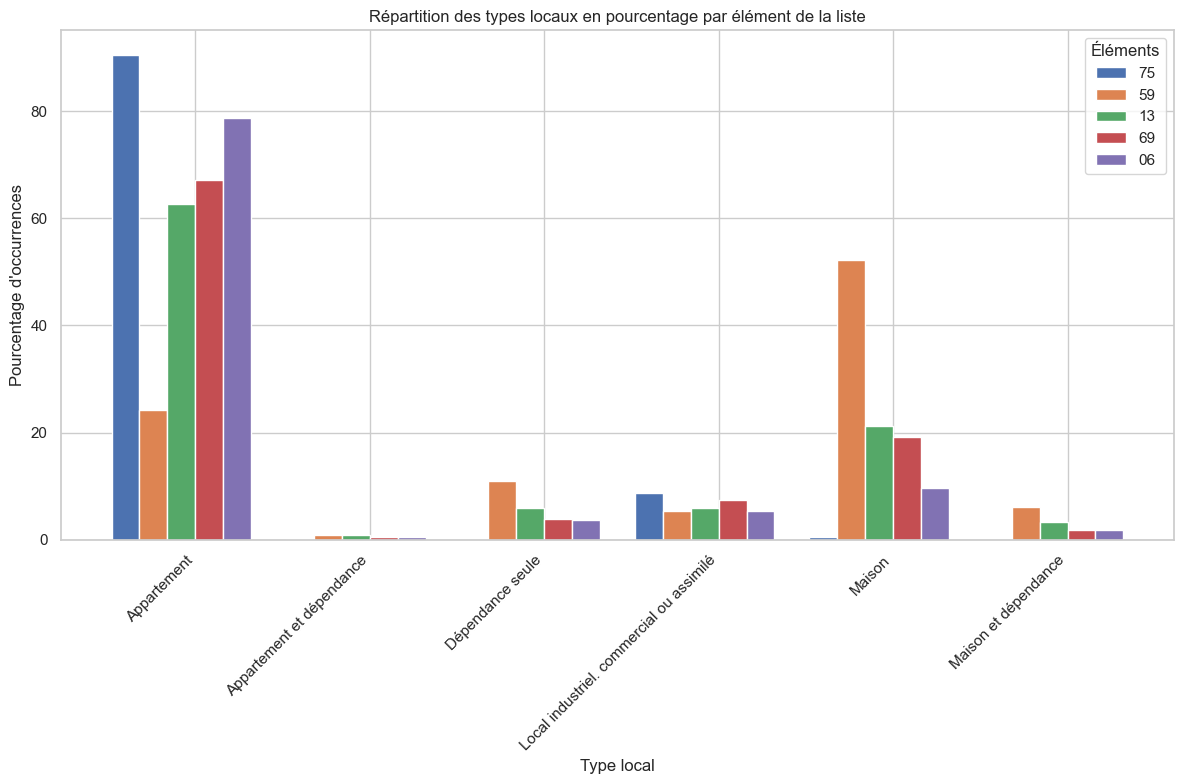

In [81]:
#affichage de la repartition des types de local par departement dynamique en volume 
types_locales_single_histogram(departements,'Département')

#### Regressions

##### Par départements

<Figure size 1000x600 with 0 Axes>

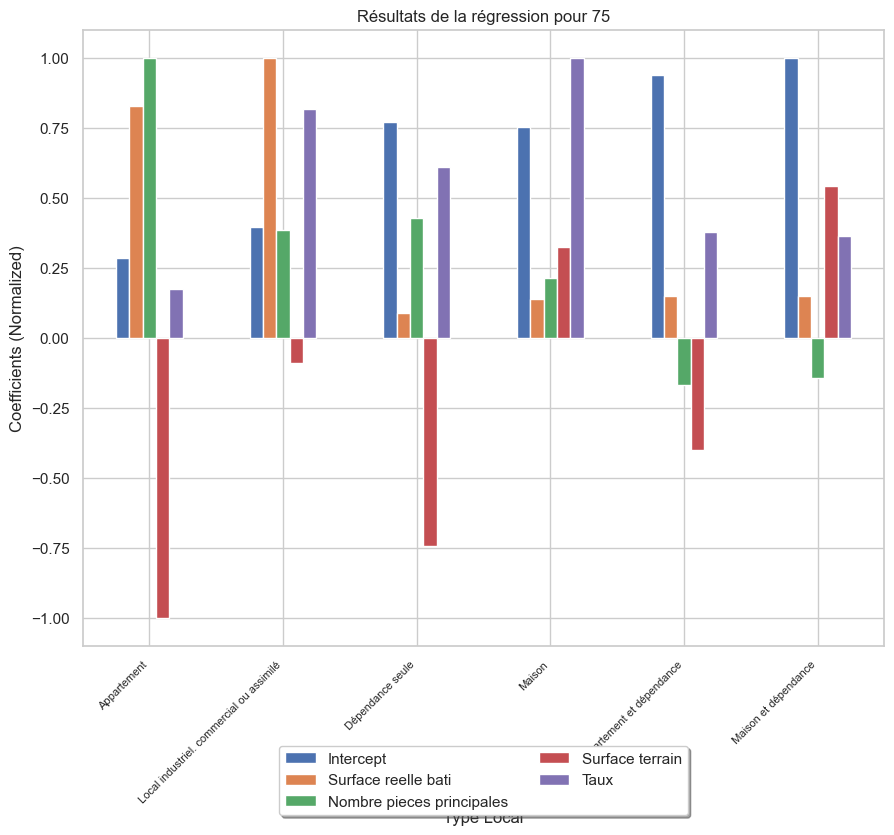

<Figure size 1000x600 with 0 Axes>

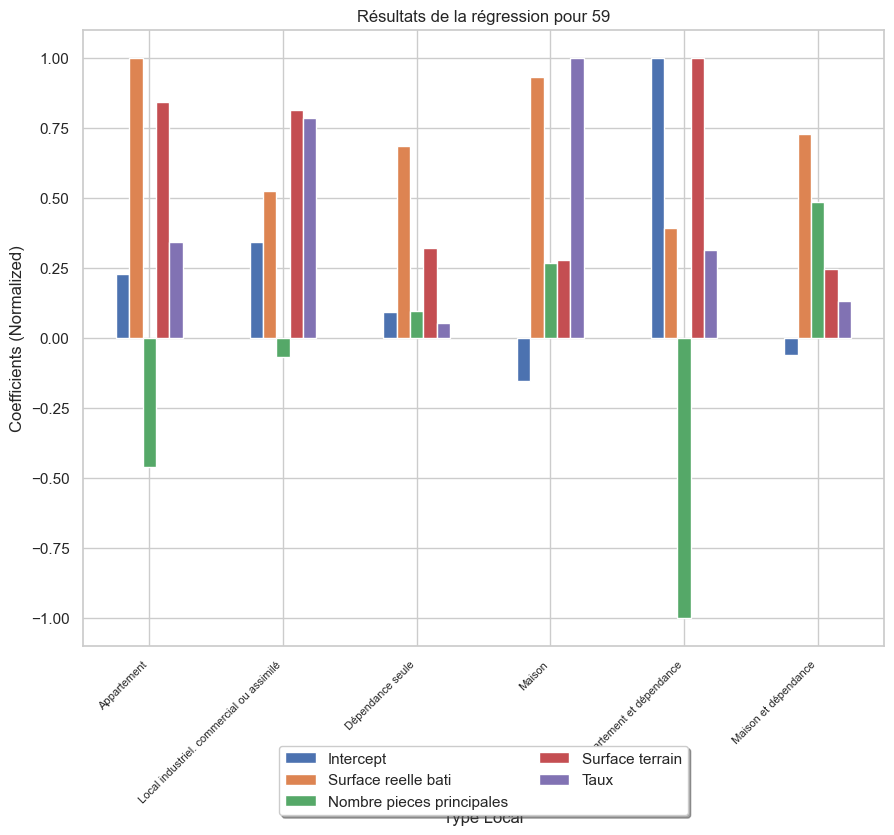

<Figure size 1000x600 with 0 Axes>

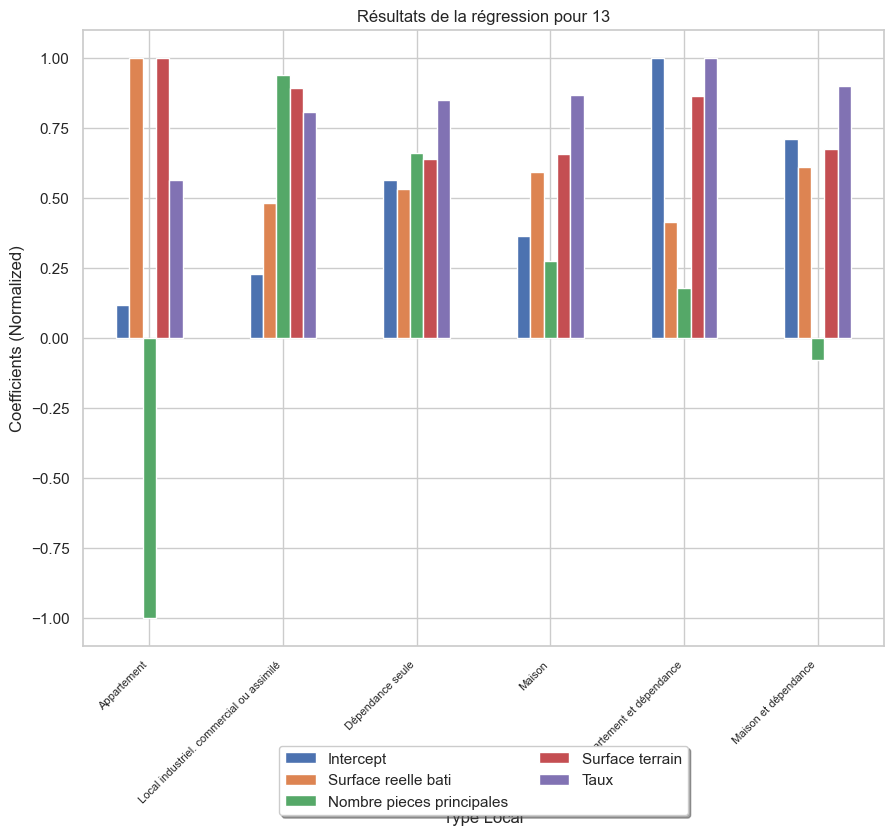

<Figure size 1000x600 with 0 Axes>

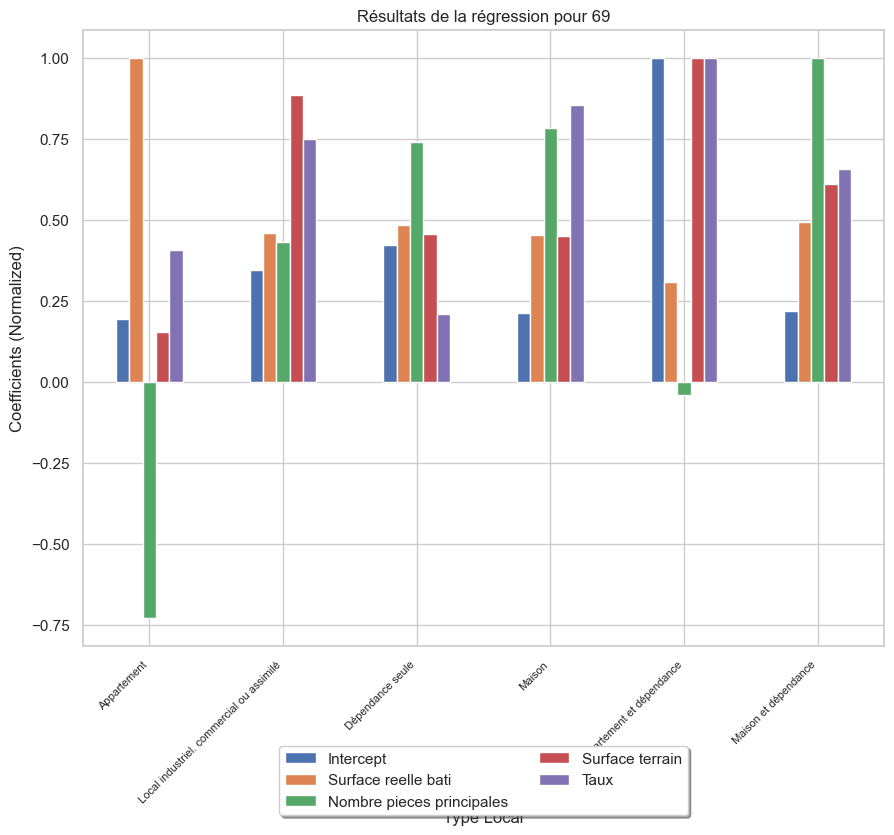

<Figure size 1000x600 with 0 Axes>

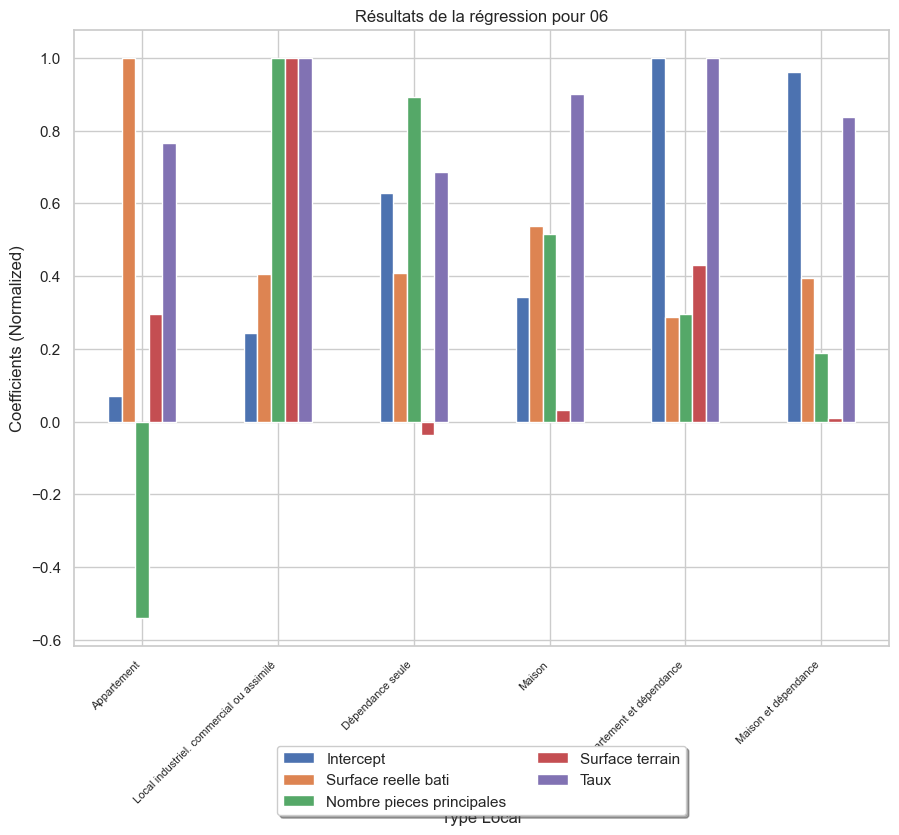

In [82]:
#regression expliquant la valeur fonciere par departement dynamiques 
reg(data_all_years,departements,'Département', ols)

##### Par villes

<Figure size 1000x600 with 0 Axes>

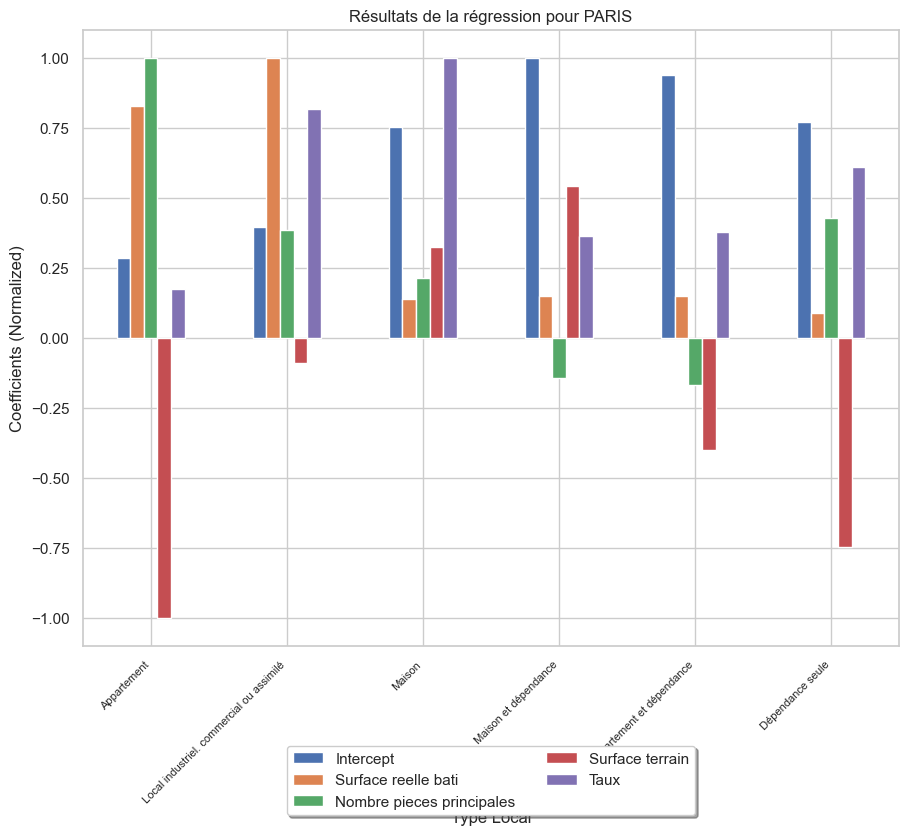

<Figure size 1000x600 with 0 Axes>

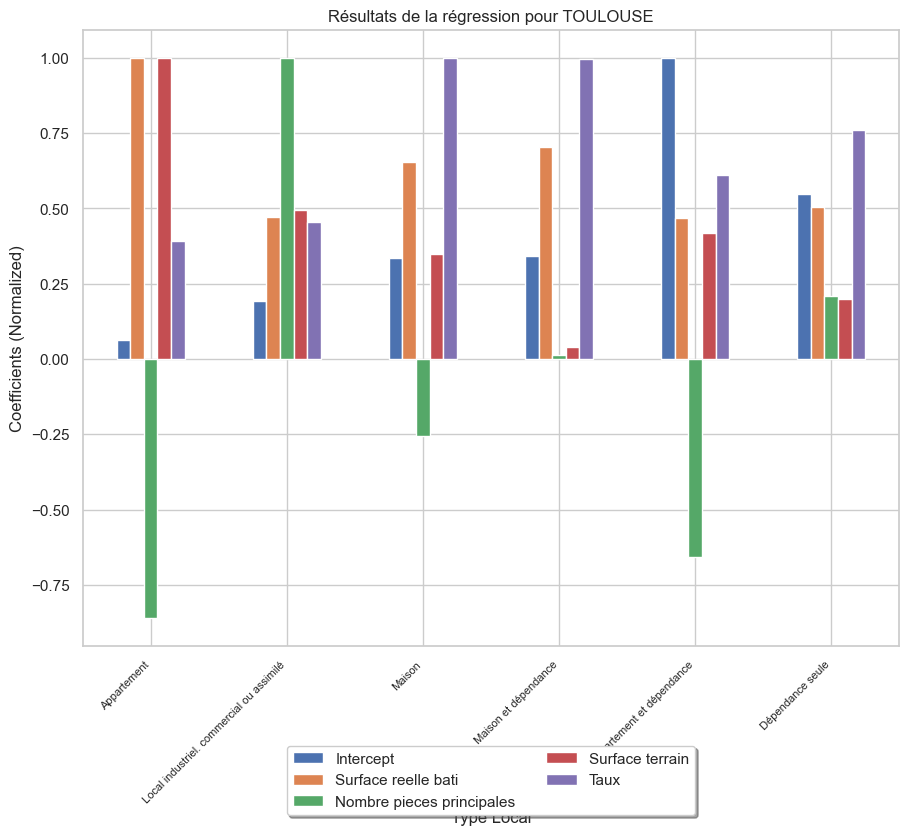

<Figure size 1000x600 with 0 Axes>

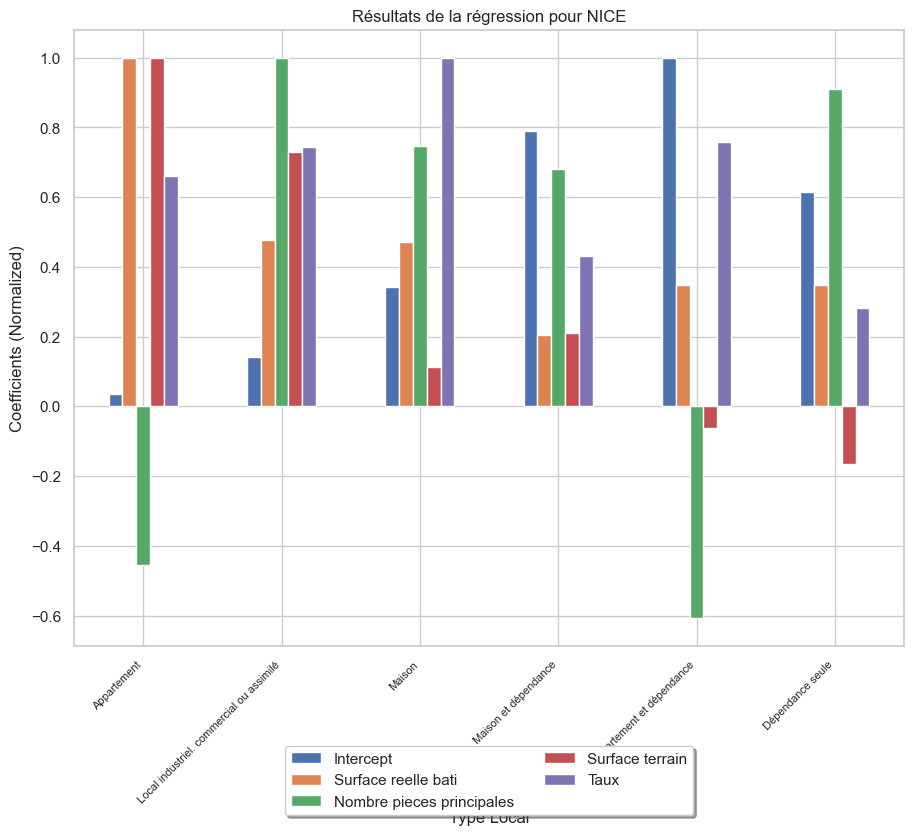

<Figure size 1000x600 with 0 Axes>

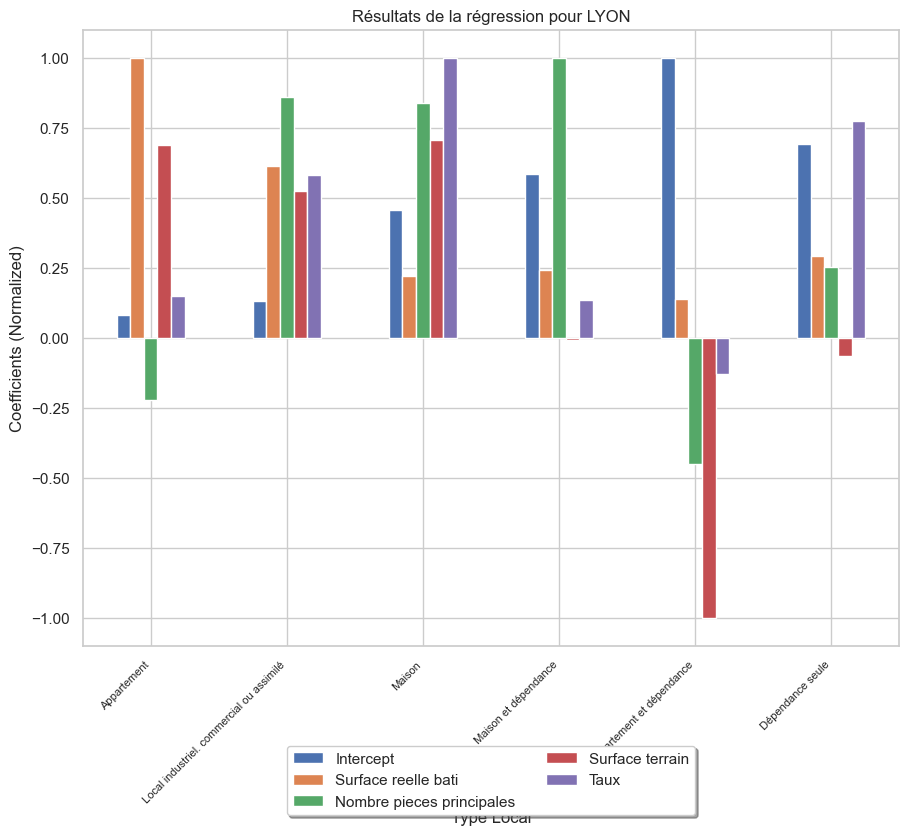

<Figure size 1000x600 with 0 Axes>

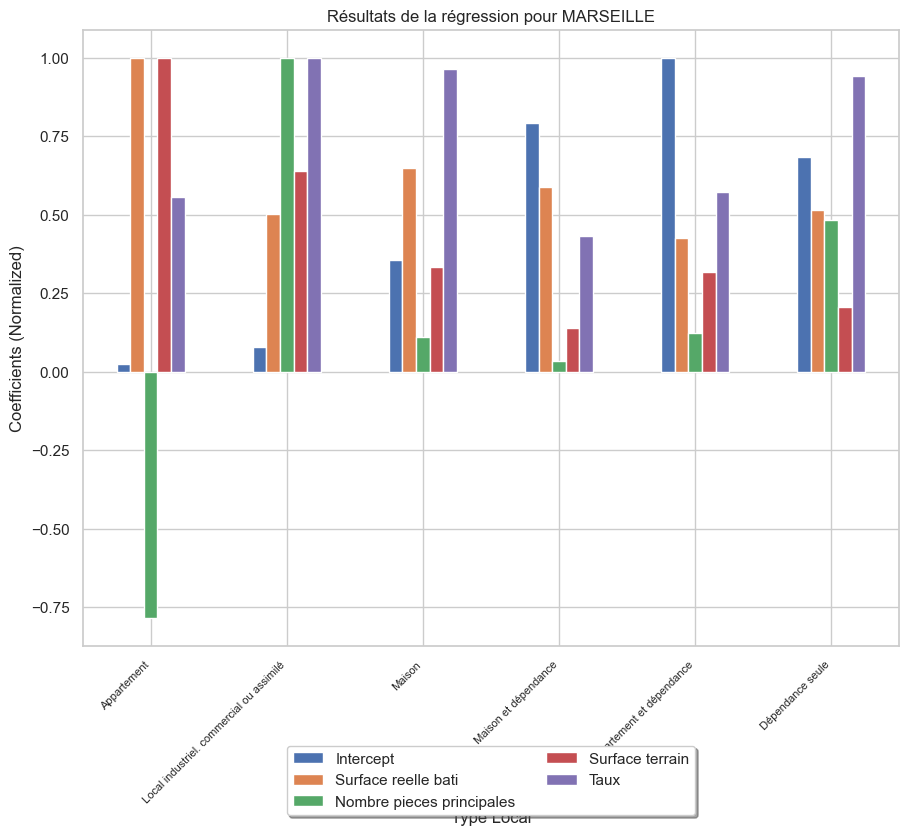

In [83]:
#regression expliquant la valeur fonciere par villes dynamiques 
reg(data_all_years,villes,'Commune', ols)

### Ville et département dynamique

#### Recherche des lieux dynamiques

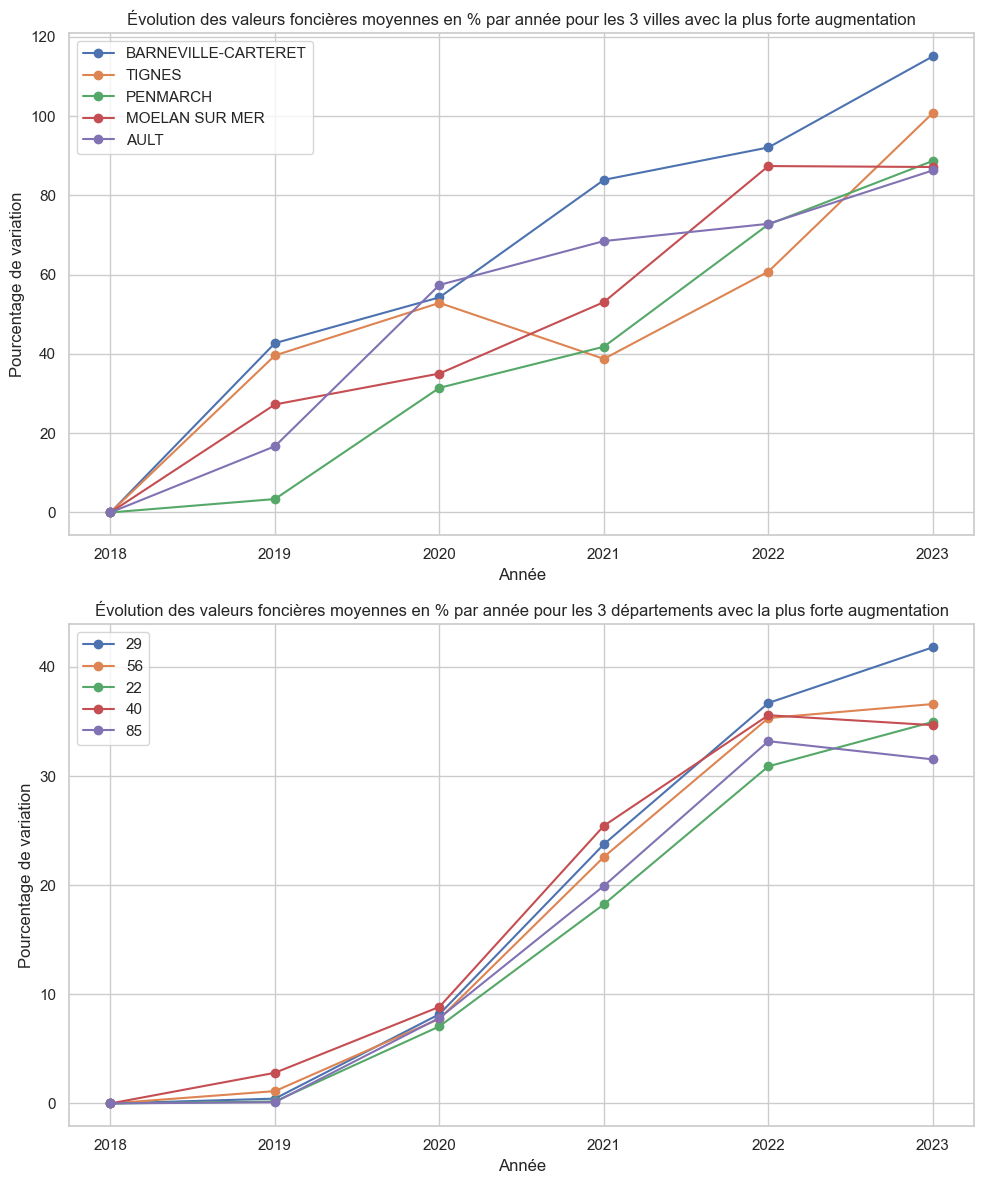

In [84]:
# Comptage du nombre d'occurrences de chaque commune
commune_counts = data_all_years['Commune'].value_counts()

# Filtrage des communes avec un nombre d'occurrences superieur a 500
valid_communes = commune_counts[commune_counts > 500].index

# Filtrage des donnees pour ne garder que les communes valides
all_data_filtered = data_all_years[data_all_years['Commune'].isin(valid_communes)]

# Calcul de la valeur fonciere moyenne par commune et par annee
mean_values_commune = all_data_filtered.groupby(['Commune', all_data_filtered.index.year])['Valeur fonciere'].mean()

# Calcul du pourcentage de variation par rapport a la premiere annee pour chaque commune
first_year_values = mean_values_commune.groupby('Commune').first()
percentage_change_commune = (mean_values_commune - first_year_values) / first_year_values * 100

# Calcul de la valeur fonciere moyenne par departement et par annee
mean_values_departement = data_all_years.groupby(['Département', data_all_years.index.year])['Valeur fonciere'].mean()

# Calcul du pourcentage de variation par rapport à la premiere annee pour chaque departement
first_year_values_departement = mean_values_departement.groupby('Département').first()
percentage_change_departement = (mean_values_departement - first_year_values_departement) / first_year_values_departement * 100

# Selection des 3 villes avec la plus forte augmentation
top_communes = percentage_change_commune.groupby('Commune').last().nlargest(5).index
top_departements = percentage_change_departement.groupby('Département').last().nlargest(5).index

# Creation du graphique
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Trace de l'evolution pour les villes
for commune in top_communes:
    percentage_change_commune.loc[commune].plot(ax=axes[0], marker='o', linestyle='-', label=commune)

axes[0].set_title("Évolution des valeurs foncières moyennes en % par année pour les 3 villes avec la plus forte augmentation")
axes[0].set_xlabel("Année")
axes[0].set_ylabel("Pourcentage de variation")
axes[0].legend()
axes[0].grid(True)

# Tracage de l'evolution pour les departements
for departement in top_departements:
    percentage_change_departement.loc[departement].plot(ax=axes[1], marker='o', linestyle='-', label=departement)

axes[1].set_title("Évolution des valeurs foncières moyennes en % par année pour les 3 départements avec la plus forte augmentation")
axes[1].set_xlabel("Année")
axes[1].set_ylabel("Pourcentage de variation")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

/var/folders/5j/h3r6q8550vg1h4rc69vgdp5c0000gn/T/ipykernel_2806/4240956726.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  percentage_change_commune = mean_values_commune.unstack().pct_change(axis=1) * 100


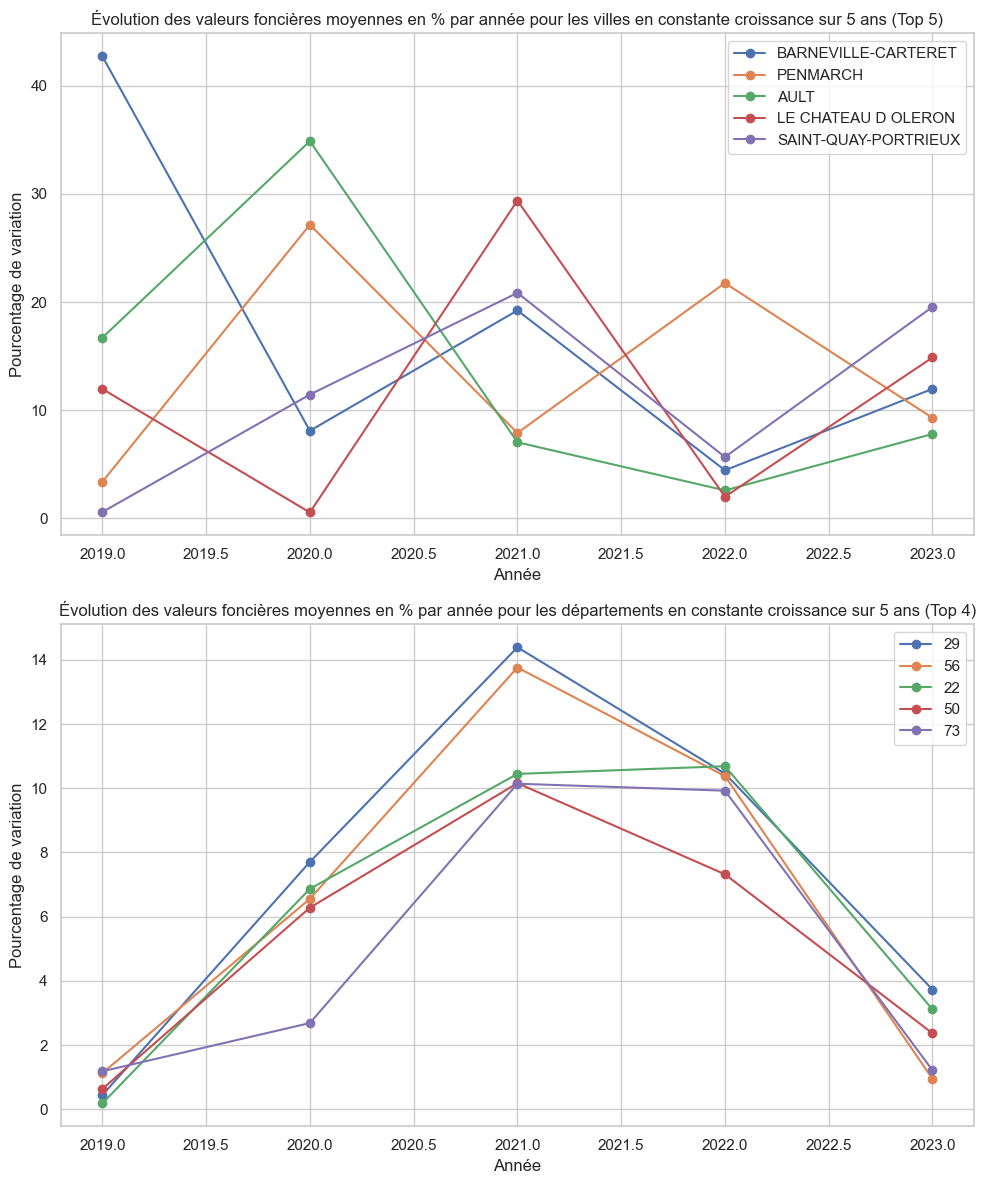

In [85]:
# Calcul du pourcentage de variation par rapport à l'annee precedente pour chaque commune
percentage_change_commune = mean_values_commune.unstack().pct_change(axis=1) * 100

# Selection des communes en constante croissance sur les 5 annees
growing_communes = (percentage_change_commune > 0).sum(axis=1) == 5 #10

#liste des villes les plus attractives 
selected_communes = percentage_change_commune[growing_communes].mean(axis=1).nlargest(5).index 

# Calcul du pourcentage de variation par rapport à l'annee precedente pour chaque departement
percentage_change_departement = mean_values_departement.unstack().pct_change(axis=1) * 100

# Selection des departements en constante croissance sur les 5 annees
growing_departements = (percentage_change_departement > 0).sum(axis=1) == 5 #10

#liste des departements les plus attractifs 
selected_departements = percentage_change_departement[growing_departements].mean(axis=1).nlargest(5).index

# Selection des données pour les villes et departements en constante croissance
all_data_filtered_growth = all_data_filtered[all_data_filtered['Commune'].isin(selected_communes)]
all_data_growth = data_all_years[data_all_years['Département'].isin(selected_departements)]

# Calcul de la valeur fonciere moyenne par commune et par annee pour les données filtrees
mean_values_commune_growth = all_data_filtered_growth.groupby(['Commune', all_data_filtered_growth.index.year])['Valeur fonciere'].mean()

# Calcul de la valeur fonciere moyenne par departement et par annee pour les données filtrees
mean_values_departement_growth = all_data_growth.groupby(['Département', all_data_growth.index.year])['Valeur fonciere'].mean()


# Creation du graphique
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Tracage de l'evolution pour les villes
for commune in selected_communes:
    percentage_change_commune.loc[commune].plot(ax=axes[0], marker='o', linestyle='-', label=commune)

axes[0].set_title("Évolution des valeurs foncières moyennes en % par année pour les villes en constante croissance sur 5 ans (Top 5)")
axes[0].set_xlabel("Année")
axes[0].set_ylabel("Pourcentage de variation")
axes[0].legend()
axes[0].grid(True)

# Tracage de l'evolution pour les départements
for departement in selected_departements:
    percentage_change_departement.loc[departement].plot(ax=axes[1], marker='o', linestyle='-', label=departement)

axes[1].set_title("Évolution des valeurs foncières moyennes en % par année pour les départements en constante croissance sur 5 ans (Top 4)")
axes[1].set_xlabel("Année")
axes[1].set_ylabel("Pourcentage de variation")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

#### Villes

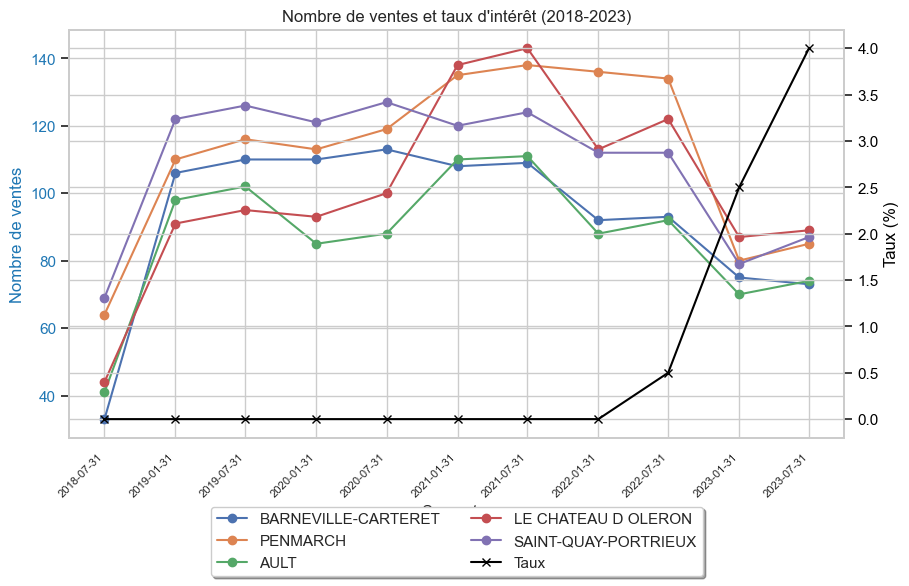

In [86]:
#Affichage du nombre de ventes par villes attractives  
occurences(selected_communes, 'Commune')

In [87]:
#Affichage du nombre m2 moyenn par villes dynamiques 
m2_moyen(selected_communes, 'Commune')

Moyenne de mètres carrés pour :
BARNEVILLE-CARTERET: 77.65633915602668 m2
PENMARCH: 94.62251844219854 m2
AULT: 58.391202822571124 m2
LE CHATEAU D OLERON: 81.05985980434214 m2
SAINT-QUAY-PORTRIEUX: 76.1749291495509 m2


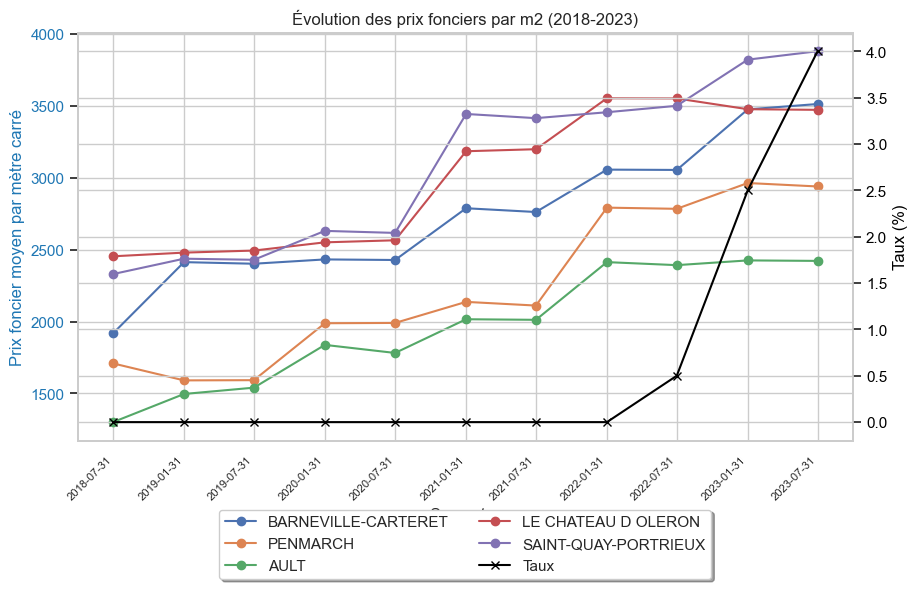

In [88]:
#Affichage du prix foncier moyen par m2 par villes dynamiques 
prix_moyen_par_metre_carre(selected_communes, 'Commune')

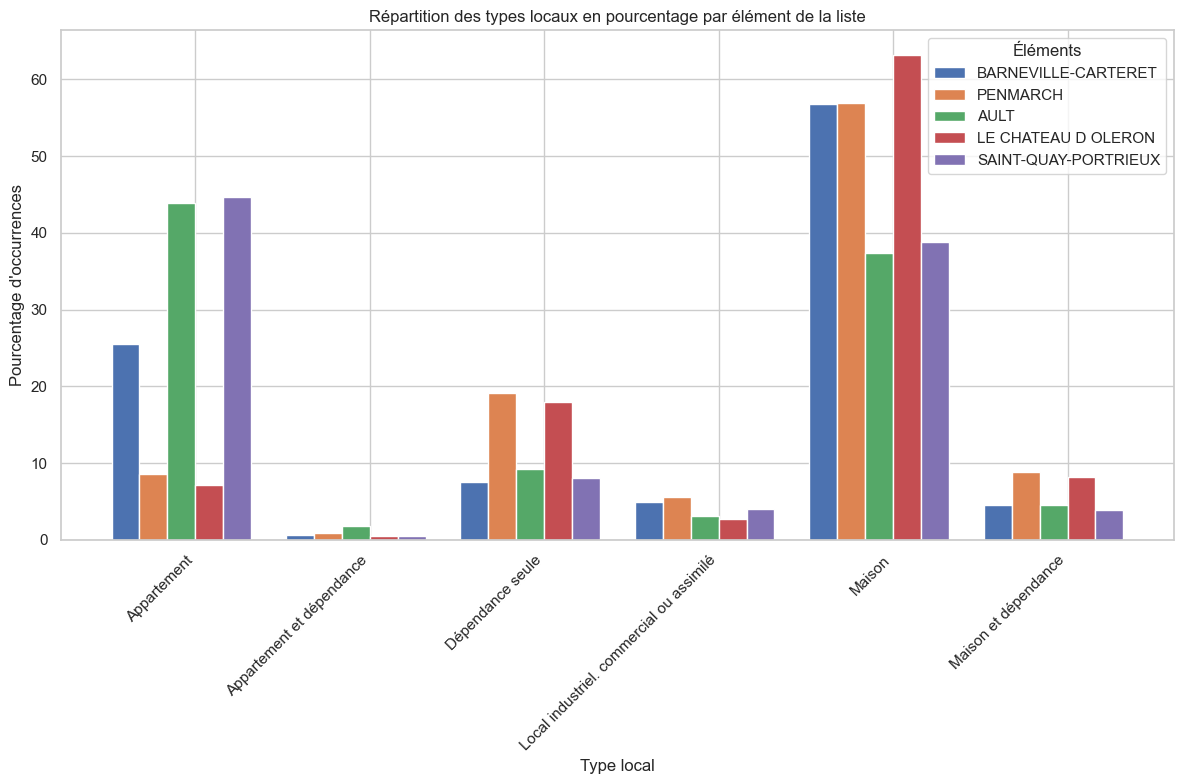

In [89]:
#Affichage de la repartition des types de local par villes dynamiques 
types_locales_single_histogram(selected_communes,'Commune')

#### Départements

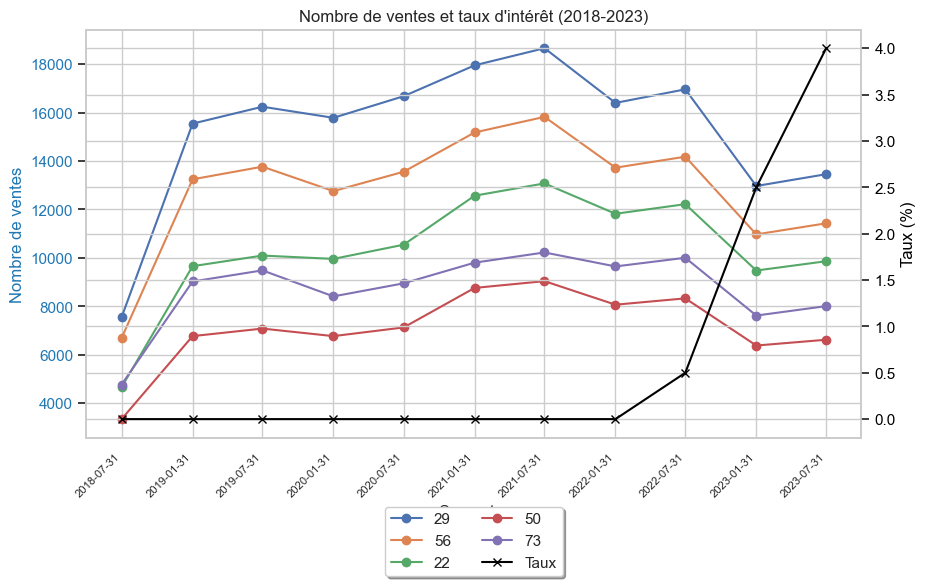

In [90]:
#Affichage du nombre de ventes par departements attractifs
occurences(selected_departements, 'Département')

In [91]:
#Affichage du nombre m2 moyenn par departements attractifs
m2_moyen(selected_departements, 'Département')

Moyenne de mètres carrés pour :
29: 88.90632588274394 m2
56: 89.66399400104488 m2
22: 92.48470851138313 m2
50: 91.45970354475774 m2
73: 68.58058909970464 m2


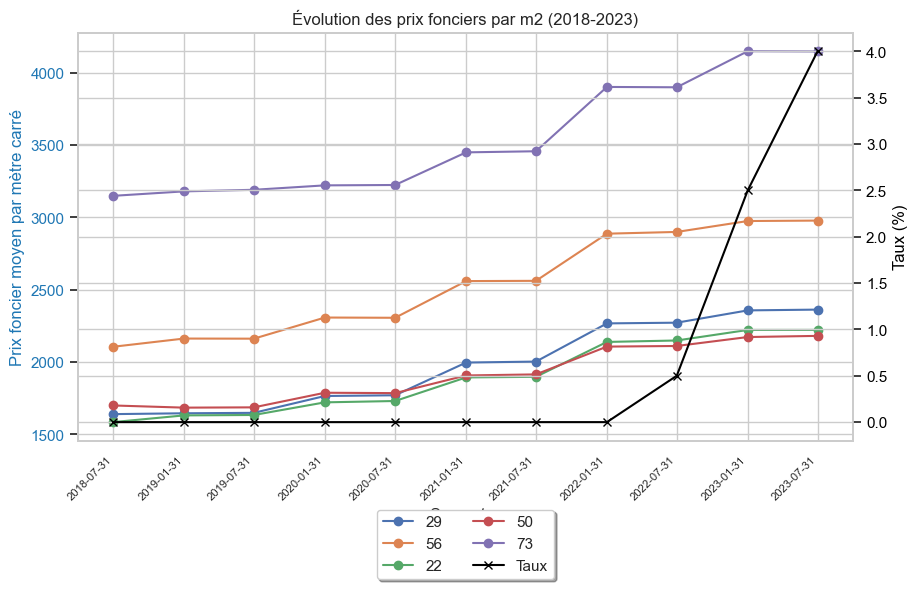

In [92]:
#Affichage du prix foncier moyen par m2 par departements attractifs
prix_moyen_par_metre_carre(selected_departements, 'Département')

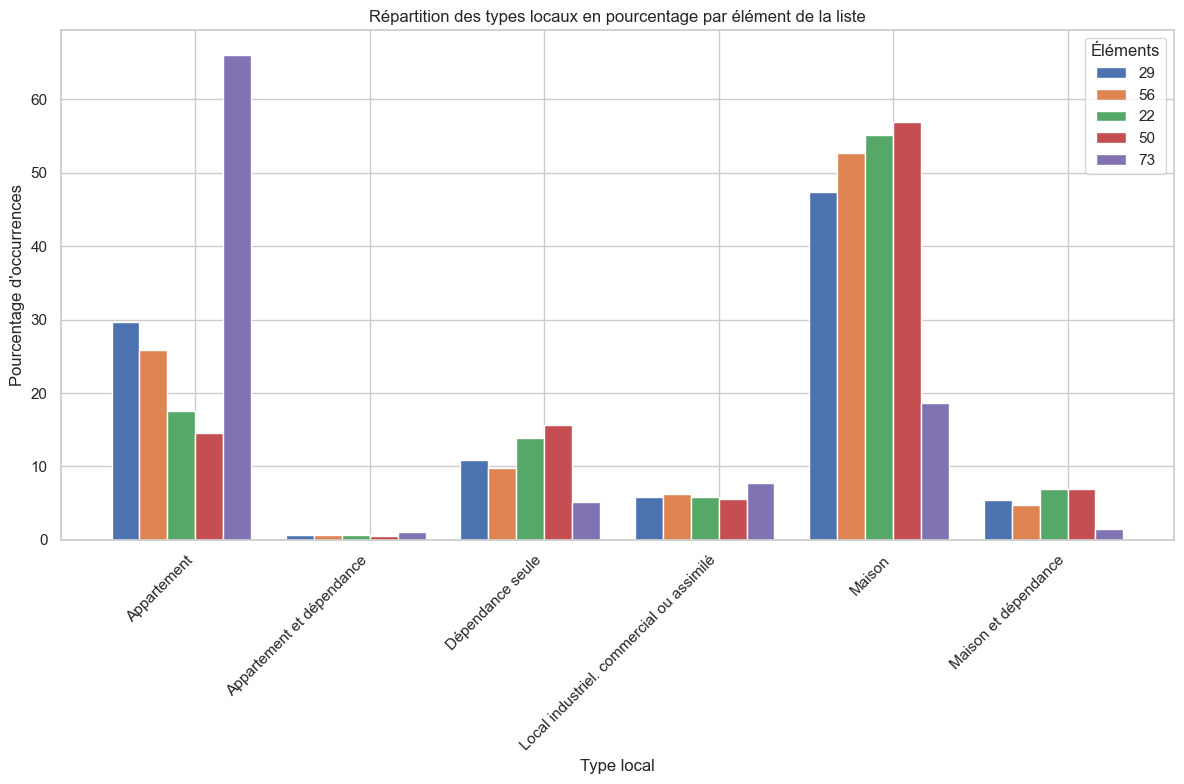

In [93]:
#Affichage de la repartition des types de local par departements attractifs
types_locales_single_histogram(selected_departements,'Département')

#### Regressions

##### Par villes

<Figure size 1000x600 with 0 Axes>

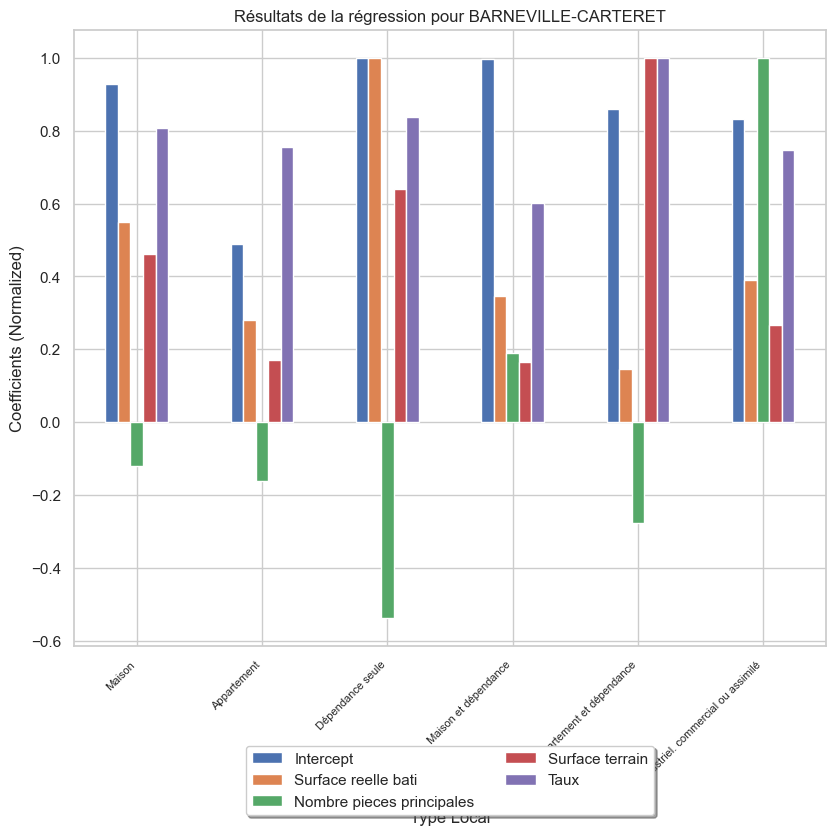

<Figure size 1000x600 with 0 Axes>

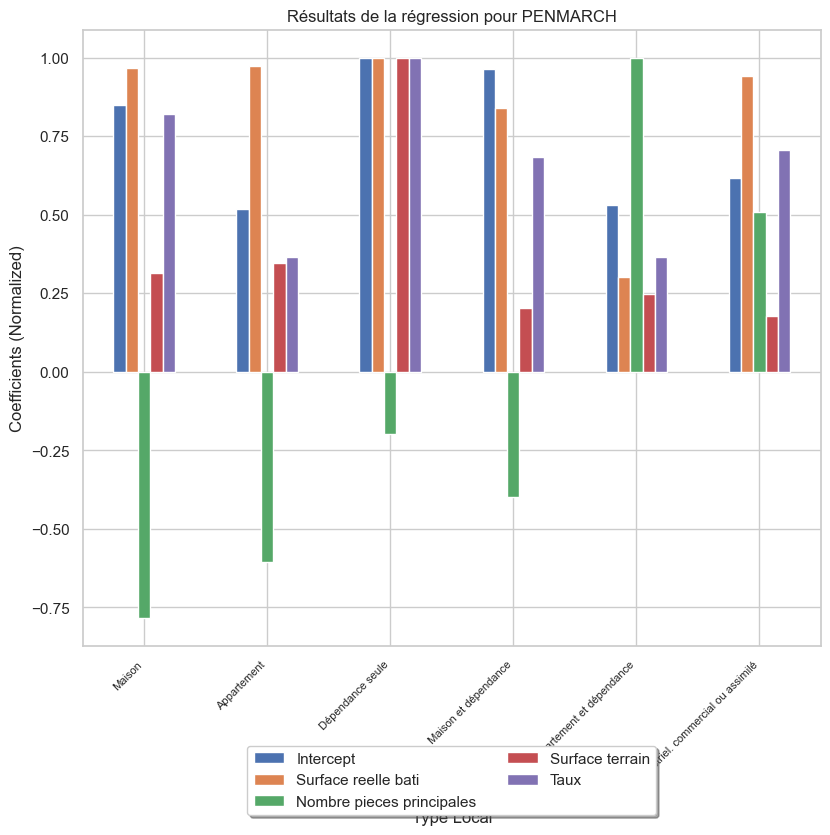

<Figure size 1000x600 with 0 Axes>

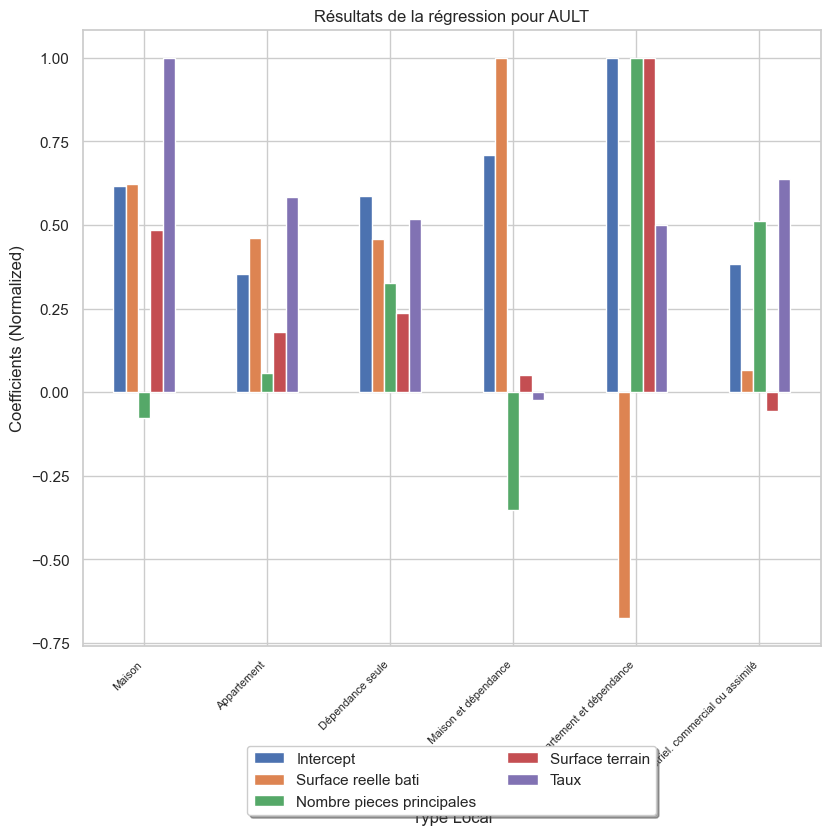

<Figure size 1000x600 with 0 Axes>

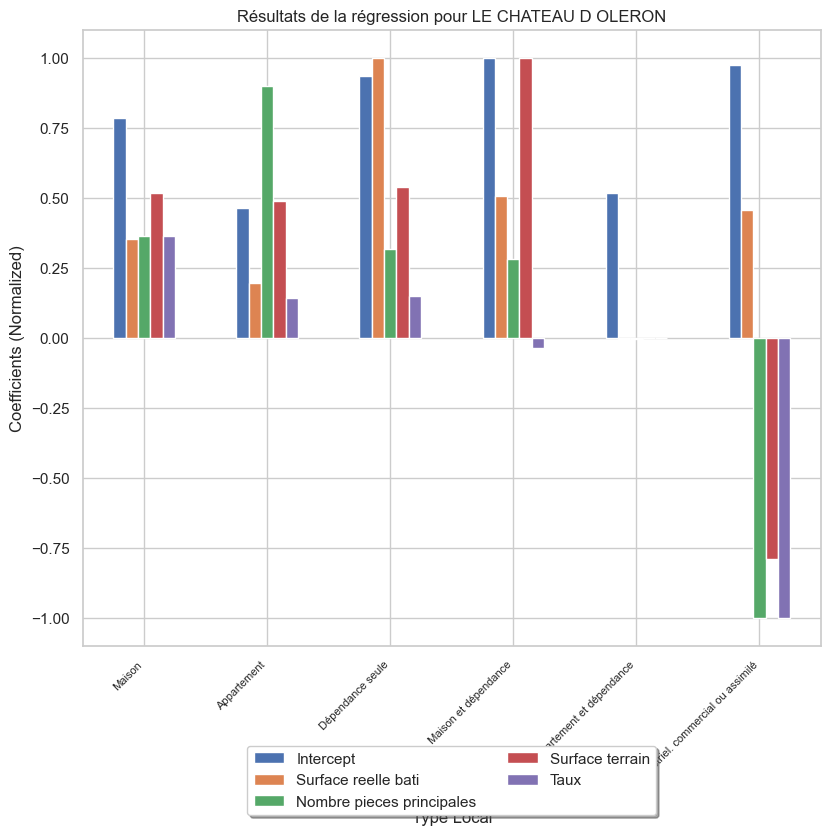

<Figure size 1000x600 with 0 Axes>

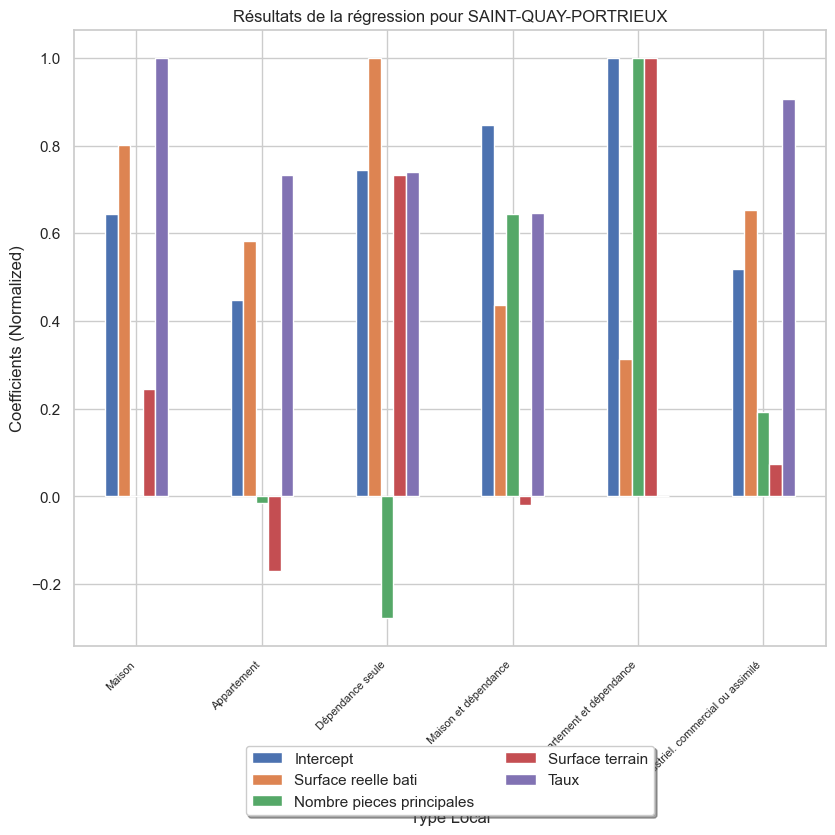

In [94]:
#regression expliquant la valeur fonciere par villes attractives 
reg(data_all_years,selected_communes,'Commune', ridge)

##### Par départements

<Figure size 1000x600 with 0 Axes>

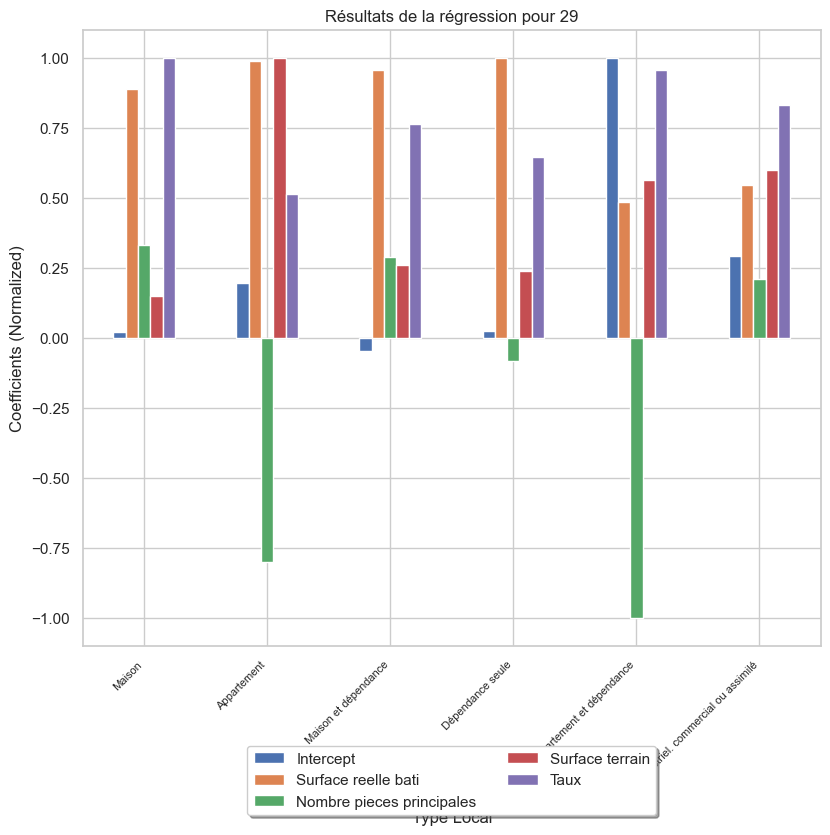

<Figure size 1000x600 with 0 Axes>

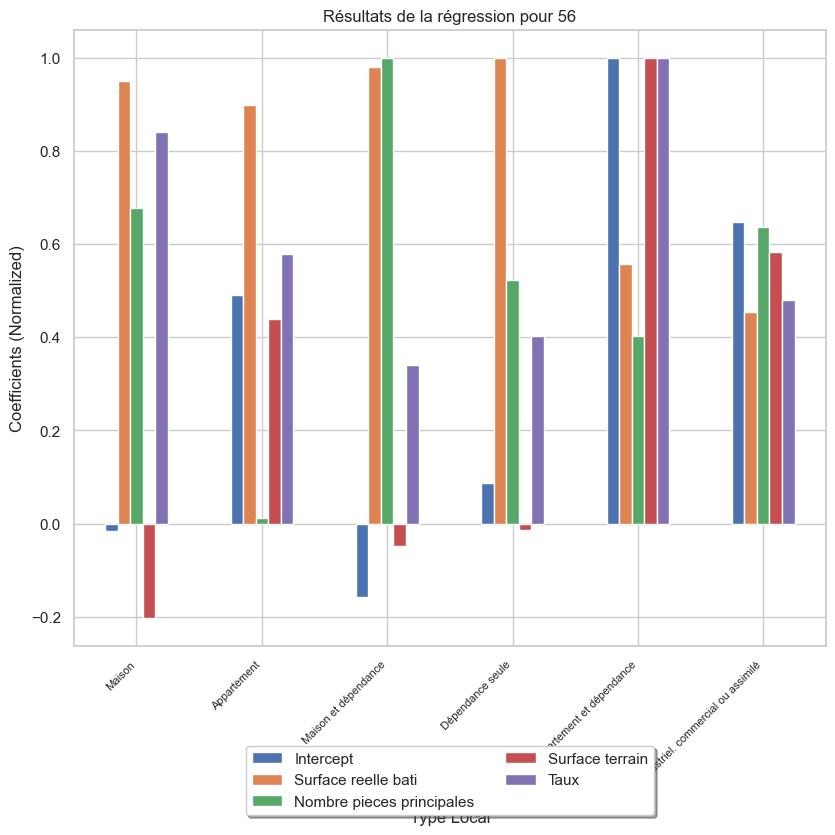

<Figure size 1000x600 with 0 Axes>

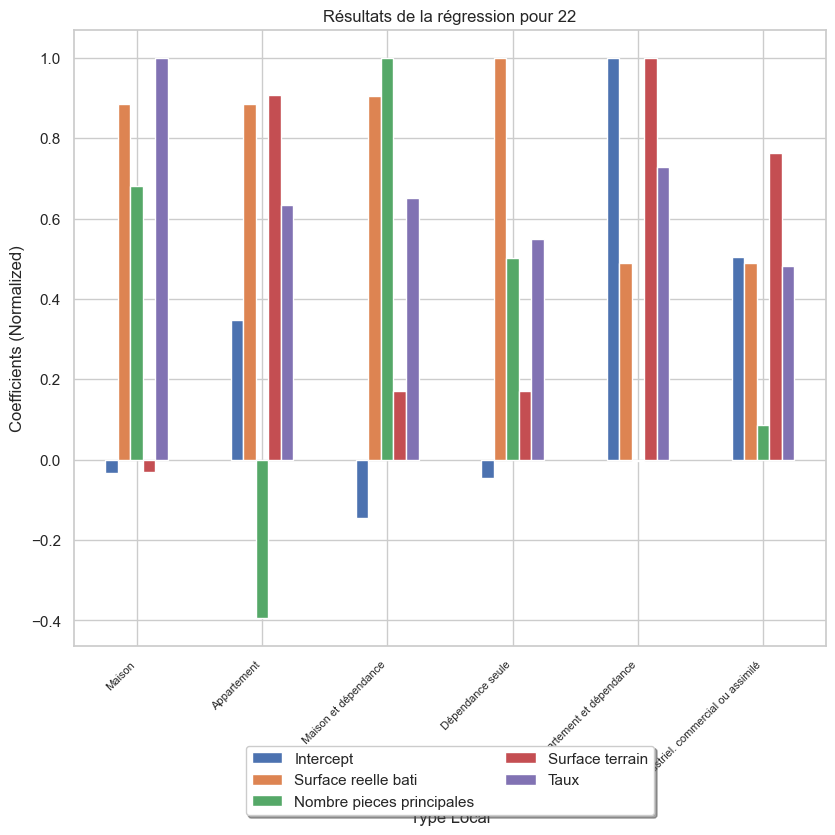

<Figure size 1000x600 with 0 Axes>

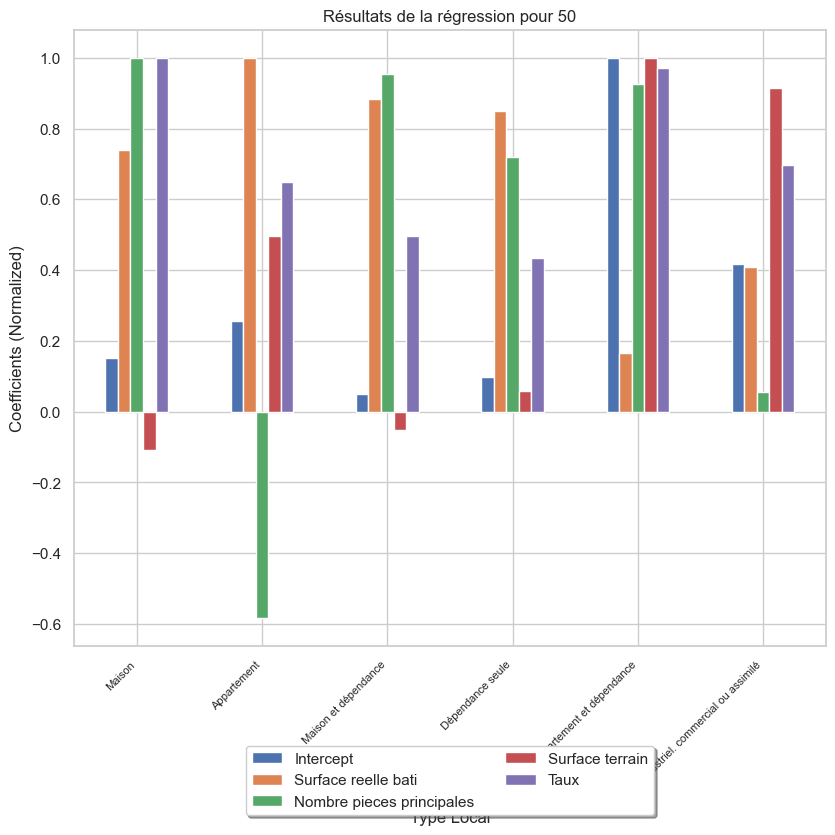

<Figure size 1000x600 with 0 Axes>

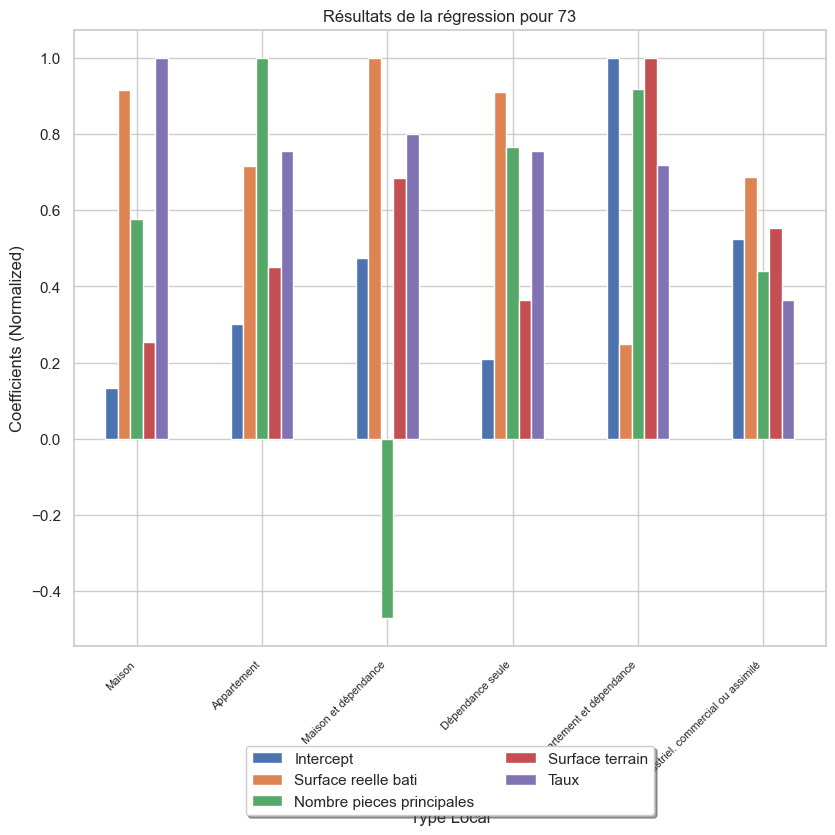

In [95]:
#regression expliquant la valeur fonciere par departement attractif
reg(data_all_years,selected_departements,'Département', ols)

# Machine Learning

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier



ModuleNotFoundError: No module named 'xgboost'

Le code suivant nous permet de récupérer le dataframe que nous souhaitons analyser avec les bonnes colonnes où nous transformons les données comme souhaité.

In [ ]:
df_ml = dataframes[-1].copy().reset_index()
# creation d une nouvelle colonne pour le mois en entier
df_ml['Mois'] = df_ml['Date mutation'].dt.month  
#Suppression de certaines colonnes
df_ml.drop(['Nature mutation','Valeur fonciere normalisee','Surface reelle bati','Nombre pieces principales normalisee','Surface terrain'], inplace=True, axis=1)

In [ ]:
nouvel_ordre = ['Date mutation', 'Mois', 'Valeur fonciere', 'Département', 'Code postal',
                'Commune', 'Surface reelle bati normalisee', 'Nombre pieces principales',
                'Type local', 'Surface terrain normalisee']


#Reorganisation des colonnes du DataFrame selon le nouvel ordre
df_ml = df_ml[nouvel_ordre]
#Mise en place de l index
df_ml.set_index('Date mutation', inplace=True)

In [ ]:
df_ml['Département'] = df_ml['Département'].astype("int")
df_ml['Code postal'] = df_ml['Code postal'].astype("int")

La liste suivante correspond au 20 villes les plus attractives, jugées comme les plus influentes de façon arbitraire.

In [ ]:
villes_loyer = ['PARIS','NANTERRE','SAINT-DENIS','CRETEIL','ORSAY','GUYANCOURT','NICE','CERGY','CHAMPS-SUR-MARNE',
                'EVRY','LYON','BORDEAUX', 'AIX EN PROVENCE','MARSEILLE','MONTPELLIER', 'LA ROCHELLE', 'LILLE',
                'TOULOUSE','TOULON']

In [ ]:
#Utilisation d isin pour creer un masque booléen des valeurs à conserver
mask = df_ml['Commune'].isin(villes_loyer)

#On garde les valeurs souhaitees (valeurs originales et 'autres')
df_ml['Commune'] = df_ml['Commune'].where(mask, 'Autres')

In [ ]:
#Modification du dataframe au niveau des villes
dico_villes = {}
villes_loyer.append("Autres")
for i, ville in enumerate(villes_loyer):
    dico_villes[ville] = i

df_ml['Commune'] = df_ml['Commune'].replace(dico_villes)


Création d'un ordre pour les types de locaux : Nous avons décidé d'attribuer des scores plus importants aux locaux les plus chers.

In [ ]:
dic = {'Appartement et dépendance' : 6,
       'Appartement' : 5,
       'Local industriel. commercial ou assimilé' : 4,
       'Dépendance seule' : 3,
       'Maison et dépendance' : 2,
       'Maison' : 1}
df_ml['Type local'] = df_ml['Type local'].replace(dic)


Le code suivant nous permet de créer des intervalles de valeurs pour la colonne Valeur fonciere.

In [ ]:
df_ml['Valeur Fonciere Cat'] = pd.qcut(df_ml['Valeur fonciere'], 3,
                                       labels=[0,1,2])


In [ ]:
df_ml_taux = df_ml

Le code suivant permet de rajouter la colonne des taux dans le dataframe que nous allons utiliser dans le modèle de machine learning.

In [ ]:
df_ml_taux['Taux'] = 0

date_debut = pd.to_datetime(df_taux.index[0])
date_fin = pd.to_datetime(df_taux.index[-1])

#Filtration de df_taux pour les dates qui tombent entre date_debut et date_fin
df_taux_filtre = df_taux[(df_taux.index >= date_debut) & (df_taux.index <= date_fin)]
df_taux_filtre.drop('TIME PERIOD', axis=1)

df_ml_taux['Taux'] = df_ml_taux.index.map(df_taux_filtre['Taux'])

Nous créons maintenant une matrice de corrélation entre la valeur foncière et les autres variables pour se rendre compte des différentes relations entre les variables.

In [ ]:
#matrice de correlation
corr_matrix = df_ml_taux.corr().loc[['Valeur fonciere'], :]

# Visualiser la matrice de corrélation avec une seule ligne pour 'Valeur fonciere'
plt.figure(figsize=(12, 1))  # Ajuster la taille pour une ligne
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'orientation': 'horizontal'})
plt.title('Corrélation avec Valeur Foncière')
plt.show()

### Classification models

In [ ]:
#Recuperarion de Valeur fonciere et Valeur fonciere Cat
X = df_ml.drop(['Valeur fonciere','Valeur Fonciere Cat'], axis=1)
#Creation de la targer (valeur a predire)
target = df_ml['Valeur Fonciere Cat']
#Model
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3)

#Code similaire avec les taux en supplement
X_taux = df_ml_taux.drop(['Valeur fonciere','Valeur Fonciere Cat'], axis=1)
target_taux = df_ml_taux['Valeur Fonciere Cat']
X_train_taux, X_test_taux, y_train_taux, y_test_taux = train_test_split(X_taux, target_taux, test_size=0.3)

#### Random forest

Le but de ce Random forest est d'essayer de déterminer les valeurs foncières des biens. Dans ce modèle, nous avons essayer de déterminer l'intervalle où se trouve la valeur du bien.

In [ ]:
#Creation du Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_taux = RandomForestClassifier(n_estimators=100, random_state=42)

#Entrainement du modele de data
rf_classifier.fit(X_train, y_train)
rf_classifier_taux.fit(X_train_taux, y_train_taux)

#Prediction des data testees 
y_pred = rf_classifier.predict(X_test)
y_pred_taux = rf_classifier_taux.predict(X_test_taux)

#Calcul de la precision du modele (avec et sans taux)
accuracy = accuracy_score(y_test, y_pred)
accuracy_taux = accuracy_score(y_test_taux, y_pred_taux)
print("Accuracy pour le modèle sans les taux:", accuracy)
print("Accuracy pour le modèle avec les taux:", accuracy_taux)

In [ ]:
#Creation de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_taux = confusion_matrix(y_test_taux, y_pred_taux)

#Matrice de de confusion (graphique)
print("Matrice de confusion pour le modèle sans les taux:")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0", "Class 1", "Class 2"],
            yticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

print("Matrice de confusion pour le modèle avec les taux:")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_taux, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0", "Class 1", "Class 2"],
            yticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#### XGBoost

In [ ]:
xgb_classifier = XGBClassifier()
xgb_classifier_taux = XGBClassifier()

#Entrainement du modele de data
xgb_classifier.fit(X_train, y_train)
xgb_classifier_taux.fit(X_train_taux, y_train_taux)

#Prediction des data testees 
y_pred = xgb_classifier.predict(X_test)
y_pred_taux = xgb_classifier_taux.predict(X_test_taux)

#Calcul de la precision du modele (avec et sans taux)
accuracy = accuracy_score(y_test, y_pred)
accuracy_taux = accuracy_score(y_test_taux, y_pred_taux)
print("Accuracy pour le modèle sans les taux:", accuracy)
print("Accuracy pour le modèle avec les taux:", accuracy_taux)

In [ ]:
#Creation de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
cong_matrix_taux = confusion_matrix(y_test_taux, y_pred_taux)

#Matrice de de confusion (graphique)
print("Matrice de confusion pour le modèle sans les taux:")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0", "Class 1", "Class 2"],
            yticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

print("Matrice de confusion pour le modèle avec les taux:")
plt.figure(figsize=(8, 6))
sns.heatmap(cong_matrix_taux, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0", "Class 1", "Class 2"],
            yticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()